## Data Update for 2024-06-10 export - Cleaning the Data

This file is to clean the New England Whalers data downloaded from the Whaling logbook database.

Only manual things to change should be the names of any figures and the original data file being read in. You will also need to create folders called 'CSV Files', 'Data Distributions', 'Figures', and 'Text Files' to save the outputs of this script to.

The main layout of this script is as follows:
1. Import the necessary packages and data, and drop any unnecessary columns and rows
2. Clean the data: this includes finding and deleting dates that occur twice in the same logbook, deleting test rows from dataset, remove repeated data from Leonidas and Margaret ship logs as there are multiple books, clean spelling and typing errors in various columns, and clean and convert wind direction into a number 0-360
3. Clean and standardize the latitude and longitude columns by flagging for common errors and fixing them as well as convert lat/lon values to decimal degrees
4. Plot the data: this includes plotting all data with a latitude and longitude to start. I also plot the data of each new logbook separately as a check to find potential errors in the dataset. In here we also convert our wind force terms to the beaufort wind scale (0-12) and plot all data that has a latitude, longitude, and beaufort value.
5. Save the data to a csv and pkl file

Note for user - I have also written a google doc with my step by step process when doing a new data export and clean

In [1]:
# Import
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime, os
from cartopy import crs as ccrs
from cartopy import feature as cfeature
import seaborn as sns
from tabulate import tabulate
import sys
from matplotlib.colors import Normalize

pd.options.display.max_columns = 50

print("Last updated on {}".format(datetime.datetime.now().ctime()))

Last updated on Wed Jun 12 10:22:15 2024


### Import Data

In [2]:
# labels corresponding to missing data
na_values = ['No observation', 'No observations', 'No Observation', 'No Observations',
             'no observation', 'no observations', 'None given', 'none given', 'None Given', 'none',
             'none recorded', 'not recorded', 'None recorded', 'Not given', 'not given', ' ']

# read CSV file into DataFrame
df = pd.read_csv('logentries-export-2024-06-10.csv', parse_dates={'DateTime':[3,4]},
                 na_values=na_values)

In [3]:
# Finding how many times there is a wind force value in the second or third
# observation but not first to see if we want to try and infill with these 

# Create a dataframe when original wind speed/force observation is nan, but 2. and 3. are not nan
df['wind force'] = (df["Wind Speed/Force"].isna() & (df["2. Wind Speed/Force"].notna() | df["3. Wind Speed/Force"].notna()))
df_wf = df[df['wind force']==True]
df_wf

DateTime      ID                       LogBook ID Page  \
35     1839-09-21 12:00:00  101340  Gideon Howland (Ship) 1838-1842   45   
568    1839-05-08 12:00:00  100791  Gideon Howland (Ship) 1838-1842   25   
664    1867-04-30 12:00:00  100682          Lancer (Ship) 1865-1868  NaN   
698    1837-11-10 12:00:00  100646          Martha (ship) 1836-1838   89   
704    1853-10-22 12:00:00  100640       Greyhound (Bark) 1851-1853  NaN   
...                    ...     ...                              ...  ...   
97343  1854-03-04 12:00:00    1415     A. Houghton (bark) 1853-1857  NaN   
97349  1854-02-26 12:00:00    1408     A. Houghton (bark) 1853-1857  NaN   
97354  1854-02-21 12:00:00    1403     A. Houghton (bark) 1853-1857  NaN   
97987  1860-09-06 12:00:00     713           Alpha (ship) 1860-1865   29   
98116  1855-08-08 12:00:00     580           Alpha (ship) 1855-1859   10   

           Latitude     Longitude Depth Depth Unit Bottom Current  \
35          00 08 N      176 59 E   NaN        NaN    NaN     NaN   
568             NaN           NaN   NaN        NaN    NaN     NaN   
664    Does not say  Does not say   NaN        NaN    NaN     NaN   
698         34 00 S       74 25 E   NaN    fathoms    NaN     NaN   
704         24 44 N       56 45 W   NaN        NaN    NaN     NaN   
...             ...           ...   ...        ...    ...     ...   
97343       37 52 S       66 39 E   NaN        NaN    NaN     NaN   
97349           NaN           NaN   NaN        NaN    NaN     NaN   
97354       38 27 S       30 14 E   NaN        NaN    NaN     NaN   
97987       39 07 N           NaN   NaN        NaN    NaN     NaN   
98116       39 53 N       32 08 W   NaN        NaN    NaN     NaN   

                                                Landmark  \
35                                                   NaN   
568          Heading out of New Zealand's Bay of Islands   
664                                                  NaN   
698                                                  NaN   
704                                                  NaN   
...                                                  ...   
97343                                                NaN   
97349                                                NaN   
97354                                                NaN   
97987  "Laying off and on at Fayal [...] At 8 pm got ...   
98116                         Off Flores Island (Azores)   

                    Ship Heading/Course      Wind Direction Wind Speed/Force  \
35                                  NaN                 NaN              NaN   
568                                 NaN                 NaN              NaN   
664                                 ENE                  SE              NaN   
698                                 NaN                 NaN              NaN   
704                             NW by N                 NaN              NaN   
...                                 ...                 ...              ...   
97343                               NaN                   N              NaN   
97349                     SE by E 1/2 E                  NE              NaN   
97354                           SE by E            Variable              NaN   
97987        Laying off and on at Fayal  not recorded (S ?)              NaN   
98116  Laying on & off Island of Flores                 NaN              NaN   

      Sea State Cloud Cover                   Weather 2. Ship Heading/Course  \
35         Calm         NaN          Squalls and Rain                      E   
568         NaN      Cloudy                       NaN                    NaN   
664         NaN         NaN                   Squally                    NaN   
698         NaN   thick fog                       NaN                      N   
704         NaN         NaN  Calm, Pleasant, and Warm                    NaN   
...         ...         ...                       ...                    ...   
97343       NaN         NaN      T

In [4]:
# Dropping columns not needed
columns_to_drop = ['Current', '2. Ship Heading/Course', '2. Wind Direction', '2. Wind Speed/Force', 
                   '2. Sea State', '2. Cloud Cover', '2. Weather', '3. Ship Heading', '3. Wind Direction', 
                   '3. Wind Speed/Force', '3. Sea State', '3. Cloud Cover', '3. Weather',
                   'Instrumental Observations']

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Check dataframe to make sure unnecessary columns are gone
df.head

<bound method NDFrame.head of                   DateTime      ID                LogBook ID Page Latitude  \
0      1867-12-15 12:00:00  101378  Catalpa (bark) 1867-1871   48  57 30 S   
1      1867-12-14 12:00:00  101377  Catalpa (bark) 1867-1871   47  58 30 S   
2      1867-12-13 12:00:00  101376  Catalpa (bark) 1867-1871   47  59 10 S   
3      1867-12-12 12:00:00  101375  Catalpa (bark) 1867-1871   47  58 08 S   
4      1867-12-11 12:00:00  101374  Catalpa (bark) 1867-1871   47  57 50 S   
...                    ...     ...                       ...  ...      ...   
98173  1855-11-06 12:00:00     520    Alpha (ship) 1855-1859   26  40 07 S   
98174  1855-11-05 12:00:00     519    Alpha (ship) 1855-1859   26  39 59 S   
98175  1855-11-04 12:00:00     518    Alpha (ship) 1855-1859   26  40 23 S   
98176  1855-11-03 12:00:00     517    Alpha (ship) 1855-1859   26  40 05 S   
98177  1855-11-02 12:00:00     516    Alpha (ship) 1855-1859   26  38 59 S   

      Longitude Depth Depth Unit 

In [6]:
# Check dataframe to make sure unnecessary columns are gone
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98178 entries, 0 to 98177
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   DateTime                    98178 non-null  object
 1   ID                          98178 non-null  int64 
 2   LogBook ID                  98177 non-null  object
 3   Page                        64713 non-null  object
 4   Latitude                    78511 non-null  object
 5   Longitude                   69738 non-null  object
 6   Depth                       2223 non-null   object
 7   Depth Unit                  24472 non-null  object
 8   Bottom                      65 non-null     object
 9   Landmark                    15417 non-null  object
 10  Ship Heading/Course         55043 non-null  object
 11  Wind Direction              70069 non-null  object
 12  Wind Speed/Force            86434 non-null  object
 13  Sea State                   5349 non-null   ob

In [7]:
# Setting up a folder system to save files and figures to 
# Create folders called "Figures", "Text Files", and "CSV Files" manually to save everything to 

# Get current directory
current_directory = os.getcwd()

# Specify the path to the folder you want to save data to 
Figures = os.path.join(current_directory, 'Figures')
Files = os.path.join(current_directory, 'Text Files')
CSV = os.path.join(current_directory, 'CSV Files')


# Cleaning Data

Dropping 'TEST LOG BOOK NAME' Entries

In [8]:
df.drop(df.loc[df["LogBook ID"] == "TEST LOG BOOK NAME"].index,axis=0,inplace=True)

Dropping 'Westward-1978' Entries

In [9]:
#df.drop(df.loc[df["Entry Date Time"].dt.year==2021.].index,axis=0,inplace=True)
df.drop(df.loc[df["LogBook ID"]=="Westward-1978"].index,inplace=True)
df.drop(df.loc[df["LogBook ID"]=="55"].index,inplace=True)

In [10]:
np.shape(df)

(98166, 19)

Manual Cleanups

In [11]:
# replace DateTime-strings that end with ' nan' with np.nan
# df.DateTime.str.endswith(' nan') #returns a boolean list of all rows, setting rows that fulfill the .endswith query to True and all others to False.
# df.loc[boolean-list,'DateTime'] accesses the 'DateTime' column of those rows that were set to True. = np.nan sets those values to NaN values.
df.loc[df.DateTime.str.endswith(' nan'), 'DateTime'] = np.nan

In [12]:
# converting 'DateTime' column to actual DateTime and calling it "Entry Date Time"
df['Entry Date Time'] = pd.to_datetime(df.DateTime, format = '%Y-%m-%d %H:%M:%S')
# deleting row "DateTime"
df.drop('DateTime',axis=1)

ID                LogBook ID Page Latitude Longitude Depth  \
0      101378  Catalpa (bark) 1867-1871   48  57 30 S   73 40 W   NaN   
1      101377  Catalpa (bark) 1867-1871   47  58 30 S   69 40 W   NaN   
2      101376  Catalpa (bark) 1867-1871   47  59 10 S   67 41 W   NaN   
3      101375  Catalpa (bark) 1867-1871   47  58 08 S   68 30 W   NaN   
4      101374  Catalpa (bark) 1867-1871   47  57 50 S   67 32 W   NaN   
...       ...                       ...  ...      ...       ...   ...   
98173     520    Alpha (ship) 1855-1859   26  40 07 S   39 02 E   NaN   
98174     519    Alpha (ship) 1855-1859   26  39 59 S   28 09 E   NaN   
98175     518    Alpha (ship) 1855-1859   26  40 23 S   23 37 E   NaN   
98176     517    Alpha (ship) 1855-1859   26  40 05 S   19 43 E   NaN   
98177     516    Alpha (ship) 1855-1859   26  38 59 S   16 36 E   NaN   

      Depth Unit Bottom Landmark Ship Heading/Course Wind Direction  \
0            NaN    NaN      NaN                   W            SSW   
1            NaN    NaN      NaN                 WSW              S   
2            NaN    NaN      NaN                  SE             SW   
3            NaN    NaN      NaN                 NaN     SSW to WSW   
4            NaN    NaN      NaN                 NaN              W   
...          ...    ...      ...                 ...            ...   
98173    Fathoms    NaN      NaN             SE by E      From N NW   
98174    Fathoms    NaN      NaN   "Middle moderate"      From N NW   
98175    Fathoms    NaN      NaN             SE by E      From N NW   
98176    Fathoms    NaN      NaN             SE by S    From W by S   
98177    Fathoms    NaN      NaN              W by S    From S by W   

                     Wind Speed/Force Sea State Cloud Cover       Weather  \
0                         Strong Gale       NaN         NaN           NaN   
1                        Strong Winds       NaN         NaN           NaN   
2                         Strong Gale       NaN         NaN           NaN   
3                        Strong Winds       NaN         NaN  Rain Squalls   
4                         Light Winds       NaN         NaN       Squalls   
...                               ...       ...         ...           ...   
98173                   Moderate Gale       NaN         NaN       Squally   
98174  Strong Breeze and Squally Wind       NaN         NaN           NaN   
98175                   Strong Breeze       NaN         NaN           NaN   
98176                   Strong Breeze       NaN         NaN           NaN   
98177                           Light       NaN         NaN           NaN   

      Ship Sightings                         Miscellaneous Observations  \
0                NaN                                                NaN   
1                NaN                                                NaN   
2                NaN                                                NaN   
3                NaN                                                NaN   
4                NaN                                                NaN   
...              ...                                                ...   
98173            NaN  "Under fore and main topsail and foresail, miz...   
98174            NaN           "Took in Fore and Main topgallant sails"   
98175            NaN                     "Under double-reefed topsails"   
98176            NaN                      "Furled the mainsail and jib"   
98177            NaN  "Finbacks in Light"\r "Tacked ship and made sa...   

       wind force     Entry Date Time  
0           False 1867-12-15 12:00:00  
1           False 1867-12-14 12:00:00  
2           False 1867-12-13 12:00:00  
3           False 1867-12-12 12:00:00  
4           False 1867-12-11 12:00:00  
...           ...                 ...  
98173       False 1855-11-06 12:00:00  
98174       False 1855-11-05 12:00:00  
98175       False 1855-11-04 12:00:00  
98176       False 1855-11-03 12:00:00  
98177       Fal

### Removing repeated data

Both Leonidas and Margaret ships have multiple logbooks where data entries overlap.
This will prevent having duplicate data for these instances. 

In [13]:
# Removing potential duplicates of data from the Leonidas ships

# Filter rows corresponding to "Leonidas (ship) Journal 1830-1833" and "Leonidas (ship) 1830-1833"
leonidas_journal_rows = df[df['LogBook ID'] == 'Leonidas (ship) Journal 1830-1833']
leonidas_rows = df[df['LogBook ID'] == 'Leonidas (ship) 1830-1833']

# Get the 'Entry Date Time' values from "Leonidas (ship) Journal 1830-1833"
journal_entry_times = leonidas_journal_rows['Entry Date Time']

# Find indices of rows from "Leonidas (ship) Journal 1830-1833" that have the same 'Entry Date Time' values as in "Leonidas (ship) 1830-1833"
indices_to_drop = leonidas_journal_rows[leonidas_journal_rows['Entry Date Time'].isin(leonidas_rows['Entry Date Time'])].index

# Drop the "Leonidas (ship) Journal 1830-1833" rows from the original DataFrame
df = df.drop(indices_to_drop)
df

# This should end up getting rid of all Leonidas Journal entries, we do not need them as 
# they duplicate the other Leonidas official data 

DateTime      ID                LogBook ID Page Latitude  \
0      1867-12-15 12:00:00  101378  Catalpa (bark) 1867-1871   48  57 30 S   
1      1867-12-14 12:00:00  101377  Catalpa (bark) 1867-1871   47  58 30 S   
2      1867-12-13 12:00:00  101376  Catalpa (bark) 1867-1871   47  59 10 S   
3      1867-12-12 12:00:00  101375  Catalpa (bark) 1867-1871   47  58 08 S   
4      1867-12-11 12:00:00  101374  Catalpa (bark) 1867-1871   47  57 50 S   
...                    ...     ...                       ...  ...      ...   
98173  1855-11-06 12:00:00     520    Alpha (ship) 1855-1859   26  40 07 S   
98174  1855-11-05 12:00:00     519    Alpha (ship) 1855-1859   26  39 59 S   
98175  1855-11-04 12:00:00     518    Alpha (ship) 1855-1859   26  40 23 S   
98176  1855-11-03 12:00:00     517    Alpha (ship) 1855-1859   26  40 05 S   
98177  1855-11-02 12:00:00     516    Alpha (ship) 1855-1859   26  38 59 S   

      Longitude Depth Depth Unit Bottom Landmark Ship Heading/Course  \
0       73 40 W   NaN        NaN    NaN      NaN                   W   
1       69 40 W   NaN        NaN    NaN      NaN                 WSW   
2       67 41 W   NaN        NaN    NaN      NaN                  SE   
3       68 30 W   NaN        NaN    NaN      NaN                 NaN   
4       67 32 W   NaN        NaN    NaN      NaN                 NaN   
...         ...   ...        ...    ...      ...                 ...   
98173   39 02 E   NaN    Fathoms    NaN      NaN             SE by E   
98174   28 09 E   NaN    Fathoms    NaN      NaN   "Middle moderate"   
98175   23 37 E   NaN    Fathoms    NaN      NaN             SE by E   
98176   19 43 E   NaN    Fathoms    NaN      NaN             SE by S   
98177   16 36 E   NaN    Fathoms    NaN      NaN              W by S   

      Wind Direction                Wind Speed/Force Sea State Cloud Cover  \
0                SSW                     Strong Gale       NaN         NaN   
1                  S                    Strong Winds       NaN         NaN   
2                 SW                     Strong Gale       NaN         NaN   
3         SSW to WSW                    Strong Winds       NaN         NaN   
4                  W                     Light Winds       NaN         NaN   
...              ...                             ...       ...         ...   
98173      From N NW                   Moderate Gale       NaN         NaN   
98174      From N NW  Strong Breeze and Squally Wind       NaN         NaN   
98175      From N NW                   Strong Breeze       NaN         NaN   
98176    From W by S                   Strong Breeze       NaN         NaN   
98177    From S by W                           Light       NaN         NaN   

            Weather Ship Sightings  \
0               NaN            NaN   
1               NaN            NaN   
2               NaN            NaN   
3      Rain Squalls            NaN   
4           Squalls            NaN   
...             ...            ...   
98173       Squally            NaN   
98174           NaN            NaN   
98175           NaN            NaN   
98176           NaN            NaN   
98177           NaN            NaN   

                              Miscellaneous Observations  wind force  \
0                                                    NaN       False   
1                                                    NaN       False   
2                                                    NaN       False   
3                                                    NaN       False   
4                                                    NaN       False   
...                                                  ...         ...   
98173  "Under fore and main topsail and foresail, miz...       False   
98174           "Took in Fore and Main topgallant sails"       False   
98175                     "Under double-reefed topsails"       False   
98176                      "Furled the mainsail and jib"       False   
98177  "Finbacks in Light"\r "

In [14]:
# Removing potential duplicates of data from the Margaret ships

# Filter rows corresponding to "Margaret (ship) 1835-1836"
margaret_1835_1836_rows = df[df['LogBook ID'] == 'Margaret (ship) 1835-1836']

# Drop rows corresponding to "Margaret (ship) 1835-1836"
df = df.drop(margaret_1835_1836_rows.index)

# Filter rows corresponding to "Margaret (ship) 1835-1838" and "Margaret (Ship) 1835–1838"
margaret_ship_1835_1838_rows = df[df['LogBook ID'] == 'Margaret (ship) 1835-1838']
margaret_Ship_1835_1838_rows = df[df['LogBook ID'] == 'Margaret (Ship) 1835–1838']

# Find indices of rows from "Margaret (ship) 1835-1838" that have the same 'Entry Date Time' values as in "Margaret (Ship) 1835–1838"
indices_to_drop = margaret_ship_1835_1838_rows[margaret_ship_1835_1838_rows['Entry Date Time'].isin(margaret_Ship_1835_1838_rows['Entry Date Time'])].index

# Drop the rows from "Margaret (ship) 1835-1838" that have the same 'Entry Date Time' value as "Margaret (Ship) 1835–1838"
df = df.drop(indices_to_drop)

# Rename remaining entries from 'Margaret (ship) 1835-1838' to match 'Margaret (Ship) 1835-1838'
df['LogBook ID'] = df['LogBook ID'].replace('Margaret (ship) 1835-1838', 'Margaret (Ship) 1835-1838')
df

# This should get rid of all entries from Margaret 1835-1836 and then keep rows from
# Margaret (ship) where there are dates missing for Margaret (Ship) and delete the rest

DateTime      ID                LogBook ID Page Latitude  \
0      1867-12-15 12:00:00  101378  Catalpa (bark) 1867-1871   48  57 30 S   
1      1867-12-14 12:00:00  101377  Catalpa (bark) 1867-1871   47  58 30 S   
2      1867-12-13 12:00:00  101376  Catalpa (bark) 1867-1871   47  59 10 S   
3      1867-12-12 12:00:00  101375  Catalpa (bark) 1867-1871   47  58 08 S   
4      1867-12-11 12:00:00  101374  Catalpa (bark) 1867-1871   47  57 50 S   
...                    ...     ...                       ...  ...      ...   
98173  1855-11-06 12:00:00     520    Alpha (ship) 1855-1859   26  40 07 S   
98174  1855-11-05 12:00:00     519    Alpha (ship) 1855-1859   26  39 59 S   
98175  1855-11-04 12:00:00     518    Alpha (ship) 1855-1859   26  40 23 S   
98176  1855-11-03 12:00:00     517    Alpha (ship) 1855-1859   26  40 05 S   
98177  1855-11-02 12:00:00     516    Alpha (ship) 1855-1859   26  38 59 S   

      Longitude Depth Depth Unit Bottom Landmark Ship Heading/Course  \
0       73 40 W   NaN        NaN    NaN      NaN                   W   
1       69 40 W   NaN        NaN    NaN      NaN                 WSW   
2       67 41 W   NaN        NaN    NaN      NaN                  SE   
3       68 30 W   NaN        NaN    NaN      NaN                 NaN   
4       67 32 W   NaN        NaN    NaN      NaN                 NaN   
...         ...   ...        ...    ...      ...                 ...   
98173   39 02 E   NaN    Fathoms    NaN      NaN             SE by E   
98174   28 09 E   NaN    Fathoms    NaN      NaN   "Middle moderate"   
98175   23 37 E   NaN    Fathoms    NaN      NaN             SE by E   
98176   19 43 E   NaN    Fathoms    NaN      NaN             SE by S   
98177   16 36 E   NaN    Fathoms    NaN      NaN              W by S   

      Wind Direction                Wind Speed/Force Sea State Cloud Cover  \
0                SSW                     Strong Gale       NaN         NaN   
1                  S                    Strong Winds       NaN         NaN   
2                 SW                     Strong Gale       NaN         NaN   
3         SSW to WSW                    Strong Winds       NaN         NaN   
4                  W                     Light Winds       NaN         NaN   
...              ...                             ...       ...         ...   
98173      From N NW                   Moderate Gale       NaN         NaN   
98174      From N NW  Strong Breeze and Squally Wind       NaN         NaN   
98175      From N NW                   Strong Breeze       NaN         NaN   
98176    From W by S                   Strong Breeze       NaN         NaN   
98177    From S by W                           Light       NaN         NaN   

            Weather Ship Sightings  \
0               NaN            NaN   
1               NaN            NaN   
2               NaN            NaN   
3      Rain Squalls            NaN   
4           Squalls            NaN   
...             ...            ...   
98173       Squally            NaN   
98174           NaN            NaN   
98175           NaN            NaN   
98176           NaN            NaN   
98177           NaN            NaN   

                              Miscellaneous Observations  wind force  \
0                                                    NaN       False   
1                                                    NaN       False   
2                                                    NaN       False   
3                                                    NaN       False   
4                                                    NaN       False   
...                                                  ...         ...   
98173  "Under fore and main topsail and foresail, miz...       False   
98174           "Took in Fore and Main topgallant sails"       False   
98175                     "Under double-reefed topsails"       False   
98176                      "Furled the mainsail and jib"       False   
98177  "Finbacks in Light"\r "

### Double Dates

In [15]:
# Checking for dates that appear more than once in the same logbook
# This is important for making sure we do not have more usable data than we think

# Grouping the dates by their LogBook and finding where that date occurs more than once 
date_groups = df.groupby(['LogBook ID',df['Entry Date Time'].dt.date])
duplicate_date_groups = date_groups.filter(lambda group: len(group) > 1)

# Starting a total count of duplicate dates
count_total = 0

# Display the values 
for (logbook_id, date), group in duplicate_date_groups.groupby(['LogBook ID',duplicate_date_groups['Entry Date Time'].dt.date]):
    count = len(group)
    count_total += count
    ids = group['ID'].unique()
    print(f"Date: {date}, LogBook ID: {logbook_id}, IDs: {ids}")

print(f"Total count: {count_total}")
    

Date: 1852-03-12, LogBook ID: Abraham Barker (Ship) 1850-1853, IDs: [66920]
Date: 1851-12-28, LogBook ID: Arab (Ship) 1849-1853, IDs: [26609]
Date: 1852-08-15, LogBook ID: Arab (ship) 1852-1853, IDs: [47823]
Date: 1852-08-16, LogBook ID: Arab (ship) 1852-1853, IDs: [47824]
Date: 1852-08-17, LogBook ID: Arab (ship) 1852-1853, IDs: [47825]
Date: 1852-08-18, LogBook ID: Arab (ship) 1852-1853, IDs: [47826]
Date: 1853-07-21, LogBook ID: Arab (ship) 1852-1853, IDs: [48577]
Date: 1868-01-04, LogBook ID: Atlantic (bark) 1865-1868, IDs: [14073 14072]
Date: 1879-02-04, LogBook ID: Bertha (Bark) 1878-1881, IDs: [74244]
Date: 1844-01-27, LogBook ID: Blackstone (Bark) 1843-1845, IDs: [38918 38915]
Date: 1835-04-08, LogBook ID: Brunswick (ship) 1834-1837, IDs: [65915]
Date: 1858-12-29, LogBook ID: Brunswick (ship) 1856-1859, IDs: [8015]
Date: 1848-01-30, LogBook ID: Cambria (Ship) 1847-1851, IDs: [50859]
Date: 1848-12-04, LogBook ID: Cambria (Ship) 1847-1851, IDs: [51625]
Date: 1850-02-28, LogBook I

Some of these are instances when the ships crossed over the meridian or antimeridian and gained an extra day. Some of them also have notes saying there were two entries for that day. These can be left alone. Each instance of double dates to be left alone can be found in a google doc in the google drive for the most recent update.

In [16]:
# Fixing the dates that appear more than once

# Date time errors
df.drop(df[df['ID'] == 100333].index, inplace=True) # repeat of 100334 - updated 6/11 TG
df.drop(df[df['ID'] == 99893].index, inplace=True)  # repeat of 99892  - updated 6/11 TG
df.drop(df[df['ID'] == 100137].index, inplace=True) # repeat of 100138 - updated 6/11 TG
df.drop(df[df['ID'] == 101189].index, inplace=True) # repeat of 101190 - updated 6/11 TG

#Examples of how to fix
#df.drop(df[df['ID'] == 94073].index, inplace=True) # repeat of 94072 - updated 3/14 TG
#df.loc[df.ID == 95469,'DateTime'] = '1842-10-18 12:00:00' # was 10/17, date appeared twice - updated 3/14 TG


In [17]:
# getting rid of all leading 'Zero-Width No Space Breaks' (encoded as '\ufeff' in Python) in column 'ID'
#df['ID']=df.ID.str.lstrip('\ufeff')
# converting 'ID' values to Int32
#df['ID']=df.ID.astype('int32')

### Does not seem to be necessary anymore, 'ID' values are already read in as int64

### Cleaning page,depth, and ship sightings columns

In [18]:
# Removing bracketed page numbers from the right of the strings
df.loc[df['Page'].str.strip().str.startswith('(').fillna(False), 'Page'] = df.loc[df['Page'].str.strip().str.startswith('(').fillna(False), 'Page'].str[1:4]
df.loc[df['Page'].str.strip().str.endswith(')').fillna(False), 'Page'] = df.loc[df['Page'].str.strip().str.endswith(')').fillna(False), 'Page'].str[0:1]

In [19]:
with pd.option_context('display.max_rows', None,):
    print(df.loc[df['Page'].str.strip().str.endswith(')').fillna(False), 'Page',])
    print(df.loc[df['Page'].str.strip().str.startswith('(').fillna(False), 'Page',])

Series([], Name: Page, dtype: object)
Series([], Name: Page, dtype: object)


In [20]:
# cleanup of typos and '30-31'-esque entries in column 'Page'
df.loc[df.Page=='N','Page'] = np.nan
df.loc[df.Page=='N/a','Page'] = np.nan
df.loc[df.Page=='n/a`','Page'] = np.nan
df.loc[df.Page=='1-8','Page'] = 1
df.loc[df.Page=='3 1/2','Page'] = 3
df.loc[df.Page=='5 1/2','Page'] = 5
df.loc[df.Page=='14-15','Page'] = 14
df.loc[df.Page=='22-23','Page'] = 22
df.loc[df.Page=='30-31','Page'] = 30
df.loc[df.Page=='48-49','Page'] = 48
df.loc[df.Page=='94/95','Page'] = 94
df.loc[df.Page=='97-98','Page'] = 97
df.loc[df.Page=='108-109','Page'] = 108
df.loc[df.Page=='121 (says 107)','Page'] = 121
df.loc[df.Page=='122-123','Page'] = 122
df.loc[df.Page=='158-159','Page'] = 158
df.loc[df.Page=='159-160','Page'] = 160
df.loc[df.Page=='177-178','Page'] = 177
df.loc[df.Page=='186-187','Page'] = 186
df.loc[df.Page=='(8)','Page'] = 8
df.loc[df.Page=='(6)','Page'] = 6
df.loc[df.Page=='(4)','Page'] = 4
df.loc[df.Page=='(2)','Page'] = 2
df.loc[df.Page=='(16','Page'] = 16
df.loc[df.Page=='(17','Page'] = 17
df.loc[df.Page=='(18','Page'] = 18
df.loc[df.Page=='(19','Page'] = 19
df.loc[df.Page=='(20','Page'] = 20

#Converting page column to string 
#df['Page'] = df['Page'].astype(str)

#cleaning page numbers
df["Page"] = df.Page.str.rstrip('a')
df["Page"] = df.Page.str.rstrip('b')
df["Page"] = df.Page.str.lstrip('"')
df["Page"] = df.Page.str.rstrip('"')

# remove characters that cannot be converted to numerics 
#df['Page'] = df['Page'].str.replace(r'[^0-9-]', '', regex = True)

# converting 'Page' values to numeric
df['Page']=pd.to_numeric(df.Page, errors = 'coerce')

In [21]:
# manual clean-up of column 'Depth'
df['Depth'] = df.Depth.str.rstrip('Fathoms')
df.loc[df.Depth=='anchored in 5 fathoms of water','Depth'] = 5
df.loc[df.Depth=='2 1/2','Depth'] = 2.5
df.loc[df.Depth=='3 1/2','Depth'] = 3.5
df.loc[df.Depth=='4 1/2','Depth'] = 4.5
df.loc[df.Depth=='5 1/4','Depth'] = 5.25
df.loc[df.Depth=='5 1/2','Depth'] = 5.5
df.loc[df.Depth=='6-8','Depth'] = 7.
df.loc[df.Depth=='6 1/2','Depth'] = 6.5
df.loc[df.Depth=='7 1/2','Depth'] = 7.5
df.loc[df.Depth=='8 1/2','Depth'] = 8.5
df.loc[df.Depth=='8 (at Tarpaulin Cove)','Depth'] = 8.
df.loc[df.Depth=='9 1/2','Depth'] = 9.5
df.loc[df.Depth=='11 1/2','Depth'] = 11.5
df.loc[df.Depth=='12 1/2','Depth'] = 12.5
df.loc[df.Depth=='10-15','Depth'] = np.nan
df.loc[df.Depth=='20 then 11','Depth'] = np.nan
df.loc[df.Depth=='27 & 30','Depth'] = 28.5
df.loc[df.Depth=='28(8pm), 30(rest of night)','Depth'] = 29.
df.loc[df.Depth=='30 and 25','Depth'] = 27.5
df.loc[df.Depth=='35, 30','Depth'] = np.nan
df.loc[df.Depth=='35(11pm), 38(2am), 33(11am)','Depth'] = 35.
df.loc[df.Depth=='37, 27','Depth'] = np.nan
df.loc[df.Depth=='50 at start, 43 at 4 PM','Depth'] = np.nan
df.loc[df.Depth=='@ 3am 58, @ 7am 52','Depth'] = np.nan
df.loc[df.Depth=='50 (7pm), 65 (noon)','Depth'] = np.nan
df.loc[df.Depth=='54 (8pm), 70 (2am), 90 (4am)','Depth'] = np.nan
df.loc[df.Depth=='35, 22 (1pm, 4pm)','Depth'] = np.nan
df.loc[df.Depth=='50, 45, 40 (7pm, 11pm, 4am)','Depth'] = np.nan
df.loc[df.Depth=='`','Depth'] = np.nan
df.loc[df.Depth=='7pm 41, 9pm 31','Depth'] = np.nan
df.loc[df.Depth=='70 at 5','Depth'] = 70.
df.loc[df.Depth=='at 11 pm sounded in 45','Depth'] = 45.
df.loc[df.Depth=='23 @ 8:30pm, then 10 @ noon','Depth'] = 16.5
df.loc[df.Depth=='19 at 1:30pm, 17 at 7pm, 9 at 5'] = np.nan
df.loc[df.Depth=='55?'] = 55
df.loc[df.Depth=='at 4pm 80, at 6pm 52'] = np.nan
df.loc[df.Depth=='4.5 @ 1p'] = 4.5
df.loc[df.Depth=='10 @ 7p'] = 10
df.loc[df.Depth=='35 @ 7pm, 26 @ 8am, 20 @ 12p'] = np.nan
df.loc[df.Depth=='41 to 75'] = np.nan

# converting 'Depth' values to numeric
df['Depth'] = pd.to_numeric(df.Depth)

/tmp/ipykernel_603925/668818301.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.Depth=='19 at 1:30pm, 17 at 7pm, 9 at 5'] = np.nan
/tmp/ipykernel_603925/668818301.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.5' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[df.Depth=='4.5 @ 1p'] = 4.5


Set additional missing values

In [24]:
# replace any strings that start with 'none', 'nnone' or 'not recorded' with np.nan
for vname in ['Ship Heading/Course','Wind Direction','Wind Speed/Force']:
    df.loc[df[vname].str.strip().str.startswith('none').fillna(False), vname] = np.nan
    df.loc[df[vname].str.strip().str.startswith('nnone').fillna(False), vname] = np.nan
    df.loc[df[vname].str.strip().str.startswith('not recorded').fillna(False), vname] = np.nan
    df.loc[df[vname].str.strip().str.startswith('Not Given').fillna(False), vname] = np.nan

Sort the data

In [23]:
# Sorting the dataframe based on logbook ID and 
# removing double spaces from 'Ship Sightings', 'Misc', and 'Landmarks' to make sure rows are sorted properly

# Create a unique separator that does not appear in data
separator = '###'

# Replace consecutive spaces with the separator 
df['Ship Sightings'] = df['Ship Sightings'].str.replace(r'\s+', separator, regex=True)
df['Miscellaneous Observations'] = df['Miscellaneous Observations'].str.replace(r'\s+', separator, regex=True)
df['Landmark'] = df['Landmark'].str.replace(r'\s+', separator, regex=True)

# Replace the separator with a single space
df['Ship Sightings'] = df['Ship Sightings'].str.replace(separator, ' ')
df['Miscellaneous Observations'] = df['Miscellaneous Observations'].str.replace(separator, ' ')
df['Landmark'] = df['Landmark'].str.replace(separator, ' ')

### Clean/Standardize Wind Direction

In [25]:
# Drop all unique wind direction values from the dataset
df["Wind Direction"].dropna().unique()

array(['SSW', 'S', 'SW', 'SSW to WSW', 'W', 'SE', 'SW to SE', 'WSW to NW',
       'N', 'SW to N', 'NE to NW', 'NE', 'WNW', 'E', 'N to W', 'NW',
       'NNE', 'NNW', 'all points of the compass', 'WSW', 'ENE', 'ESE',
       'N by W', 'E to S and SW', 'SE to S', 'NE to SSE', 'E to SE',
       'NW to WNW', 'NW by N', 'NE to E', 'W to WSW', 'WSW to WNW',
       'ESE to SE', 'NE to ENE', 'SE to E', 'NE to ESE', 'NE to E by S',
       'S and E', 'S to SE', 'S to E', 'E to NE', 'NW to NNW', 'SW to W',
       'SSE', 'WSW to SSW', 'Various', 'About S', 'About E', 'All Ways',
       'SE by S', 'SE to ESE', 'S to SSE', 'NW to N', 'N to NW',
       'S to SSW', 'S+E', 'SW to SW by W', 'SW to SW by S', 'Calm',
       'W to W by N', 'WNW to N', 'SW by S to SE by E',
       'From All Points of the Compass', 'W to SW', 'S by E', 'W to S',
       'N by E', 'NE by E', 'S and W', 'NE by N', 'SW by S', 'NW to W',
       'SE by E', 'E by S', 'W by N', 'N and E', 'E to ENE', 'WNW to NNE',
       'SW to S', 'N

In [26]:
### Some standardization

# Delete leading 'from ' and 'From ' from column 'Wind Direction'
df['Wind Direction'] = df['Wind Direction'].str.lstrip('from ')
df['Wind Direction'] = df['Wind Direction'].str.lstrip('From ')

# Delete leading 'inclining ' and 'inclined ' from column 'Wind Direction'
df['Wind Direction'] = df['Wind Direction'].str.lstrip('inclining ')
df['Wind Direction'] = df['Wind Direction'].str.lstrip('inclined ')

# Replace 'Off shore' with 'off shore' in column 'Wind Direction'
df['Wind Direction'] = df['Wind Direction'].str.replace('Off shore','off shore')

# Replace 'e' with 'E' in column 'Wind Direction'
df.loc[df['Wind Direction']== 'e','Wind Direction'] = 'E'
df.loc[df['Wind Direction']== 'ese','Wind Direction'] = 'ESE'

Identifying Wind Speed terms in Column "Wind Direction" and updating "Wind Speed/Force" & "Wind Direction" accordingly

In [27]:
df.loc[df['Wind Direction']== 'Calm',"Wind Speed/Force"]    # No need to update wind speed entry
df.loc[df['Wind Direction']== 'Light',"Wind Speed/Force"] = 'Light'
df.loc[df['Wind Direction']== 'Light airs',"Wind Speed/Force"] = 'Light airs'
df.loc[df['Wind Direction']== 'light wind',"Wind Speed/Force"] = 'light wind'
df.loc[df['Wind Direction']== 'light wind',"Direction"] = 'from NE'

In [28]:
# Define valid expressions for wind directions; valid_WD_str as string for later use of 'str.contains' method
valid_WD = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
valid_WD_str = 'N|NNE|NE|ENE|E|ESE|SE|SSE|S|SSW|SW|WSW|W|WNW|NW|NNW'

#Safe original dataframe 
df_WD_before = df['Wind Direction']

# Create equivalent list of possible angles 
angles = np.arange(0, 360, 22.5)

# Remove unnecessary information in Strings 
for st in ['Baffling/variable', 'Baffling/variable,', 'Baffling ', 'baffling/variable ', 'baffling ', 'Variable mostly from the',
           'from', 'Variable', 'variable', 'and hauling', 'trades from', 'at', 'breezed up from', ', halled to',  'by S1/2S',
           'under all sail', ' the', '@', '[?; none recorded]', '[?;oneecorded]', '& variable', 'Head Wind', 'Strong', ' 1/2',
           'and Overeast', 'stalled to', 'trades  ', 'then ', ',', 'So SSW t', 'Aout', 'All Was', 'All Was of Compass' ]:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'', regex = False)    

# Replace equivalences to eastward winds
for st in ['Easterly','East', 'Westward', 'Wward', 'breezed up  ', 'EE', '" off she"  W to east']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'E', regex = False)
    
# Replace equivalences to westward winds
for st in ['Westerly','West', '" off shore"  West heading east', 'Baffling/variable, from the west', '"fromff shore", from the W headingast',
           'Eastward', 'Eward', 'mostly from the E', 'Wn']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'W', case = True)
    
# Replace equivalences to southward winds
for st in ['Northward', 'Nward', 'South', 'S heading into E', 'mostly from the S', 'SS']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'S')
    
# Replace equivalences to northward winds
for st in ['Southward', 'Sward','North', 'Nn', 'N to Sw']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'N', case = True)
    
# Replace equivalences to northwestward winds
for st in ['Nw', 'WN']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'NW', case = True)   
    
# Replace equivalences to northeastward winds
for st in ['NE*', 'NE (hauled SW  2PM)', 'NEe', 'NER', 'Baffling/variable from the NE', 'Baffling/variable from NEW to NE',
           'NEW', 'NE NE', 'NEe', 'NENE', 'NEn', 'Ne', 'NR', 'NE to Sw', 'mostly from the NE', 'EN', 'E  N']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'NE', regex = False, case = True)
           
# Replace equivalences to southeastward winds
for st in ['Se', 'E southerl', 'ES', 'E  S']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'SE', case = True)

# Replace equivalences to southwestward winds
for st in ['W southerl', 'WS', 'SWW', 'SWSW', 'Sw']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'SW', case = True)   
    
# Replace all wind directions in between if direction clear
# Replace 'SSw' with 'SSW'
for st in ['SSw']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'SSW', case = True)
    
# Replace 'NWN', 'NNw' with 'NNW'
for st in ['NWN']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'NNW', case = True)
    
# Replace 'NWW' with 'WNW'
for st in ['NWW']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'WNW', case = True)

# Replace 'NNe' with 'NNE'
for st in ['NNe']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'NNE', case = True)

# Replace 'ES3' with 'ESE'
for st in ['ES3', 'ese', 'SEE']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'ESE', case = True)

# Replace 'ES3' with 'ESE'
for st in ['NEE']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'ENE', case = True)
        
# Replace 'SWS' with 'SSW'
for st in ['SWS']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'SSW', case = True)
        
# Replace 'SSSE' with 'SSE'
for st in ['SSSE', 'SE3']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'SSE', case = True)

# Replace '" off she"  W to east' with 'W to E'
for st in ['" off she"  W to east']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'W to E', case = True)

# Replace 'NE to NWto SW' with 'NE to NW to SW'
for st in ['NE to NWto SW']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'NE to NW to SW', case = True)
    
# Remove synonyms where averaging of angles is meant
for st in ['and', '&', 'by', 'By', 'ny', 'half', 'or', 'b', 'y', ' n ', ' /', 'into', '+']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st, '', regex = False, case = True)

# Replace synonyms for 'to'
for st in ['heading']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st, 'to', regex = False, case = True)

# Finally, set all entries to nan where wind direction is not deducable 
df['Wind Direction'] = df['Wind Direction'].where(df['Wind Direction'].str.contains(valid_WD_str, regex=True), np.nan)

In [29]:
# Replace 'ine winds', 'light wind', 'Light airs', 'direction' with np.nan
for st in ['ine winds','light wind','Light airs','direction']:
    df.loc[df['Wind Direction'] == st, 'Wind Direction'] = np.nan
    
# Replace '"All round the House"', 'All around', 'All directions', 'Changeable', 'Variable' with 'variable'
for st in ['"All round the House"','All around','All directions','Changeable','Variable']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'variable')
    
# Replace 'Easterly'?????????, 'Eastward', 'East' with 'E'
for st in ['Easterly','Eastward','East']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'E')
    
# Replace 'Westerly'?????????, 'Westward', 'West' with 'W'
for st in ['Westerly','Westward','West']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'W')
    
# Replace 'Southward', 'South' with 'S'
for st in ['Southward','South']:
    df['Wind Direction'] = df['Wind Direction'].str.replace(st,'S')

In [30]:
df["Wind Direction"].dropna().unique()

array(['SW', 'S', 'SW to SW', 'W', 'SE', 'SW to SE', 'SW to NW', 'N',
       'SW to N', 'NE to NW', 'NE', 'WNW', 'E', 'N to W', 'NW', 'NNE',
       'NNW', 'ENE', 'ESE', 'N  W', 'E to S  SW', 'SE to S', 'NE to SE',
       'E to SE', 'NW to WNW', 'NW  N', 'NE to E', 'W to SW', 'SW to WNW',
       'ESE to SE', 'NE to ENE', 'SE to E', 'NE to ESE', 'NE to E  S',
       'S  E', 'S to SE', 'S to E', 'E to NE', 'NW to NNW', 'SW to W',
       'Aout S', 'Aout E', 'All Was', 'SE  S', 'SE to ESE', 'NW to N',
       'N to NW', 'S to SW', 'SW to SW  W', 'SW to SW  S', 'W to W  N',
       'WNW to N', 'SW  S to SE  E', 'W to S', 'N  E', 'NE  E', 'S  W',
       'NE  N', 'SW  S', 'NW to W', 'SE  E', 'E  S', 'W  N', 'E to ENE',
       'WNW to NNE', 'SW to S', 'E  N', 'NW  W', 'ESE to E', 'SE to SE',
       'N to WNW', 'SW  W', 'ES', 'N to SE', 'W  S', 'W to SE', 'E to W',
       'N inclined to W', 'E to ESE', 'NE to NNE', 'N to NNW',
       'S  E to S', 'E  N to E  S', 'NW inclining to N',
       'N incl

In [31]:
# Save entries with heading into a csv file
# not really necessary so I commented it out - Tessa

df_heading = df.loc[df['Wind Direction'].str.contains("heading", na = False, case=False)]
#df_heading.to_csv('logentries-export-2024-03-13-clean_tier1_data_with_heading.csv', sep = ';')

In [32]:
# Loop to go through all wind direction terms and assign them a value 0-360

df_WD = df['Wind Direction'].str.split() # splits values in wind direction column wherever there is a space and save to a new df

error_counter = 0 # start error count
# Loop over all indices (not perfectly efficient, but for now the only idea I have)
for index in df_WD.index:
    try:
        # Only continue if value is not nan
        if type(df_WD[index]) != float:
            
            # Replace all direction indicated with letters by angles
            for j in range(len(valid_WD)):
                
                # Method to find particular angle
                matches = [i for i in range(len(df_WD[index])) if df_WD[index][i] == valid_WD[j]]
                
                # Replace corresponding angle
                for k in range(len(matches)):
                    df_WD[index][matches[k]] = angles[j]

            # First, convert all entries without 'to' into averaged floats
            if 'to' not in df_WD[index]:
                
                #Consider that averages below and above 360 degree are treated correctly
                if max(df_WD[index]) >= 270 and min(df_WD[index]) <= 90:
                    for j in range(len(df_WD[index])):
                        if df_WD[index][j] <= 90:
                            df_WD[index][j] += 360
                
                # Take average of angles
                df_WD[index] = sum(df_WD[index])/len(df_WD[index])
                
                # Correct averages above 360°
                if df_WD[index] >= 360:
                    df_WD[index] = df_WD[index] % 360 
                    
                
            # Then special treatment for 'to'
            else:
                # Find index of 'to'
                ix = df_WD[index].index('to')
                
                # Replace entry if there is no value in front of or behind 'to'
                if len(df_WD[index][:ix]) == 0:
                    
                    #Ensure that averages below and above 360 degree are treated correctly
                    if max(df_WD[index][ix+1:]) >= 270 and min(df_WD[index][ix+1:]) <= 90:

                        for j in range(len(df_WD[index][ix+1:])):
                            if df_WD[index][ix+1:][j] <= 90:
                                df_WD[index][ix+1:][j] += 360
                       
                    # Take average of angles
                    df_WD[index] = sum(df_WD[index][ix+1:])/len(df_WD[index][ix+1:])
                    
                    # Correct averages above 360°
                    if df_WD[index] >= 360:
                        df_WD[index] = df_WD[index] % 360
                
                elif len(df_WD[index][ix+1:]) == 0:
                    
                    #Ensure that averages below and above 360 degree are treated correctly
                    if max(df_WD[index][:ix]) >= 270 and min(df_WD[index][:ix]) <= 90:

                        for j in range(len(df_WD[index][:ix])):
                            if df_WD[index][:ix][j] <= 90:
                                df_WD[index][:ix][j] += 360
                       
                    # Take average of angles
                    df_WD[index] = sum(df_WD[index][:ix])/len(df_WD[index][:ix])
                    
                    # Correct averages above 360°
                    if df_WD[index] >= 360:
                        df_WD[index] = df_WD[index] % 360
                
                else:
                    
                    # Average all angles in front of and after 'to'
                    
                    # In front of:
                    # Consider that averages below and above 360 degree are treated correctly
                    if max(df_WD[index][:ix]) >= 270 and min(df_WD[index][:ix]) <= 90:
                        
                        for j in range(len(df_WD[index][:ix])):
                            if df_WD[index][:ix][j] <= 90:
                                df_WD[index][j] += 360
                                
                    # Take average of angles    
                    ave_bf = sum(df_WD[index][:ix])/len(df_WD[index][:ix])
                    
                    if ave_bf >= 360:
                        ave_bf = ave_bf % 360
                        
                    # After: 
                    # Consider that averages below and above 360 degree are treated correctly
                    if max(df_WD[index][ix+1:]) >= 270 and min(df_WD[index][ix+1:]) <= 90:
                        
                        for j in range(len(df_WD[index][ix+1:])):
                            if df_WD[index][ix+1:][j] <= 90:
                                df_WD[index][j+ix+1] += 360
                                
                    # Take average of angles   
                    ave_af = sum(df_WD[index][ix+1:])/len(df_WD[index][ix+1:])
                    
                    # Correct averages above 360°
                    if ave_af >= 360:
                        ave_af = ave_af % 360
                       
                    
                    df_WD[index] = [ave_bf, 'to', ave_af]
                    
                    ave = [ave_bf, ave_af]
                    
                    # Consider that averages below and above 360 degree are treated correctly
                    if max(ave) >= 270 and min(ave) <= 90:
                        ave[ave.index(min(ave))] += 360
                       
                    # If angles differ less than 90 degree, interpret 'to' as 'in between ... and ... (average)'
                    if abs(ave[0] - ave[1]) <= 90: 
                        
                         # Take average of angles
                        df_WD[index] = sum(ave)/2
                        
                        # Correct averages above 360°
                        if df_WD[index] >= 360:
                            df_WD[index] = df_WD[index] % 360
                           
                    # If angles differ more than 90 degree, interpret 'to' as 'from ... to ...' and, thus, take the angle in front of 'to'
                    else:
                        df_WD[index] = ave_bf
                    
    except TypeError:
        
        # Let loop continue even if TypeError in String occurs (print error details)
        print('Error! Irregularities in String format. Set to nan')
        print('Index: {}'.format(index))
        print('String: {}'.format(df_WD[index]))
        df_WD[index] = np.nan
        error_counter += 1
        
        continue
        
# Overwrite wind directions from here back to original df
df['Wind Direction'] = df_WD

#Account for the total number of errors in entries
print('The total number of errors is {}'.format(error_counter))

Error! Irregularities in String format. Set to nan
Index: 303
String: ['Aout', 180.0]
Error! Irregularities in String format. Set to nan
Index: 310
String: ['Aout', 90.0]
Error! Irregularities in String format. Set to nan
Index: 327
String: ['All', 'Was']
Error! Irregularities in String format. Set to nan
Index: 459
String: ['All', 'Was']
Error! Irregularities in String format. Set to nan
Index: 1203
String: ['ES']
Error! Irregularities in String format. Set to nan
Index: 1408
String: [0.0, 'inclined', 'to', 270.0]
Error! Irregularities in String format. Set to nan
Index: 1703
String: [315.0, 'inclining', 'to', 0.0]
Error! Irregularities in String format. Set to nan
Index: 1712
String: [0.0, 'inclining', 'to', 270.0]
Error! Irregularities in String format. Set to nan
Index: 2538
String: ['ES']
Error! Irregularities in String format. Set to nan
Index: 3096
String: ['WN']
Error! Irregularities in String format. Set to nan
Index: 3233
String: ['ES']
Error! Irregularities in String format.

In [33]:
df_WD_before

0               SSW
1                 S
2                SW
3        SSW to WSW
4                 W
            ...    
98173          N NW
98174          N NW
98175          N NW
98176        W by S
98177        S by W
Name: Wind Direction, Length: 96383, dtype: object

In [34]:
#Write unique values associated with wind directions in txt file

df_test = df
df_test['Wind Direction Before'] = df_WD_before
gr = df_test.groupby(by = ['Wind Direction'])

#Saving the file to folder 'Text Files'
file_name = 'directions.txt'
file_path = os.path.join(Files, file_name)

#for i in range(len())
#groups.get_group(0)['Wind Direction Before']
with open(file_path, 'w') as f:
    for i in gr.groups.keys():
        f.write('[' + str(i) + '°]\n')
        np.set_printoptions(threshold=sys.maxsize)
        f.write(str(gr.get_group(i)['Wind Direction Before'].unique()) + '\n\n')    

Clean/Standardize Wind Speed/Force

In [35]:
# convert strings in 'Wind Speed/Force' to lower case
df['Wind Speed/Force'] = df['Wind Speed/Force'].str.lower()

# additional missing values
for st in ['from ne','sw']:
    df.loc[df['Wind Speed/Force']==st, 'Wind Speed/Force'] = np.nan
           
# Replace 'widns', 'windq', '"wind"' with 'winds'
for word in ['widns','windq','"wind"']:
    df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace(word,'winds')
           
# Replace 'breezs', 'breeeze' with 'breezes'
for word in ['breezs','breeeze','breezesd']:
    df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace(word,'breezes')
           
# Replace additional strings
df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace('fne','fine')
df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace('string','strong')
df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace('aires','airs')
df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace('light light winds','light winds')

# Replace 'light baffling'
df.loc[df['Wind Speed/Force']=='light bafflin', 'Wind Speed/Force'] = 'light baffling'

# Replace 'baffling'
for st in ['"baffling"','blaffling','bafling','baflin']:
    df['Wind Speed/Force'] = df['Wind Speed/Force'].str.replace(st,'baffling')
    
# Convert to plural
for st in['wind','breeze']:
    df.loc[df['Wind Speed/Force'].str.endswith(st).fillna(False),'Wind Speed/Force'] = (
        df.loc[df['Wind Speed/Force'].str.endswith(st).fillna(False),'Wind Speed/Force'].str.replace(st,st+'s'))

Clean/Standardize Sea State

In [36]:
# Replace 'Big Swell'
for st in ['"A Big Swell going"','Big swell going']:
    df['Sea State'] = df['Sea State'].str.replace(st,'Big Swell')

# Replace 'Rough'
df['Sea State'] = df['Sea State'].str.replace('Rough, running under topsails','Rough')

# Replace 'Rough Seas'
df.loc[df['Sea State']=='Rough Sea', 'Sea State'] = 'Rough Seas'

# Replace 'Heavy Seas'
df.loc[df['Sea State']=='Heavy Sea', 'Sea State'] = 'Heavy Seas'

# Replace 'calm'
for st in ['Calm','Calms']:
    df['Sea State'] = df['Sea State'].str.replace(st,'calm')
    
# Convert to lower case
for st in ['Heavy','Swell','Bad','Very','Large','Rough','Rugged','Big','High','Water','Seas','Sea','Running',
             'Running','Remarkably','Considerable','Heaving','Moderate','Pleasant','Smooth','Unsettled']:
    df.loc[df['Sea State'].str.contains(st).fillna(False),'Sea State'] = (
        df.loc[df['Sea State'].str.contains(st).fillna(False),'Sea State'].str.replace(st,st.lower()))

Clean/Standardize Cloud Cover

In [37]:
# Convert to lower case
df['Cloud Cover'] = df['Cloud Cover'].str.lower()

# Replace 'Smoky'
df['Cloud Cover'] = df['Cloud Cover'].str.replace('smokey','smoky')

Clean/Standardize Weather

In [38]:
# Convert to lower case
df['Weather'] = df['Weather'].str.lower()

# Replace ''
df['Weather'] = df['Weather'].str.replace('"','')

# Replace 'clear'
df['Weather'] = df['Weather'].str.replace('caer','clear')

# Replace 'smoky'
df['Weather'] = df['Weather'].str.replace('smokey','smoky')

# Replace 'variable'
df['Weather'] = df['Weather'].str.replace('varable','variable')

Reorder columns

In [39]:
# After having added the 'Entry Time Date' column and having deleted the 'Entry Date' and 'Local Time' columns, 
# we need to reorder the data frame column to get a similar setup as in the input csv
#cols = df.columns.tolist()
#newcols = cols[0:3] + [cols[-1]] + cols[3:-1]
#df=df[newcols]

In [40]:
#newcols

Typos in Latitude / Longitude columns

In [41]:
### Checking Parsing Errors from below
#df.loc[df.Latitude.str.contains(":").fillna(False)]     #common data entry error using ':'
#df.loc[df.Latitude.str.contains("M").fillna(False)]     #either typo (N -> M) or short for miles, therefore individual treatment
#df.loc[df.Latitude.str.contains("18 57 S S").fillna(False)]      #accidentally entered 'S' twice

#df.loc[df.Longitude.str.contains("to").fillna(False)]            #turned out to be a '102 - 103 W' entry
#df.loc[df.Longitude.str.contains("109n40").fillna(False)]        #typo
#df.loc[df.Longitude.str.contains("none").fillna(False)]          #longitude included in annotation

# Flagging in Latitude and Longitude Columns

Common mistakes include

1. lat/long that have no direction
2. lat/long that falls over land and other unrealistic coordinated
3. lat/long with values larger that 180
4. Or when degrees has more than two values
5. Lat w E/W (rather than N/S)
6. Long w S/N (rather than E/W)
7. lat/long with ‘Miles’ or ‘miles’ or ‘M’ in it
8. Replace any ‘.’ or ‘:’ in lat/long with a space ‘ ‘
9. Distances traveled further than 400 km/day

### Correcting for instances with no space between value and direction

In [42]:
# Finding and printing values with a space missing (ex. 100 50N should be 100 50 N)

# Adding space btwn second value and [NSWE]
# -------------------Longitude-------------------
longitude = df[['LogBook ID', 'ID', 'Longitude']].dropna()

# Define the pattern using regular expression
# This pattern is saying a digit with 2-3 numbers, space, digit with 1-2 numbers, followed by N,S,W, or E
lon = r'^\d{2,3}\s\d{1,2}[NSWE]$'

# Create a boolean mask indicating whether each term matches the pattern
nospace_lon = longitude['Longitude'].str.match(lon, na=False)

# Filter the terms based on the mask
nospace_longitude_terms = longitude.loc[nospace_lon, ['ID', 'Longitude']]

# Count the number of invalid longitudes
nospace_count_lon = nospace_lon.sum()

# Display no space values
print(f"Number of longitudes with no space: {nospace_count_lon}")
print("Longitude values with no spaces:")
print(nospace_longitude_terms)

# Repeat for latitude
# -------------------Latitude-------------------
latitude = df[['LogBook ID', 'ID', 'Latitude']].dropna()

# Define the pattern using regular expression
lat = r'^\d{1,3}\s\d{0,2}[NSWE]$'

# Create a boolean mask indicating whether each term matches the pattern
nospace_lat = latitude['Latitude'].str.match(lat, na=False)

# Filter the terms based on the mask
nospace_latitude_terms = latitude.loc[nospace_lat, ['ID', 'Latitude']]

# Count invalide latitudes
nospace_count_lat = nospace_lat.sum()

# Display no space values
print()
print(f"Number of latitudes with no space: {nospace_count_lat}")
print("Latitude values with no spaces:")
print(nospace_latitude_terms)


Number of longitudes with no space: 1
Longitude values with no spaces:
           ID Longitude
619  100728.0    48 00E

Number of latitudes with no space: 0
Latitude values with no spaces:
Empty DataFrame
Columns: [ID, Latitude]
Index: []


In [43]:
# Finding and fixing values with a space missing directly in jupyter rather than going back to the database

# Similar process as the cell above this where we find values that fit the given pattern
# Adding space btwn second value and [NSWE]
# -------------------Longitude-------------------
longitude_terms = df['Longitude'].dropna()

# Define the pattern using regular expression
lon = r'^\d{2,3}\s\d{1,2}[NSWE]$'

# Create a boolean mask indicating whether each term matches the pattern
no_space_lon = longitude_terms.str.match(lon, na=False)

# Filter the terms based on the mask
no_space_longitude_terms = longitude_terms[no_space_lon]

# -------------------Latitude-------------------
latitude_terms = df[ 'Latitude'].dropna()

# Define the pattern using regular expression
lat = r'^\d{1,3}\s\d{0,2}[NSWE]$'

# Create a boolean mask indicating whether each term matches the pattern
no_space_lat = latitude_terms.str.match(lat, na=False)

# Filter the terms based on the mask
no_space_latitude_terms = latitude_terms[no_space_lat]

# --------Combine terms into one file------------
# Combine invalid longitude and latitude terms
no_space_terms = pd.concat([no_space_longitude_terms, no_space_latitude_terms])

# Specify the file path where you want to save the invalid terms
no_space_file = 'no_space_coordinates_terms.txt'

#Saving the file to folder 'Text Files'
no_space_file_path = os.path.join(Files, no_space_file)

# Open the file in write mode and write each invalid term on a new line
with open(no_space_file_path, 'w') as file:
    for term in no_space_terms:
        file.write(f"{term}\n")

print(f"No space Longitude and Latitude terms have been saved to {no_space_file_path}")

# Count the instances in Latitude
no_space = len(no_space_terms)
print(f"Number of instances with no space: {no_space}")

# ---------Add a space where pattern matches-----------
# Fix the invalid terms in the DataFrame
df['Longitude'] = df['Longitude'].str.replace(r'^(\d{2,3}\s\d{1,2})([NSWE])$', r'\1 \2', regex=True)
df['Latitude'] = df['Latitude'].str.replace(r'^(\d{1,3}\s\d{0,2})([NSWE])$', r'\1 \2', regex=True)

# Save the fixed DataFrame to a CSV file if needed
#df.to_csv('fixed_dataframe.csv', index=False)

# Display the first few rows of the fixed DataFrame
#print("Fixed DataFrame:")
#print(df.head())


No space Longitude and Latitude terms have been saved to /home/tessa.giacoppo/Desktop/Whaling_Project/Data_Updates/2024_06_10/Text Files/no_space_coordinates_terms.txt
Number of instances with no space: 1


### Values with no directional symbol

In [44]:
# Flagging for values with no direction symbol (ex. 54 15)

#-------------------Longitude-------------------
# Find longitude data and drop na
longitude_data = df[['LogBook ID', 'ID', 'Longitude']].dropna()

# Define longitude pattern with no directional symbol
lon_pattern = r'^\d{1,3}\s\d{0,2}$'

# Sort  through latitude column for where the pattern matches
no_dir_mask_lon = longitude_data['Longitude'].str.match(lon_pattern)

# Filter rows with no directional value
no_direction_values_lon = longitude_data.loc[no_dir_mask_lon,['ID', 'Longitude']]

# Count the number of invalid longitudes
no_dir_count_lon = no_dir_mask_lon.sum()

# Display the longitude values with no directional value
print(f"Number of longitudes with no direction: {no_dir_count_lon}")
print("Longitude values with no directional value:")
print(no_direction_values_lon)

#-------------------Latitude--------------------
# Find latitude data and drop na
latitude_data = df[['LogBook ID', 'ID', 'Latitude']].dropna()

# Define longitude pattern with no directional symbol
lat_pattern = r'^\d{1,2}\s\d{0,2}$'

# Sort  through latitude column for where the pattern matches
no_dir_mask_lat = latitude_data['Latitude'].str.match(lat_pattern)

# Filter rows with no directional value
no_direction_values_lat = latitude_data.loc[no_dir_mask_lat,['ID', 'Latitude']]

# Count the number of invalid longitudes
no_dir_count_lat = no_dir_mask_lat.sum()

# Display the latitude values with no directional value
print()
print(f"Number of latitudes with no direction: {no_dir_count_lat}")
print("Latitude values with no directional value:")
print(no_direction_values_lat)


Number of longitudes with no direction: 1
Longitude values with no directional value:
           ID Longitude
341  101026.0     23 18

Number of latitudes with no direction: 0
Latitude values with no directional value:
Empty DataFrame
Columns: [ID, Latitude]
Index: []


### Values with the wrong directional symbol

In [45]:
# Flagging for values with the wrong directional symbol
# This would be a longitude with a N/S directional symbol or latitude with E/W

#-------------------Longitude-------------------
# Find longitude data and drop na
longitude_data = df[['LogBook ID', 'ID', 'Longitude']].dropna()

# Define longitude pattern with wrong directional symbol
longitude_pattern = r'^\d{1,3}\s\d{0,2}\s[NS]$'

# Sort through latitude column for where the pattern matches
ns_mask_lon = longitude_data['Longitude'].str.match(longitude_pattern)

# Filter rows with 'N' or 'S'
ns_values_lon = longitude_data.loc[ns_mask_lon,['ID', 'Longitude']]

# Count the total number of values with 'N' or 'S'
total_ns_count_lon = ns_mask_lon.sum()

# Display the longitude values with 'N' or 'S'
print(f"Total count of values with 'N' or 'S': {total_ns_count_lon}")
print("Longitude values with 'N' or 'S':")
print(ns_values_lon)

#-------------------Latitude-------------------
# Find longitude data and drop na
latitude_data = df[['LogBook ID', 'ID', 'Latitude']].dropna()

# Define longitude pattern with wrong directional symbol
latitude_pattern = r'^\d{1,2}\s\d{0,2}\s[EW]$'

# Sort through latitude column for where the pattern matches
ew_mask_lat = latitude_data['Latitude'].str.match(latitude_pattern)

# Filter rows with 'E' or 'W'
ew_values_lat = latitude_data.loc[ew_mask_lat,['ID', 'Latitude']]

# Count the total number of values with 'E' or 'W'
total_ew_count_lat = ew_mask_lat.sum()

# Display the Latitude values with 'E' or 'W'
print()
print(f"Total count of values with 'E' or 'W': {total_ew_count_lat}")
print("Latitude values with 'E' or 'W':")
print(ew_values_lat)


Total count of values with 'N' or 'S': 1
Longitude values with 'N' or 'S':
           ID Longitude
350  101017.0   25 34 N

Total count of values with 'E' or 'W': 0
Latitude values with 'E' or 'W':
Empty DataFrame
Columns: [ID, Latitude]
Index: []


### Values larger than 90 for latitude and 180 for longitude

In [46]:
# Finding unrealistic values such as 99 00 N or 224 55 E
# This happened a few times in Good Return, these have been fixed in this code, but not in the logbook

# To see all rows
pd.set_option('display.max_rows', None)

# -------------------Longitude-------------------
# Extracting the first and second numbers from the Longitude column
df['Longitude_First_Number'] = df['Longitude'].str.extract(r'^(\d{1,3})\s\d{0,2}\s[NSWE]$')
df['Longitude_Second_Number'] = df['Longitude'].str.extract(r'^\d{1,3}\s(\d{0,2})\s[NSWE]$')

# Convert the extracted numbers to numeric values
df['Longitude_First_Number'] = pd.to_numeric(df['Longitude_First_Number'], errors='coerce')
df['Longitude_Second_Number'] = pd.to_numeric(df['Longitude_Second_Number'], errors='coerce')

# Create a mask for instances where the first number is greater than 180 and the second number is greater than 00
# but exclude cases where the first number is exactly 180 and the second number is 00
greater_than_180_mask_lon = ((df['Longitude_First_Number'] > 180) | ((df['Longitude_First_Number'] == 180) & (df['Longitude_Second_Number'] > 0)))

# Get the details for instances in Longitude
instances_greater_than_180_lon = df[greater_than_180_mask_lon][['LogBook ID', 'ID', 'Longitude']]

# Display the counts and details for Longitude
print(f"Number of instances in Longitude greater than 180 00: {len(instances_greater_than_180_lon)}")
print("Details for Longitude:")
print(instances_greater_than_180_lon)

# -------------------Latitude-------------------
# Extracting the first and second numbers from the Latitude column
df['Latitude_First_Number'] = df['Latitude'].str.extract(r'^(\d{0,2})\s\d{0,2}\s[NSWE]$')
df['Latitude_Second_Number'] = df['Latitude'].str.extract(r'^\d{0,2}\s(\d{0,2})\s[NSWE]$')

# Convert the extracted numbers to numeric values
df['Latitude_First_Number'] = pd.to_numeric(df['Latitude_First_Number'], errors='coerce')
df['Latitude_Second_Number'] = pd.to_numeric(df['Latitude_Second_Number'], errors='coerce')

# Create a mask for instances where the first number is greater than 180 and the second number is greater than 00
# but exclude cases where the first number is exactly 90 and the second number is 00
greater_than_90_mask_lat = ((df['Latitude_First_Number'] > 90) | ((df['Latitude_First_Number'] == 90) & (df['Latitude_Second_Number'] > 0)))

# Get the details for instances in Latitude
instances_greater_than_90_lat = df[greater_than_90_mask_lat][['LogBook ID', 'ID', 'Latitude']]

# Display the counts and details for Latitude
print()
print(f"Number of instances in Latitude greater than 90 00: {len(instances_greater_than_90_lat)}")
print("Details for Latitude:")
print(instances_greater_than_90_lat)

# Reset to default
pd.reset_option('display.max_rows')


Number of instances in Longitude greater than 180 00: 24
Details for Longitude:
                    LogBook ID       ID Longitude
51330  Good Return (1841-1844)  48751.0  231 22 W
51332  Good Return (1841-1844)  48749.0  231 50 W
51334  Good Return (1841-1844)  48747.0  231 05 W
51337  Good Return (1841-1844)  48744.0  231 15 W
51338  Good Return (1841-1844)  48743.0  231 15 W
51339  Good Return (1841-1844)  48740.0  231 00 W
51340  Good Return (1841-1844)  48739.0  230 30 W
51341  Good Return (1841-1844)  48738.0  229 15 W
51342  Good Return (1841-1844)  48737.0  220 00 W
51343  Good Return (1841-1844)  48736.0  226 45 W
51344  Good Return (1841-1844)  48735.0  226 25 W
51345  Good Return (1841-1844)  48734.0  226 30 W
51346  Good Return (1841-1844)  48733.0  225 00 W
51347  Good Return (1841-1844)  48732.0  203 00 W
51348  Good Return (1841-1844)  48731.0  200 40 E
51354  Good Return (1841-1844)  48724.0  198 30 W
51357  Good Return (1841-1844)  48721.0  198 30 W
51364  Good Return (

In [47]:
# Dropping the unnecessary columns 
df.drop(columns = ['Latitude_First_Number', 'Latitude_Second_Number'], inplace = True)
df.drop(columns = ['Longitude_First_Number', 'Longitude_Second_Number'], inplace = True)

### Instances where the second number has more than two digits

In [48]:
# Instances where the second number has more than two digits (ex. 20 115 N)

# -------------------Longitude-------------------
lon_terms = df[['Longitude', 'LogBook ID', 'ID']].dropna()

# Define the pattern using regular expression
#pat_lon = r'^(\d{1,3})\s(\d{3,})([NSWE])$'
pat_lon = r'^\d{1,3}\s\d{3,}\s[NSWE]$'

# Create a boolean mask indicating whether each term matches the pattern
mask_longitude = lon_terms['Longitude'].str.match(pat_lon)

# Filter the terms based on the mask
invalid_lon_terms = lon_terms[mask_longitude]

# -------------------Latitude-------------------
lat_terms = df[['Latitude', 'LogBook ID', 'ID']].dropna()

# Define the pattern using regular expression
pat_lat = r'^\d{1,3}\s\d{3,}\s[NSWE]$'

# Create a boolean mask indicating whether each term matches the pattern
mask_latitude = lat_terms['Latitude'].str.match(pat_lat)

# Filter the terms based on the mask
invalid_lat_terms = lat_terms[mask_latitude]

# Combine invalid longitude and latitude terms
invalid = pd.concat([invalid_lon_terms, invalid_lat_terms])

# Print or do further processing with invalid terms
print(invalid)


Empty DataFrame
Columns: [Longitude, LogBook ID, ID, Latitude]
Index: []


### Instances that have degree, minute and second values

In [49]:
# Instances where there are second terms recorded (ex. 20 55 00 N)
# This should be ok to leave, but doing this to keep consistancy across our dataset

#-------------------Longitude-------------------
# Find longitude data and drop na
longitude_data = df[['LogBook ID', 'ID', 'Longitude']].dropna()

# Define longitude pattern with wrong directional symbol
longitude_pat = r'^\d{1,3}\s\d{1,2}\s\d{1,2}\s[NSEW]$'

# Sort through latitude column for where the pattern matches
sec_mask_lon = longitude_data['Longitude'].str.match(longitude_pat)

# Filter rows with 'N' or 'S'
sec_values_lon = longitude_data.loc[sec_mask_lon,['ID', 'Longitude']]

# Count the total number of values with 'N' or 'S'
total_sec_count_lon = sec_mask_lon.sum()

# Display the longitude values with 'N' or 'S'
print(f"Total count of values with seconds: {total_sec_count_lon}")
print("Longitude values with seconds':")
print(sec_values_lon)

#-------------------Latitude-------------------
# Find longitude data and drop na
latitude_data = df[['LogBook ID', 'ID', 'Latitude']].dropna()

# Define longitude pattern with wrong directional symbol
latitude_pat = r'^\d{1,}\s\d{1,2}\s\d{1,2}\s[NSEW]$'

# Sort through latitude column for where the pattern matches
sec_mask_lat = latitude_data['Latitude'].str.match(latitude_pat)

# Filter rows with 'E' or 'W'
sec_values_lat = latitude_data.loc[sec_mask_lat,['ID', 'Latitude']]

# Count the total number of values with 'E' or 'W'
total_sec_count_lat = sec_mask_lat.sum()

# Display the Latitude values with 'E' or 'W'
print()
print(f"Total count of values with seconds: {total_sec_count_lat}")
print("Latitude values with seconds:")
print(sec_values_lat)


Total count of values with seconds: 0
Longitude values with seconds':
Empty DataFrame
Columns: [ID, Longitude]
Index: []

Total count of values with seconds: 0
Latitude values with seconds:
Empty DataFrame
Columns: [ID, Latitude]
Index: []


### Finding how many times 'miles' and punctuation is used

In [50]:
# Find instances of "Miles" or 'miles' in Latitude and Longitude columns
miles_in_latitude = df['Latitude'].str.contains('Miles|miles|M', case=False).sum()
miles_in_longitude = df['Longitude'].str.contains('Miles|miles|M', case=False).sum()

# Print how many times this occurs
print(f"Instances of 'Miles' or 'miles' in Latitude: {miles_in_latitude}")
print(f"Instances of 'Miles' or 'miles' in Longitude: {miles_in_longitude}")

Instances of 'Miles' or 'miles' in Latitude: 0
Instances of 'Miles' or 'miles' in Longitude: 0


In [51]:
# Printing information such as the logbook ID associated with 'miles' values to easily find in the dataset

# Fill NaN values in 'Latitude' and 'Longitude' columns with an empty string
df['Latitude'] = df['Latitude'].fillna('')
df['Longitude'] = df['Longitude'].fillna('')

# Find instances of "Miles" or 'miles' in Latitude and Longitude columns
miles_in_latitude = df[df['Latitude'].str.contains('Miles|miles|M', case=False)]
miles_in_longitude = df[df['Longitude'].str.contains('Miles|miles|M', case=False)]

# Print the 'ID' associated with each instance
print("Instances of 'Miles' or 'miles' in Latitude:")
for index, row in miles_in_latitude.iterrows():
    print(f"ID: {row['ID']} Lat: {row['Latitude']}")

print("\nInstances of 'Miles' or 'miles' in Longitude:")
for index, row in miles_in_longitude.iterrows():
    print(f"ID: {row['ID']} Lon: {row['Longitude']}")

Instances of 'Miles' or 'miles' in Latitude:

Instances of 'Miles' or 'miles' in Longitude:


In [52]:
# Find instances of ":" in Latitude and Longitude columns
periods_in_latitude = df['Latitude'].str.contains(':', case=False).sum()
periods_in_longitude = df['Longitude'].str.contains(':', case=False).sum()

# Print how many times this occurs
print(f"Instances of ':' in Latitude: {periods_in_latitude}")
print(f"Instances of ':' in Longitude: {periods_in_longitude}")

Instances of ':' in Latitude: 0
Instances of ':' in Longitude: 0


In [53]:
# Find instances of ";" in Latitude and Longitude columns
periods_in_latitude = df['Latitude'].str.contains(';', case=False).sum()
periods_in_longitude = df['Longitude'].str.contains(';', case=False).sum()

# Print how many times this occurs
print(f"Instances of ';' in Latitude: {periods_in_latitude}")
print(f"Instances of ';' in Longitude: {periods_in_longitude}")

Instances of ';' in Latitude: 0
Instances of ';' in Longitude: 0


### Finding any invalid latitude terms that may not have been caught by the other flagging

In [54]:
# Cleaning latitude terms

# Replace "Does not say" with blank values in the "Latitude" column
df.loc[df['Latitude'] == 'Does not say', 'Latitude'] = ''
df.loc[df['Latitude'] == 'Does noot say', 'Latitude'] = ''
df.loc[df['Latitude'] == 'Does nto say W', 'Latitude'] = ''

# Replace "Equator" with blank values in the "Latitude" column
df.loc[df['Latitude'] == 'Equator', 'Latitude'] = '00 00 N'

# Replace double spaces with blank values in the "Latitude" column
df.loc[df['Latitude'] == '  ', 'Latitude'] = ' '

# Replace "No observation" with blank values in the "Latitude" column
df['Latitude'].replace(['No observation.', 'no ob'], '', inplace=True)

# Replace all nan's with blank values in the "Latitude" column
df['Latitude'].replace(['nan', 'n/A', 'N/a', 'NN/A'], '', inplace=True)

# Replace all (not) given with blank values in the "Latitude" column
df['Latitude'].replace(['Non given','Not Given', 'none given', 'given'], '', inplace=True)

# Replace "?" with blank values in the "Longitude" column
df.loc[df['Latitude'] == 'observed but too faded to read', 'Latitude'] = ''

In [55]:
# Finding invalid latitude terms
# This is anything that does not fit the format of having a 1-3 digit number, space, 0-2 digit number,
# space, N or S

# Getting the Latitude data
latitude_data = df[['LogBook ID', 'ID', 'Latitude']].dropna()

# Define the pattern using regular expression
pattern = r'^\d{1,2}\s\d{0,2}\s[NS]$'

# Create a mask for invalid terms
valid_mask = latitude_data['Latitude'].str.match(pattern)
invalid_mask = ~valid_mask

# Filter the data based on the mask
invalid_latitude_data = latitude_data[invalid_mask]

# Exclude blank terms from the invalid terms
invalid_latitude_data = invalid_latitude_data[invalid_latitude_data['Latitude'] != '']

# Sort the data based on 'LogBook ID'
invalid_latitude_data = invalid_latitude_data.sort_values(by='LogBook ID')

# Specify file paths for invalid terms
invalid_file_lat = 'invalid_latitude_terms.txt'

#Saving the file to folder 'Text Files'
invalid_file_lat_path = os.path.join(Files, invalid_file_lat)

# Open the file for invalid terms in write mode and write each invalid term on a new line
with open(invalid_file_lat_path, 'w') as invalid_file:
    for index, row in invalid_latitude_data.iterrows():
        invalid_file.write(f"LogBook ID: {row['LogBook ID']}, ID: {row['ID']}, Latitude: {row['Latitude']}\n")

print(f"Invalid Latitude terms (excluding blanks) have been saved to {invalid_file_lat_path}")


Invalid Latitude terms (excluding blanks) have been saved to /home/tessa.giacoppo/Desktop/Whaling_Project/Data_Updates/2024_06_10/Text Files/invalid_latitude_terms.txt


### Finding any invalid longitude terms that may not have been caught by the other flagging

In [56]:
# Cleaning longitude terms

# Replace "Does not say" with blank values in the "Longitude" column
df.loc[df['Longitude'] == 'Does not say', 'Longitude'] = ''
df.loc[df['Longitude'] == 'not say', 'Longitude'] = ''
df.loc[df['Longitude'] == 'Does not say W', 'Longitude'] = 'W'

# Replace "By Land" with blank values in the "Longitude" column
df.loc[df['Longitude'] == 'By Land', 'Longitude'] = ''

# Replace "?" with blank values in the "Longitude" column
df.loc[df['Longitude'] == '?', 'Longitude'] = ''

# Replace "No observation" with blank values in the "Longitude" column
df['Longitude'].replace(['No observation', 'no observation',\
                         'No observation.'], '', inplace=True)

# Replace "?" with blank values in the "Longitude" column
df.loc[df['Longitude'] == '?', 'Longitude'] = ''

# Replace all nan's with blank values in the "Longitude" column
df['Longitude'].replace(['nan', 'n/a', 'N/a', 'N/A'], '', inplace=True)

# Replace all (not) given with blank values in the "Longitude" column
df['Longitude'].replace(['Jot Given', 'Non given',\
                         'Not Given', 'none given', 'given'], '', inplace=True)

# Replace "?" with blank values in the "Longitude" column
df.loc[df['Longitude'] == 'observed but too faded to read', 'Longitude'] = ''

# Replace "Meridian" with blank values in the "Longitude" column
df.loc[df['Longitude'] == 'Meridian', 'Longitude'] = ''

# Replace double spaces with blank values in the "Longitude" column
df.loc[df['Longitude'] == '  ', 'Longitude'] = ' '

In [57]:
# Finding invalid longitude terms
# This is anything that does not fit the format of having a 1-3 digit number, space, 0-2 digit number,
# space, E or W

# Getting the longitude data
longitude_data = df[['LogBook ID', 'ID', 'Longitude']].dropna()

# Define the pattern using regular expression
pattern = r'^\d{1,3}\s\d{0,2}\s[WE]$'

# Create boolean masks for valid and invalid terms
valid_mask = longitude_data['Longitude'].str.match(pattern)
invalid_mask = ~valid_mask

# Filter the data based on the mask
invalid_longitude_data = longitude_data[invalid_mask]

# Exclude blank terms from the invalid terms
invalid_longitude_data = invalid_longitude_data[invalid_longitude_data['Longitude'] != '']

# Sort the data based on 'LogBook ID'
invalid_longitude_data = invalid_longitude_data.sort_values(by='LogBook ID')

# Specify file paths for invalid terms
invalid_file_lon = 'invalid_longitude_terms.txt'

#Saving the file to folder 'Text Files'
invalid_file_lon_path = os.path.join(Files, invalid_file_lon)

# Open the file for invalid terms in write mode and write each invalid term on a new line
with open(invalid_file_lon_path, 'w') as invalid_file:
    for index, row in invalid_longitude_data.iterrows():
        invalid_file.write(f"LogBook ID: {row['LogBook ID']}, ID: {row['ID']}, Longitude: {row['Longitude']}\n")

print(f"Invalid Longitude terms (excluding blanks) have been saved to {invalid_file_lon_path}")


Invalid Longitude terms (excluding blanks) have been saved to /home/tessa.giacoppo/Desktop/Whaling_Project/Data_Updates/2024_06_10/Text Files/invalid_longitude_terms.txt


### Correcting errors in Latitude and Longitude

In [58]:
# Correcting errors from this update to be fixed in the database
# Everything except Good Return fixes can be deleted with each new update

# Latitude - delete with each update
df.loc[df.ID == 100177,"Latitude"] = '42 15 S' # was '42 15 S 00 E' - updated 6/11/24 TG
df.loc[df.ID == 100062,"Latitude"] = '39 08 S' # was '39 08 S 58 S' - updated 6/11/24 TG
df.loc[df.ID == 100797,"Latitude"] = '31 27 S' # was '39 27 S' - updated 6/12/24 TG
df.loc[df.ID == 29424,"Latitude"] = '40 21 S' # was '40 21 N' - updated 6/12/24 TG

# Longitude - delete with each update
df.loc[df.ID == 101026,"Longitude"] = '23 18 W'  # was '23 18'    - updated 6/11/24 TG
df.loc[df.ID == 101017,"Longitude"] = '25 34 W'  # was '25 34 N'  - updated 6/11/24 TG

# Examples of how to fix
#df.loc[df.ID == 94946,"Latitude"] = '28 40 S' # was '28 40 E' - updated 3/14/24 TG
#df.loc[df.ID == 94105,"Longitude"] = '54 09 E'  # was '54 09 W'  - updated 3/14/24 TG

# Good Return (1841-1844) - not yet updated in the database
df.loc[df.ID == 48751,"Longitude"] = '128 38 W'   # was '231 22 W'  - updated 4/28/24 TG
df.loc[df.ID == 48749,"Longitude"] = '128 10 W'   # was '231 50 W'  - updated 4/28/24 TG
df.loc[df.ID == 48747,"Longitude"] = '128 55 W'   # was '231 05 W'  - updated 4/28/24 TG
df.loc[df.ID == 48744,"Longitude"] = '128 45 W'   # was '231 15 W'  - updated 4/28/24 TG
df.loc[df.ID == 48743,"Longitude"] = '128 45 W'   # was '231 15 W'  - updated 4/28/24 TG
df.loc[df.ID == 48740,"Longitude"] = '129 00 W'   # was '231 00 W'  - updated 4/28/24 TG
df.loc[df.ID == 48739,"Longitude"] = '129 30 W'   # was '230 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48738,"Longitude"] = '130 45 W'   # was '229 15 W'  - updated 4/28/24 TG
df.loc[df.ID == 48737,"Longitude"] = '133 00 W'   # was '220 00 W'  - updated 4/28/24 TG
df.loc[df.ID == 48736,"Longitude"] = '133 15 W'   # was '226 45 W'  - updated 4/28/24 TG
df.loc[df.ID == 48735,"Longitude"] = '133 35 W'   # was '226 25 W'  - updated 4/28/24 TG
df.loc[df.ID == 48734,"Longitude"] = '133 30 W'   # was '226 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48733,"Longitude"] = '135 00 W'   # was '225 00 W'  - updated 4/28/24 TG
df.loc[df.ID == 48732,"Longitude"] = '157 00 W'   # was '203 00 W'  - updated 4/28/24 TG
df.loc[df.ID == 48731,"Longitude"] = '159 20 W'   # was '200 40 E'  - updated 4/28/24 TG
df.loc[df.ID == 48724,"Longitude"] = '161 30 W'   # was '198 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48721,"Longitude"] = '161 30 W'   # was '198 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48714,"Longitude"] = '162 52 W'   # was '197 08 W'  - updated 4/28/24 TG
df.loc[df.ID == 48712,"Longitude"] = '164 46 W'   # was '195 14 W'  - updated 4/28/24 TG
df.loc[df.ID == 48709,"Longitude"] = '167 30 W'   # was '192 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48708,"Longitude"] = '170 30 W'   # was '189 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48703,"Longitude"] = '173 00 W'   # was '186 00 W'  - updated 4/28/24 TG
df.loc[df.ID == 48699,"Longitude"] = '176 30 W'   # was '183 30 W'  - updated 4/28/24 TG
df.loc[df.ID == 48697,"Longitude"] = '179 00 W'   # was '181 00 W'  - updated 4/28/24 TG


### Parse Latitude and Longitude, convert into decimal degrees

In [59]:
#Latitude
df.loc[df.Latitude.str.contains("M").fillna(False),"Latitude"] = np.nan
df.loc[df.Latitude.str.contains("Miles").fillna(False),"Latitude"] = np.nan
df.loc[df.Latitude.str.contains("miles").fillna(False),"Latitude"] = np.nan
df.loc[df.Latitude.str.contains("mile").fillna(False),"Latitude"] = np.nan
df.loc[df.Latitude.str.contains("No").fillna(False),"Latitude"] = np.nan
df.loc[df.Latitude.str.contains("no").fillna(False),"Latitude"] = np.nan
df.loc[df.Latitude.str.contains("Does nto say").fillna(False),"Latitude"] = np.nan

#Longitude
df.loc[df.Longitude.str.contains("By").fillna(False),"Longitude"] = np.nan
df.loc[df.Longitude.str.contains("No").fillna(False),"Longitude"] = np.nan
df.loc[df.Longitude.str.contains("miles").fillna(False),"Longitude"] = np.nan
df.loc[df.Longitude.str.contains("Miles").fillna(False),"Longitude"] = np.nan
df.loc[df.Longitude.str.contains("Does").fillna(False),"Longitude"] = np.nan

In [60]:
# Defining function parse_latlon(x) to convert lat/lon to decimal degrees

def parse_latlon(x):
    pos = None #set a default variable
    if isinstance(x, float):
        pos = x
    elif isinstance(x, int):
        pos = float(x)
    elif x.lower() == 'equator':
        pos = 0.0
    else:
        for char in ['Â','º',"'",'1/2','(DR)','(AC)','Given','given',';','no','observation','`','n/a', \
                     'I', '??']:
            x = x.replace(char, ' ')
        lstr = x.rstrip()
        tokens = lstr.split()
        if len(tokens) == 4:
            degrees, minutes, seconds, hem = tokens
            if degrees == 'N':
                print('degrees')
            elif minutes == 'N':
                print('minutes')
            elif seconds == 'N':
                print('seconds')
                print(x)
                if degrees == '41':
                    pos = float(degrees) + float(minutes)/60.
            elif degrees == 'S':
                print('degrees')
            elif minutes == 'S':
                print('minutes')
            elif seconds == 'S':
                print('seconds')
                print(x)
                if degrees =='48':
                    hem = 'S'
                    pos = float(degrees) + float(minutes)/60.
            elif degrees == 'W':
                print('degrees')
            elif minutes == 'W':
                print('minutes')
            elif seconds == 'W':
                print('seconds')
                print(x)
                if degrees == '50':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '122':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '44':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '45':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '174':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '148':
                    pos = float(degrees) + float(minutes)/60.
            elif degrees == 'E':
                print('degrees')
            elif minutes == 'E':
                print('minutes')
            elif seconds == 'E':
                print('seconds')
                print(x)
                if degrees == '116':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '107':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '108':
                    pos = float(degrees) + float(minutes)/60.
                if degrees == '109':
                    pos = float(degrees) + float(minutes)/60.
            elif degrees == '1/4':
                print('degrees')
            elif minutes == '1/4':
                print('minutes')
            elif seconds == '1/4':
                print('seconds')
                print(x)
                if degrees == '53':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '118':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '117':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '116':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '115':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '114':
                    pos = float(degrees) + float(minutes)/60.
            elif degrees == '3/4':
                print('degrees')
            elif minutes == '3/4':
                print('minutes')
            elif seconds == '3/4':
                print('seconds')
                print(x)
                if degrees == '53':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '114':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '115':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '117':
                    pos = float(degrees) + float(minutes)/60.
                elif degrees == '119':
                    pos = float(degrees) + float(minutes)/60.
            else: pos = float(degrees) + (float(minutes)+float(seconds)/60.)/60.
        elif len(tokens) == 3:
            degrees, minutes, hem = tokens
            if degrees == '[48]':
                print('degrees')
                print(x)
                if minutes == '19':
                    pos = 48.0+float(minutes)/60.
            elif minutes == '5r8':
                print('minutes')
                print(x)
                if degrees == '20':
                    pos = 20.0+58./60.
            else:
                pos = float(degrees) + float(minutes)/60.
        elif len(tokens) == 2:
            degrees, hem = tokens
            if degrees == 'Non':
                print(degrees)
                print(x)
                pos = np.nan
            else:
                pos = float(degrees)
        else:
            pos, hem = np.nan, ''
        if hem.upper() in ['S', 'W']:
            pos = -pos
 
    return pos

# Applying function to Latitude and Longitude columns
df['Latitude'] = df.Latitude.map(parse_latlon)
df['Longitude'] = df.Longitude.map(parse_latlon)

### Unrealistic Coordinates

Identification and flagging in column "coord_diff"

In [61]:
#checking to make sure there is data in the frame
#df.head 

In [62]:
# Time and Coordinate Delta for comparison
latlon_delta = 10.     # in degrees; only entries with at least [10] degrees difference in either Lat. or Lon. between adjacent entries are considered.
lon_delta_upper_limit = 320.
time_delta = 60*60*24*2   # in seconds; only entries that are at most [2] days apart are considered.

#Specify the format of the datetime string
df['Entry Date Time'] = pd.to_datetime(df['Entry Date Time'], format = '%Y-%m-%d %H:%M:%S', errors = 'coerce') 

df['coord_diff'] = (((np.absolute(df['Latitude'] - df['Latitude'].shift())>latlon_delta) | (np.absolute(df['Longitude'] - df['Longitude'].shift()) > latlon_delta)) & \
                    (np.absolute((df['Entry Date Time'].shift() - df['Entry Date Time']).dt.total_seconds())<time_delta) & \
                   ((df['LogBook ID'] == df['LogBook ID'].shift()) | (df['LogBook ID'] == df['LogBook ID'].shift(periods=-1))) & \
                   (np.absolute(df['Longitude'] - df['Longitude'].shift()) < lon_delta_upper_limit))
df.loc[df['coord_diff']==True]

DateTime       ID                 LogBook ID   Page  \
3732   1865-12-20 12:00:00  97562.0    Lancer (Ship) 1865-1868    NaN   
4010   1865-09-11 12:00:00  97283.0    Lancer (Ship) 1865-1868    NaN   
4687   1840-08-27 12:00:00  96597.0   Chariot (Ship) 1838-1840  106.0   
4735   1853-01-24 12:00:00  96547.0     Draco (Bark) 1851-1854    NaN   
4736   1853-01-23 12:00:00  96546.0     Draco (Bark) 1851-1854    NaN   
10641  1882-05-09 12:00:00  90409.0     Ocean (Bark) 1879-1882  161.0   
12808  1880-04-20 12:00:00  88173.0     Ocean (Bark) 1879-1882   86.0   
22932  1878-08-10 12:00:00  77892.0     Draco (Bark) 1878-1880    8.0   
25964  1853-01-19 12:00:00  74794.0   Fortune (Bark) 1850-1854    NaN   
51347  1843-03-28 12:00:00  48732.0    Good Return (1841-1844)  120.0   
53508  1849-12-31 12:00:00  46558.0  Franklin (Ship) 1847-1850  206.0   
56233  1847-01-19 12:00:00  43810.0  St. Peter (Ship)1846-1849   43.0   
58435  1850-04-24 12:00:00  41579.0   Medford (Brig) 1846-1851  169.0   
59324  1848-05-21 12:00:00  40684.0   Medford (Brig) 1846-1851  101.0   
95809  1841-02-12 12:00:00   3047.0   Adeline (ship) 1840-1842    NaN   
98174  1855-11-05 12:00:00    519.0     Alpha (ship) 1855-1859   26.0   

        Latitude   Longitude  Depth Depth Unit Bottom Landmark  \
3732  -34.666667   -8.450000    NaN        NaN    NaN      NaN   
4010   42.700000  -55.300000    NaN        NaN    NaN      NaN   
4687  -19.616667  -37.233333    NaN        NaN    NaN      NaN   
4735  -33.266667   33.500000    NaN        NaN    NaN      NaN   
4736  -31.350000   51.500000    NaN        NaN    NaN      NaN   
10641  31.133333  -52.000000    NaN        NaN    NaN      NaN   
12808 -43.500000  -60.250000    NaN        NaN    NaN      NaN   
22932  36.000000  -67.683333    NaN        NaN    NaN      NaN   
25964 -43.300000 -112.066667    NaN        NaN    NaN      NaN   
51347 -29.483333 -157.000000    NaN        NaN    NaN      NaN   
53508   9.583333  159.450000    NaN        NaN    NaN      NaN   
56233 -43.216667   27.883333    NaN        NaN    NaN      NaN   
58435  31.416667  -62.500000    NaN        NaN    NaN      NaN   
59324  38.750000  -61.700000    NaN        NaN    NaN      NaN   
95809 -44.400000   34.333333    NaN        NaN    NaN      NaN   
98174 -39.983333   28.150000    NaN    Fathoms    NaN      NaN   

      Ship Heading/Course Wind Direction                 Wind Speed/Force  \
3732                  ESE          270.0                       light airs   
4010                  ENE          180.0                   strong breezes   
4687              NE by N          135.0                    fresh breezes   
4735                  SSE           45.0                    light breezes   
4736                  SSE           45.0                    light breezes   
10641                 NaN          270.0                            winds   
12808                 NaN          225.0                      fresh gales   
22932             SE by S          225.0                     strong winds   
25964             E and N            NaN                            calms   
51347                 NaN            0.0                         moderate   
53508                 SSE           45.0                           strong   
56233                   S            0.0                    light breezes   
58435                   E            0.0                    fresh breezes   
59324                S SE          292.5                     strong winds   
95809                 NaN          270.0                              NaN   
98174   "Middle moderate"          337.5  strong breeze and squally winds   

      Sea State      Cloud Cover         Weather            Ship Sightings  \
3732        NaN              NaN             NaN                       NaN   
4010        NaN              NaN            rain                       NaN   
4687        NaN              NaN        pleasant                       NaN   
4735        NaN              Na

Remaining flagged values after clean-up

In [63]:
# Printing flagged data from the Latitude column
for i in df.loc[df['coord_diff']==True,'ID']:
    print('before:  ',df.loc[df["ID"]==i-1,"Latitude"])
    print('Latitude:  ',df.loc[df["ID"]==i,"Latitude"], '  ID: ',i)
    print('after:  ',df.loc[df["ID"]==i+1,"Latitude"])
    print()

before:   3733   NaN
Name: Latitude, dtype: float64
Latitude:   3732   -34.666667
Name: Latitude, dtype: float64   ID:  97562.0
after:   3731   -34.5
Name: Latitude, dtype: float64

before:   4011    41.466667
Name: Latitude, dtype: float64
Latitude:   4010    42.7
Name: Latitude, dtype: float64   ID:  97283.0
after:   4009    43.466667
Name: Latitude, dtype: float64

before:   4688   -23.333333
Name: Latitude, dtype: float64
Latitude:   4687   -19.616667
Name: Latitude, dtype: float64   ID:  96597.0
after:   4686   -17.65
Name: Latitude, dtype: float64

before:   4736   -31.35
Name: Latitude, dtype: float64
Latitude:   4735   -33.266667
Name: Latitude, dtype: float64   ID:  96547.0
after:   4734   -33.5
Name: Latitude, dtype: float64

before:   4737   -29.9
Name: Latitude, dtype: float64
Latitude:   4736   -31.35
Name: Latitude, dtype: float64   ID:  96546.0
after:   4735   -33.266667
Name: Latitude, dtype: float64

before:   10642   NaN
Name: Latitude, dtype: float64
Latitude:   1064

In [64]:
# Printing flagged data from the longitude column
for i in df.loc[df['coord_diff']==True,'ID']:
    print('before:  ',df.loc[df["ID"]==i-1,"Longitude"])
    print('Longitude:  ',df.loc[df["ID"]==i,"Longitude"], '  ID: ',i)
    print('after:  ',df.loc[df["ID"]==i+1,"Longitude"])
    print()

before:   3733   NaN
Name: Longitude, dtype: float64
Longitude:   3732   -8.45
Name: Longitude, dtype: float64   ID:  97562.0
after:   3731    10.783333
Name: Longitude, dtype: float64

before:   4011   NaN
Name: Longitude, dtype: float64
Longitude:   4010   -55.3
Name: Longitude, dtype: float64   ID:  97283.0
after:   4009   -34.45
Name: Longitude, dtype: float64

before:   4688   NaN
Name: Longitude, dtype: float64
Longitude:   4687   -37.233333
Name: Longitude, dtype: float64   ID:  96597.0
after:   4686    36.283333
Name: Longitude, dtype: float64

before:   4736    51.5
Name: Longitude, dtype: float64
Longitude:   4735    33.5
Name: Longitude, dtype: float64   ID:  96547.0
after:   4734    54.0
Name: Longitude, dtype: float64

before:   4737    50.4
Name: Longitude, dtype: float64
Longitude:   4736    51.5
Name: Longitude, dtype: float64   ID:  96546.0
after:   4735    33.5
Name: Longitude, dtype: float64

before:   10642   NaN
Name: Longitude, dtype: float64
Longitude:   10641   

from datetime import datetime### Map Data by year

In [65]:
df.describe()

ID          Page      Latitude     Longitude        Depth  \
count   96380.000000  59413.000000  72421.000000  62459.000000  2134.000000   
mean    51045.063265    104.952477     -3.899506    -15.461371    16.135778   
min         4.500000      1.000000    -65.333333   -180.000000     2.000000   
25%     25777.750000     42.000000    -30.350000    -78.583333     7.000000   
50%     51077.500000     88.000000     -7.000000    -30.833333    11.000000   
75%     76205.250000    147.000000     23.100000     53.541667    18.000000   
max    101378.000000   2776.000000     71.333333    180.000000   160.000000   
std     29134.576225     81.262829     30.085534     95.866964    15.253092   

                     Entry Date Time  
count                          96376  
mean   1852-02-09 07:50:10.095241216  
min              1792-03-21 12:00:00  
25%              1841-03-21 06:00:00  
50%              1848-03-30 12:00:00  
75%              1860-08-30 12:00:00  
max              1913-07-27 00:00:00  
std                              NaN

# Plotting the data

/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

Total number of plotted values: 96376


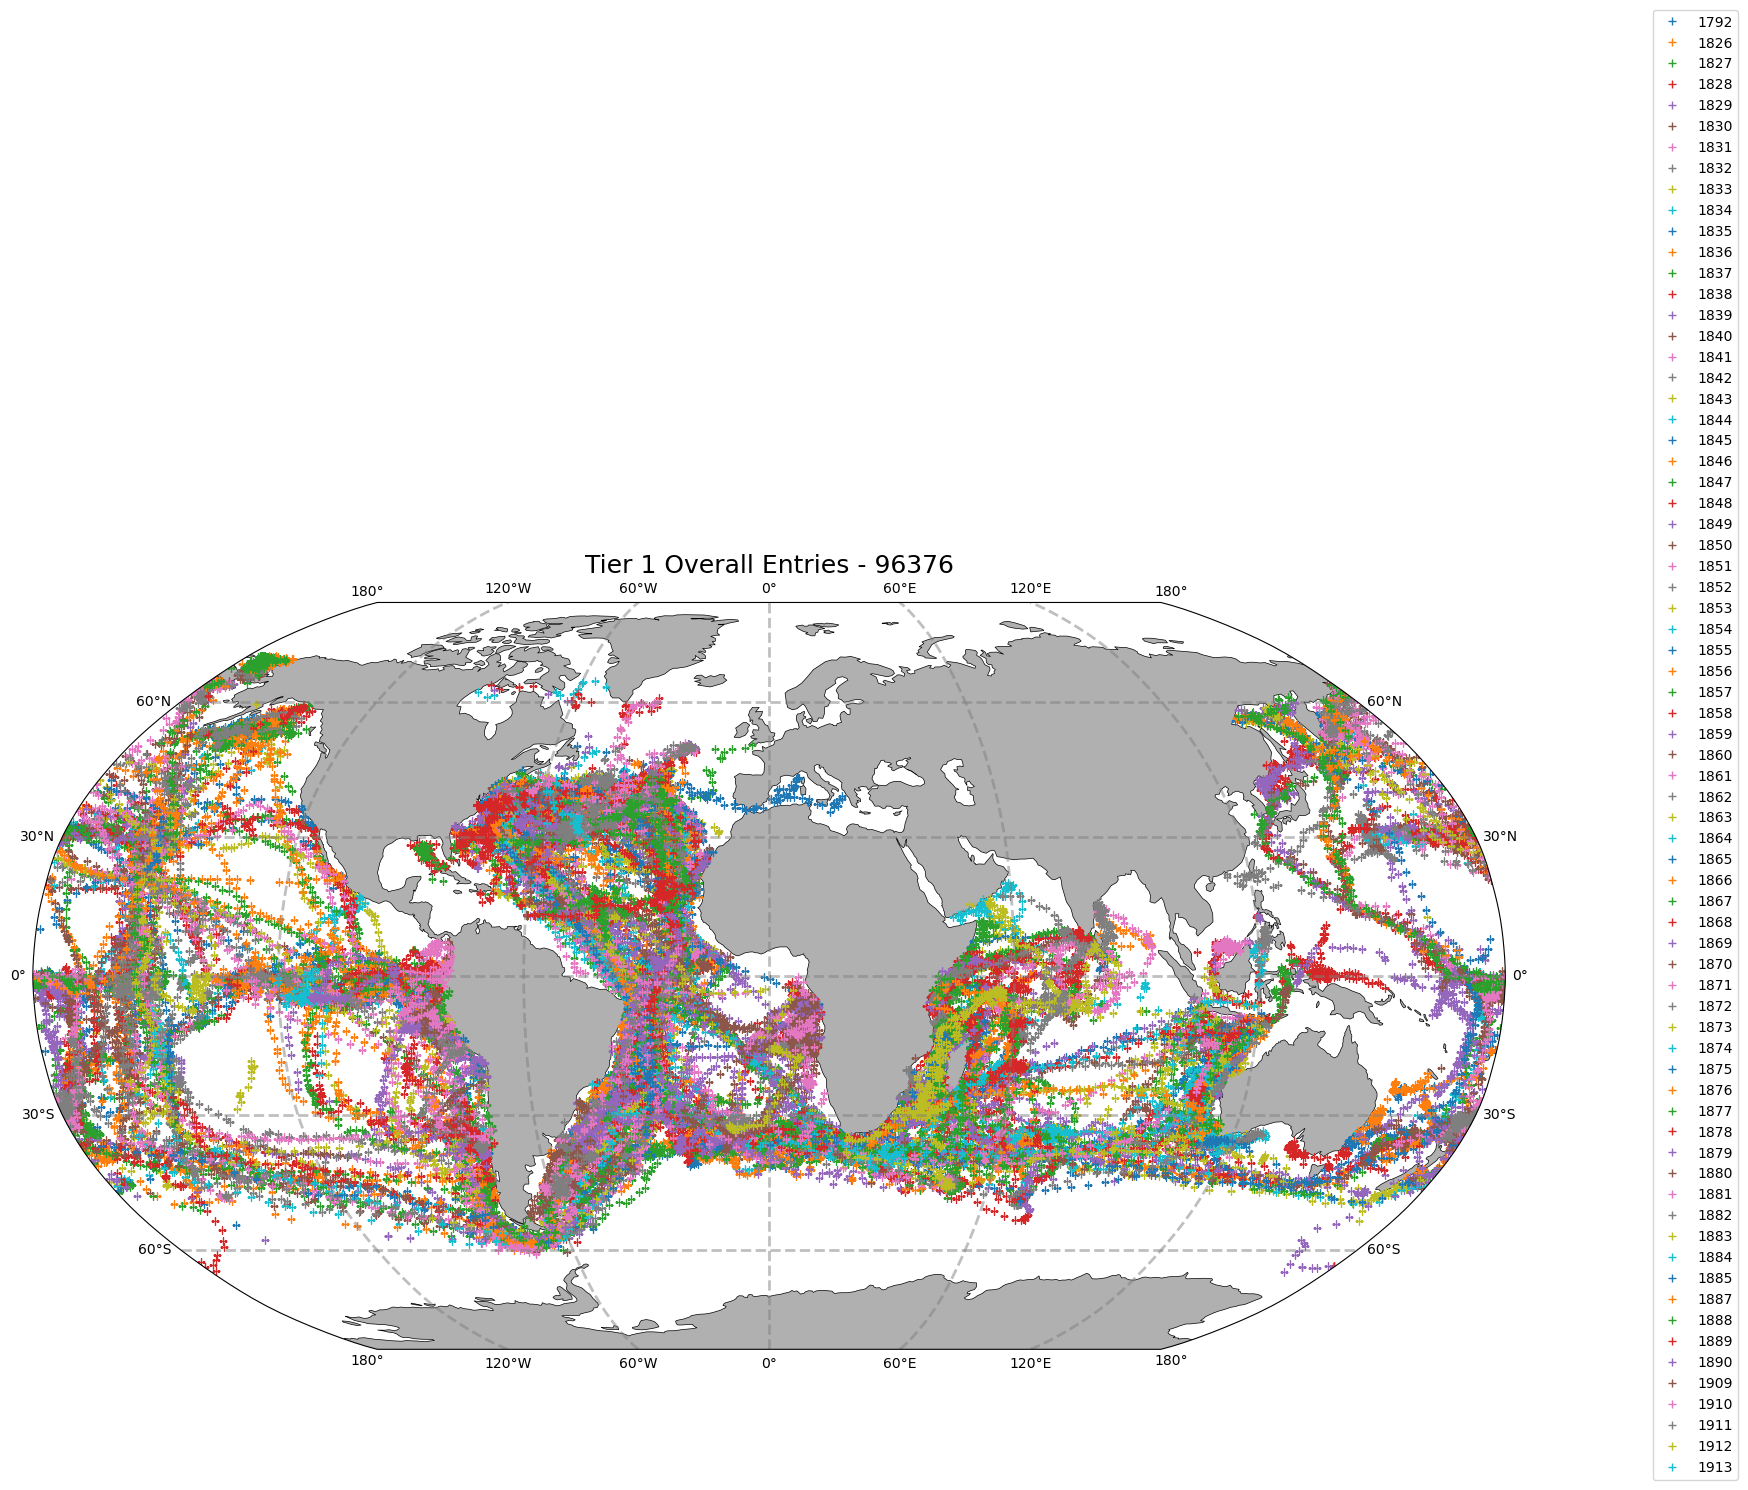

In [101]:
# Plotting all data on a map (any row with a lat and long)

# Set Extent - used when needing to zoom in on a particular area of the plot
#extent = [0, 60, 30, 60]
#[minimum longitude, maximum longitude, minimum latitude, maximum latitude]

#Setting up figure parameters
fig, ax = plt.subplots(figsize=(19,20),subplot_kw={'projection':ccrs.Robinson()})
_ = ax.set_global() # makes figure of whole Earth, comment this line out if only looking at a certain extent
#_ = ax.set_extent(extent, crs=ccrs.PlateCarree()) # used to look only at defined extent of map
_ = ax.coastlines(linewidth=0.5) # Adds black line along coasts of continents
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0') # Adds continent lands and makes them grey
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--') # Adds lat/lon lines

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting the data color coding lat/lon by year 
for yr in sorted(df['Entry Date Time'].dt.year.dropna().unique()):
    work = df[df['Entry Date Time'].dt.year == yr]
    _ = ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    num_plotted_values += len(work)
    #print(yr,': ',np.shape(work))

_ = ax.legend(loc=(1.1,-0.175)) # Adds legend with each year being a different color
plt.title(f'Tier 1 Overall Entries - {num_plotted_values}',fontsize=18) # Adds title

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

# Saving the figures
fig.savefig(os.path.join(Figures, 'Tier1_Clean_up_plot_Jun10.svg'),bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Tier1_Clean_up_plot_Jun10.jpg'),bbox_inches='tight',dpi=300)


Geographic Selection of "strange" entries

In [67]:
df[(df["Latitude"].between(90,100000,inclusive="both")) & (df["Longitude"].between(-180,180,inclusive="both"))]

Empty DataFrame
Columns: [DateTime, ID, LogBook ID, Page, Latitude, Longitude, Depth, Depth Unit, Bottom, Landmark, Ship Heading/Course, Wind Direction, Wind Speed/Force, Sea State, Cloud Cover, Weather, Ship Sightings, Miscellaneous Observations, wind force, Entry Date Time, Direction, Wind Direction Before, coord_diff]
Index: []

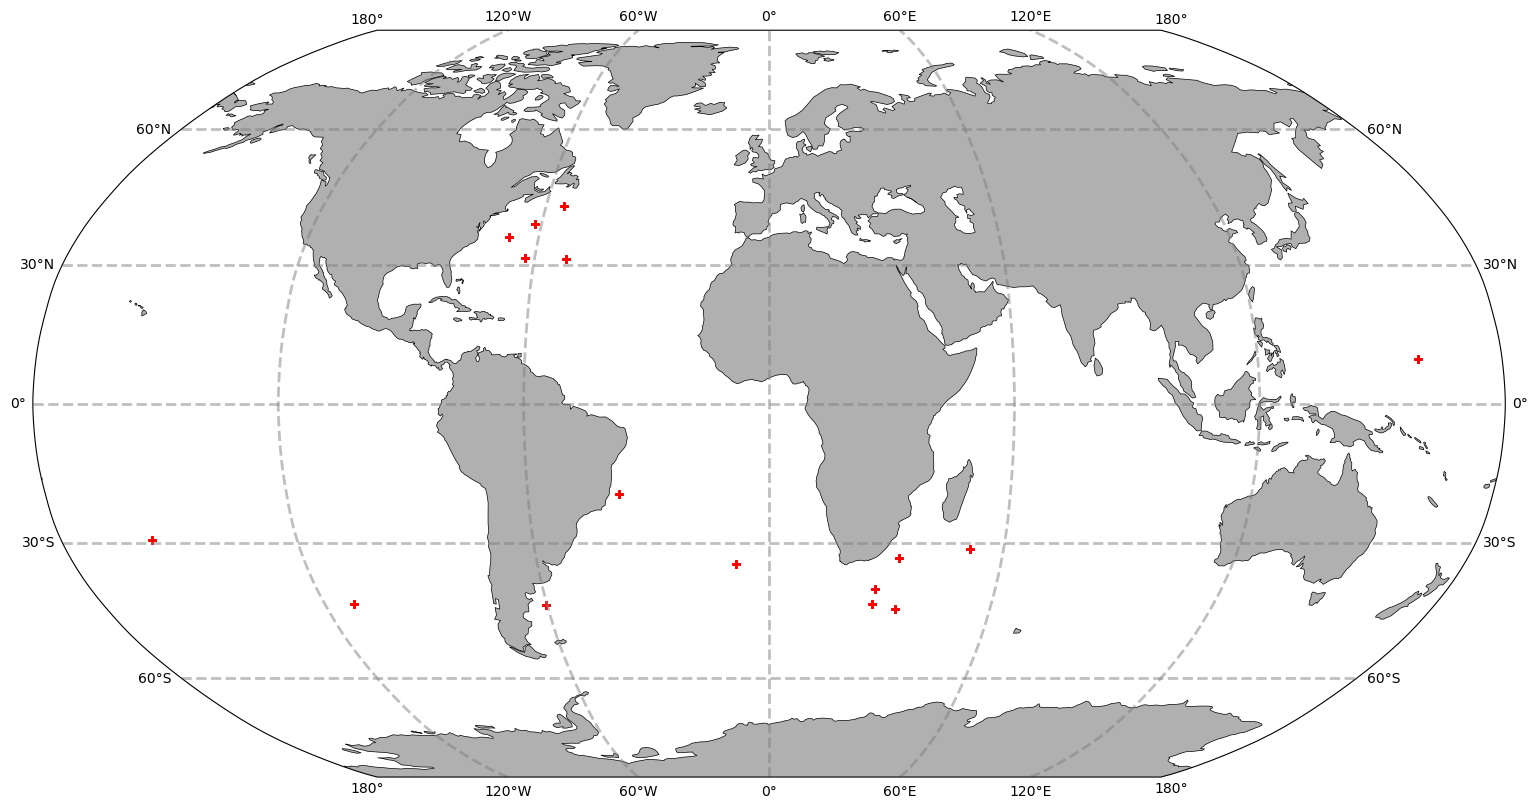

In [68]:
# Plotting Remaining Flagged Data

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19,20),subplot_kw={'projection':ccrs.Robinson()})
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plotting the data
for err in df[df['coord_diff'] == True]:
    work = df.loc[df['coord_diff'] == True]
    _ = ax.plot(work.Longitude, work.Latitude, '+', color='r', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    #print(yr,': ',np.shape(work))

#_ = ax.legend(loc=(1.1,-0.175))

# Saving the figure
# fig.savefig('NA_Unique Years.png',dpi=200)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


Text(0.5, 1.0, 'Entries for Logbook ID: Lancer (Ship) 1865-1868')

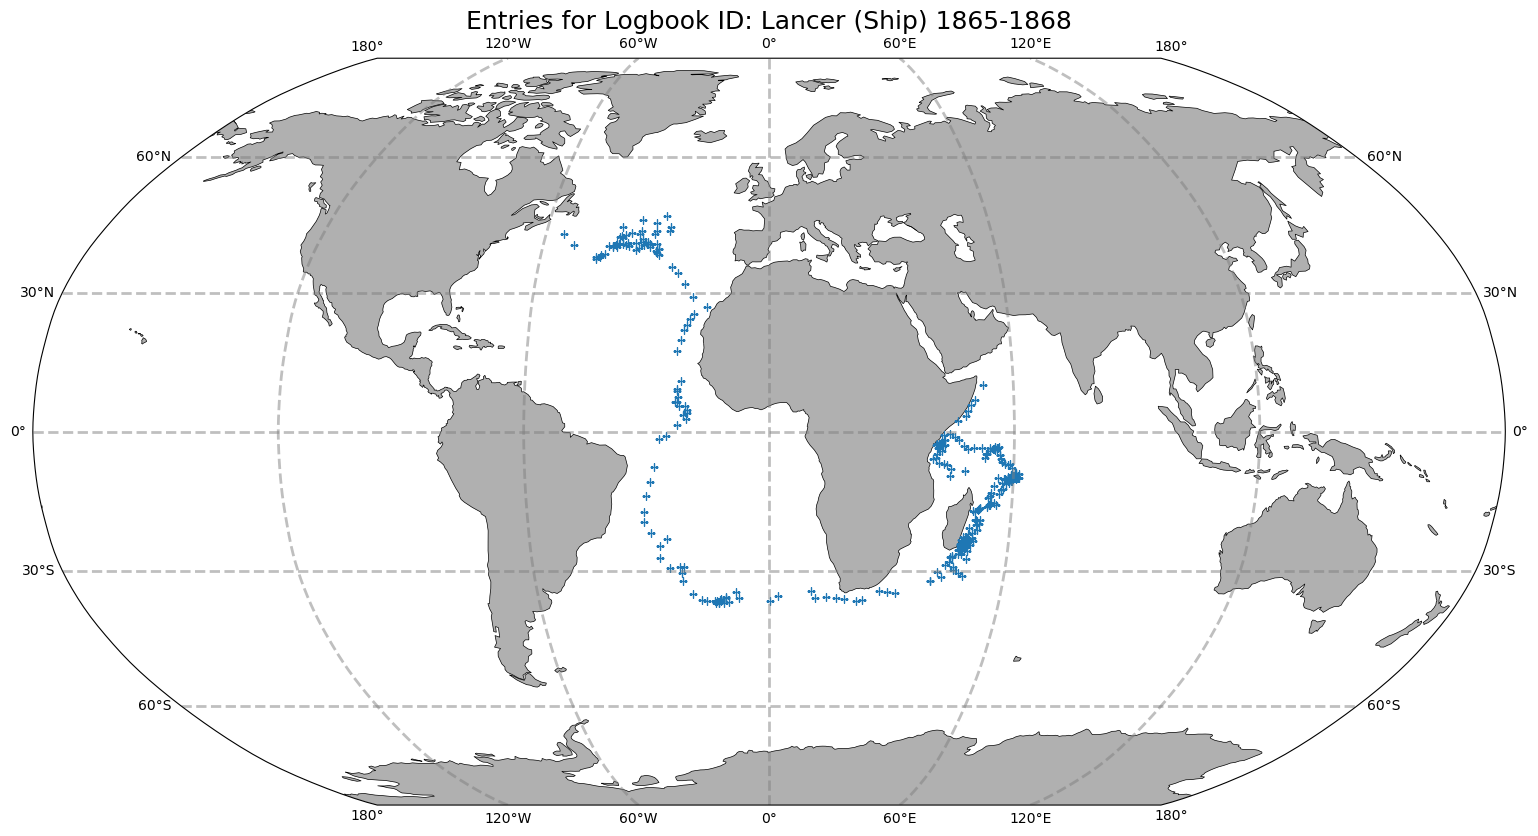

In [69]:
#Trying to find the data that over laps the continents for specific logbooks

# Specify the logbook ID you want to plot
specific_logbook_id = 'Lancer (Ship) 1865-1868'                                                  

# Filter the DataFrame to select rows with the specific logbook ID
specific_logbook_df = df[df['LogBook ID'] == specific_logbook_id]

#Set Extent
#extent = [-100, 0, -45, 60]
#[minimum longitude, maximum longitude, minimum latitude, maximum latitude]

# Create the map 
fig, ax = plt.subplots(figsize=(19, 20), subplot_kw={'projection': ccrs.Robinson()})
_ = ax.set_global()
#_ = ax.set_extent(extent, crs=ccrs.PlateCarree())
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plot the latitude and longitude of the specific logbook
_ = ax.plot(specific_logbook_df['Longitude'], specific_logbook_df['Latitude'], '+',\
            transform=ccrs.PlateCarree(), label=specific_logbook_id)

#_ = ax.legend(loc=(1.1, -0.175))
plt.title(f'Entries for Logbook ID: {specific_logbook_id}', fontsize=18)

#Save the figure if needed
#plt.savefig('Gage_H_Phillips(1878-1880).jpg', dpi=300)


In [70]:
#Finding the logbook ID, ID, and coordinates of flagged data

# Filter the DataFrame based on latitude and longitude ranges 
# Change values depending on what area of the globe you are trying to zoom in on
filtered_df = df[
    (df['Latitude'] >= -40) & (df['Latitude'] <= -38) & 
    (df['Longitude'] >= 175) & (df['Longitude'] <= 180)
]

# Display the filtered DataFrame
print(filtered_df[['LogBook ID', 'ID', 'Latitude', 'Longitude']])


                           LogBook ID       ID   Latitude   Longitude
21351           Nile (ship) 1835-1837  79490.0 -39.250000  178.833333
46384  Mary Mitchell (ship) 1835-1838  53761.0 -39.583333  179.833333
46951  Mary Mitchell (ship) 1835-1838  53185.0 -39.666667  179.050000
46953  Mary Mitchell (ship) 1835-1838  53182.0 -39.533333  179.166667
46954  Mary Mitchell (ship) 1835-1838  53181.0 -39.833333  179.516667
46956  Mary Mitchell (ship) 1835-1838  53179.0 -39.533333  179.200000
61910       Mechanic (Ship) 1846-1851  38072.0 -38.100000  179.033333
61911       Mechanic (Ship) 1846-1851  38071.0 -38.100000  178.583333
61912       Mechanic (Ship) 1846-1851  38070.0 -39.266667  178.750000
61913       Mechanic (Ship) 1846-1851  38069.0 -39.633333  178.550000


1792.0 :  (4, 23)
1826.0 :  (83, 23)
1827.0 :  (348, 23)
1828.0 :  (526, 23)
1829.0 :  (758, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

1830.0 :  (1119, 23)
1831.0 :  (1167, 23)
1832.0 :  (1010, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1833.0 :  (1412, 23)
1834.0 :  (1501, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1835.0 :  (2559, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1836.0 :  (3426, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1837.0 :  (3640, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1838.0 :  (2686, 23)
1839.0 :  (2273, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1840.0 :  (1229, 23)
1841.0 :  (1729, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1842.0 :  (1674, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1843.0 :  (2766, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1844.0 :  (3042, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1845.0 :  (3223, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1846.0 :  (4781, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1847.0 :  (5948, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1848.0 :  (4603, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1849.0 :  (3301, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1850.0 :  (3653, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1851.0 :  (3846, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1852.0 :  (3664, 23)
1853.0 :  (2204, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1854.0 :  (922, 23)
1855.0 :  (572, 23)
1856.0 :  (394, 23)
1857.0 :  (729, 23)
1858.0 :  (812, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

1859.0 :  (531, 23)
1860.0 :  (223, 23)
1861.0 :  (341, 23)
1862.0 :  (337, 23)
1863.0 :  (297, 23)
1864.0 :  (1051, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

1865.0 :  (1969, 23)
1866.0 :  (2054, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1867.0 :  (1776, 23)
1868.0 :  (1042, 23)
1869.0 :  (573, 23)
1870.0 :  (82, 23)
1871.0 :  (357, 23)
1872.0 :  (304, 23)
1873.0 :  (203, 23)
1874.0 :  (318, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

1875.0 :  (214, 23)
1876.0 :  (141, 23)
1877.0 :  (481, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1878.0 :  (2780, 23)
1879.0 :  (3070, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


1880.0 :  (2101, 23)
1881.0 :  (1358, 23)
1882.0 :  (1054, 23)
1883.0 :  (311, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

1884.0 :  (280, 23)
1885.0 :  (276, 23)
1887.0 :  (78, 23)
1888.0 :  (347, 23)
1889.0 :  (319, 23)
1890.0 :  (33, 23)
1909.0 :  (7, 23)
1910.0 :  (8, 23)
1911.0 :  (140, 23)
1912.0 :  (276, 23)
1913.0 :  (40, 23)


/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/tessa.giacoppo/miniconda3/envs/myenv/lib/python3.11/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrin

Text(0.5, 1.0, 'Overall Entries')

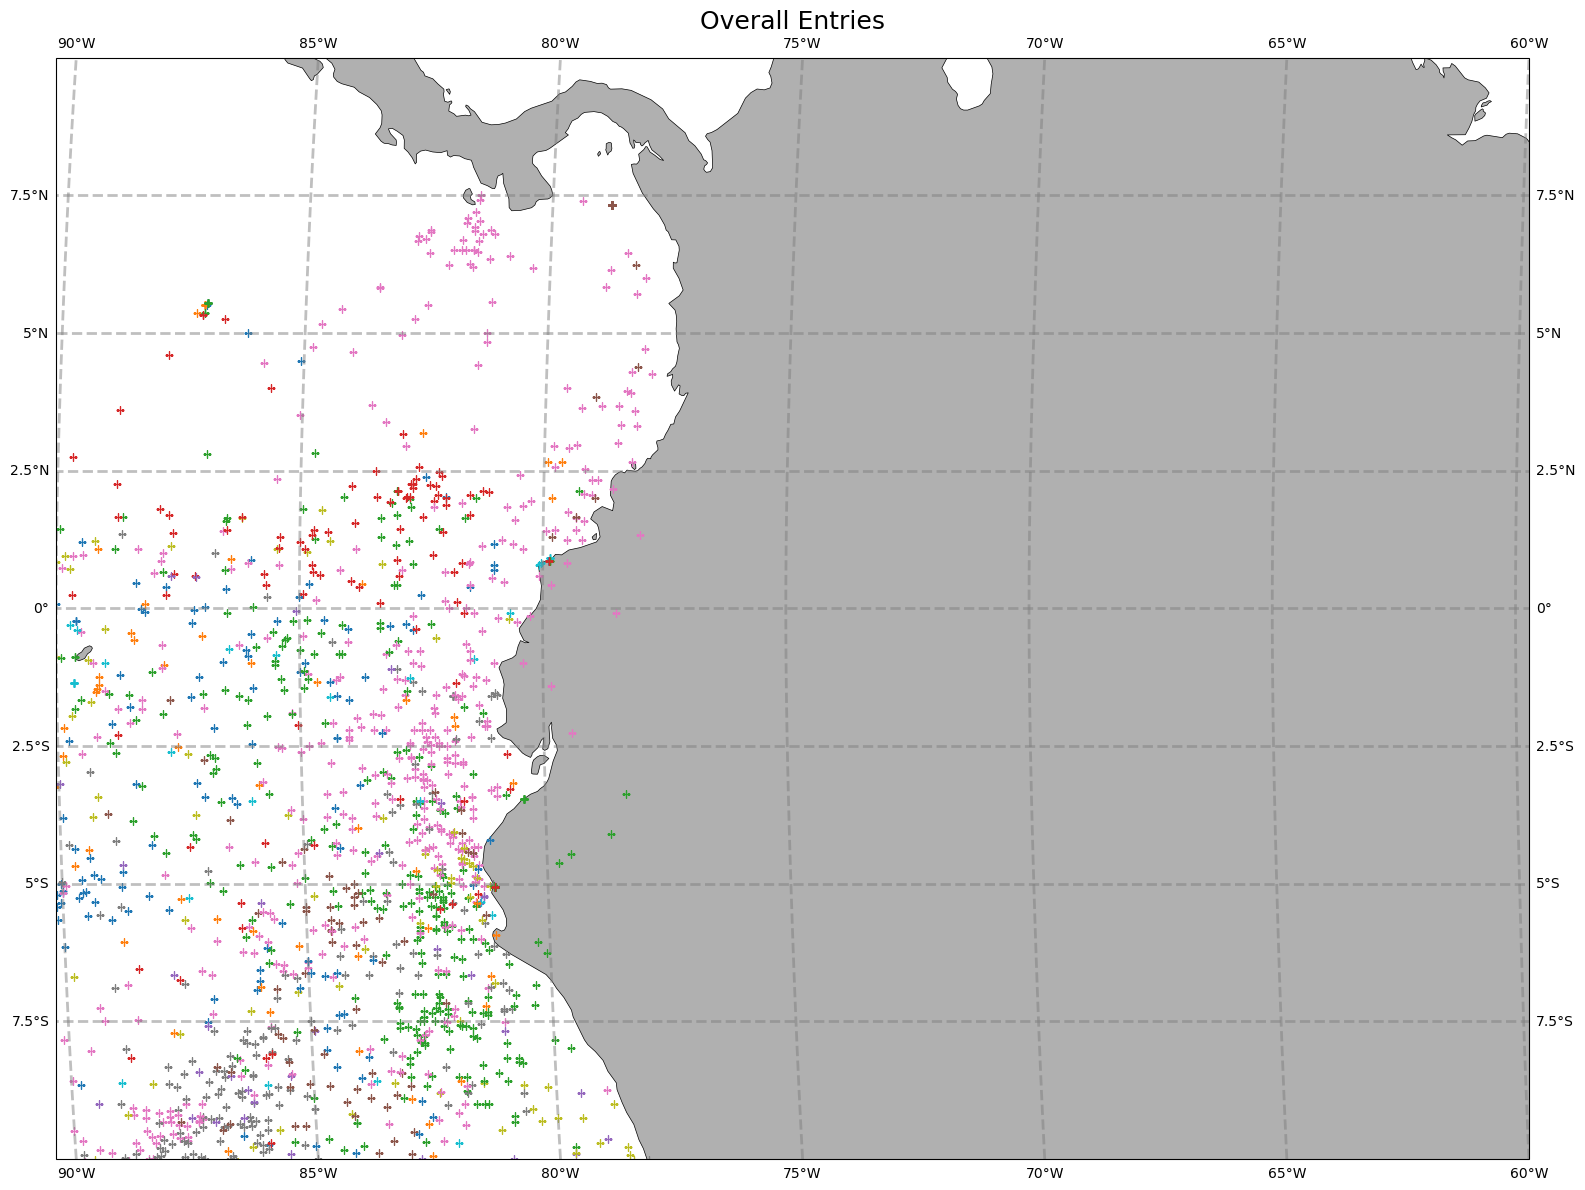

In [71]:
# Plotting all data with extents set to find points over land 
# Or points that look wrong, stand by themself in the global ocean

# Set Extent
extent = [-90, -60, -10, 10]
# extent = [minimum longitude, maximum longitude, minimum latitude, maximum latitude]

# Setting up figure parameters
fig, ax = plt.subplots(figsize=(19,20),subplot_kw={'projection':ccrs.Robinson()})
#_ = ax.set_global()
_ = ax.set_extent(extent, crs=ccrs.PlateCarree())
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plotting the data
for yr in sorted(df['Entry Date Time'].dt.year.dropna().unique()):
    work = df[df['Entry Date Time'].dt.year == yr]
    _ = ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr))
    print(yr,': ',np.shape(work))

#_ = ax.legend(loc=(1.1,-0.175))
plt.title('Overall Entries',fontsize=18)


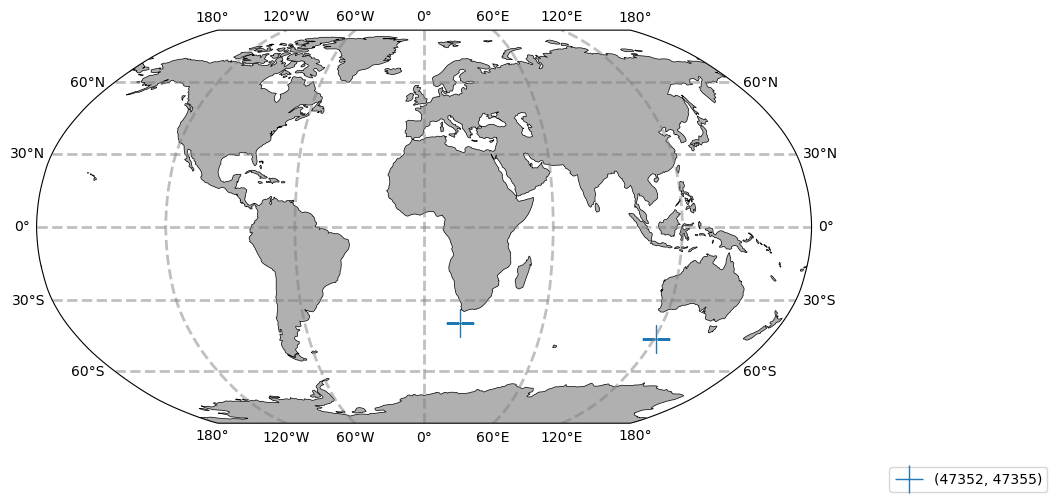

In [72]:
# Trying to find specific ID points that over laps the continents 

# Specify the ID you want to plot
#specific_logbook_ID = (81392, 81394, 81406, 81407, 81408, 81409, 81410, 81411, 81413,\
                       #81415, 81417, 81419, 81421, 81435, 81438)
specific_ID = (47352, 47355)
# Filter the DataFrame to select rows with the specific ID
specific_ID_DF = df[df['ID'].isin(specific_ID)]

# Define the geographic extent for the North Atlantic and Northern Africa
#extent = [-40, 20, -40, 40]  # [lon_min, lon_max, lat_min, lat_max]

# Create the map and plot the selected logbook data
fig, ax = plt.subplots(figsize=(10,15), subplot_kw={'projection': ccrs.Robinson()})
#_ = ax.set_extent(extent, crs=ccrs.PlateCarree())
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Plot the latitude and longitude of the specific IDs
_ = ax.plot(specific_ID_DF['Longitude'], specific_ID_DF['Latitude'], '+', markersize = 20, transform=ccrs.PlateCarree(), label=specific_ID)

_ = ax.legend(loc=(1.1, -0.175))
#plt.title(f'Entries for Logbook ID: {specific_id}', fontsize=18)


In [73]:
# Printing all unique logbook IDs
unique_ws = df['LogBook ID'].dropna().unique()
print(unique_ws)

['Catalpa (bark) 1867-1871' 'Gideon Howland (Ship) 1838-1842'
 'Young Phenix (ship) 1836-1840' 'Lancer (Ship) 1865-1868'
 'Martha (ship) 1836-1838' 'Navy (Ship) 1851-1855'
 'Greyhound (Bark) 1851-1853' 'Timoleon (Ship) 1835-1839'
 'Louvre (Ship) 1842' 'Ann (Ship) 1841' 'Octavia (Bark) 1837-1839'
 'Draco (Bark) 1851-1854' 'Chariot (Ship) 1838-1840'
 'Statira (Ship) 1839-1843' 'Courser (Bark) 1865-1869'
 'William Wirt (Ship) 1850-1853' 'John (ship) 1836-1838'
 'Brandt (Ship) 1838-1839' 'Gideon Howland (ship) 1836-1838'
 'Orion (Brig) 1837' 'Walter Irving (Schooner) 1852-1853'
 'Ocean (Bark) 1879-1882' 'Walter Irving (Schooner) 1856-1857'
 'George (ship) 1836-1837' 'Walter Irving (Schooner) 1855-1856'
 'Walter Irving (Schooner) 1855' 'General Jackson (ship) 1836-1839' 4.5 10
 'Walter Irving (Schooner) 1854-1855' 'Walter Irving (Schooner) 1853-1854'
 'Ocean (Bark) 1878' 'Isabella (Brig) 1878-1879' 'Beaver (Ship) 1840-1842'
 'Walter Irving (Schooner) 1851' 'Walter Irving (Schooner) 1850'
 '

### Unique Values

In [75]:
# Print unique vales for wind direction, wind speed, sea state, cloud cover, weather
for col in ['Wind Direction', 'Wind Speed/Force', 'Sea State', 'Cloud Cover', 'Weather']:
    print(col+':')
    vallist = df[col].dropna().unique()
    vallist.sort()
    print(vallist, '\n \n')

Wind Direction:
[0.0 11.25 22.5 30.0 33.75 37.5 45.0 52.5 56.25 60.0 67.5 75.0 78.75 90.0
 101.25 105.0 112.5 120.0 123.75 135.0 142.5 146.25 150.0 157.5 165.0
 168.75 180.0 191.25 202.5 210.0 213.75 225.0 236.25 240.0 247.5 255.0
 258.75 270.0 281.25 285.0 292.5 300.0 303.75 315.0 326.25 330.0 337.5
 348.75] 
 

Wind Speed/Force:
['"all kinds"' '"baffling winds"' '"blowing hard"' '"breeze"'
 '"breezed on"' '"continual gales"' '"dead calm"' '"fine breeze"'
 '"fine hole sail breeze"' '"fine hole sail breeze"s'
 '"fine hole sail breezes"' '"gale more moderate"' '"head winds"'
 '"light and []* wind"' '"light easterly winds"'
 '"moderate at day light wind freshened"' '"moderate gale"'
 '"moderate trades"' '"moderate visible winds"' '"moderate wind"'
 '"moderate winds"' '"moderate"' '"more moderate"'
 '"sometimes calm and at others blowing a gale"' '"strong trades"'
 '"the wind"' '"the winds"' '"under short sail"'
 '"verible winds and calms"' '"verible" winds' '"whole sail breeze"'
 '"wind 

In [76]:
# Printing unique wind force terms 
unique_ws = df['Wind Speed/Force'].dropna().unique()
print('Unique wind force terms: ',np.size(df["Wind Speed/Force"].unique()))
print(unique_ws)

Unique wind force terms:  1263
['strong gale' 'strong winds' 'light winds' 'calm' 'light breezes'
 'very light' 'about calm' 'moderate winds' 'strong breezes' 'smart gale'
 'gale' 'fine trade' 'strong trade' 'strong trades' 'small breezes'
 'strong gales' 'squalls' 'squally' 'strong' 'blowing a very heavy gale'
 'heavy gale' 'heavy gales' 'fresh gales' 'winds' 'moderate breezes'
 'fine breezes' 'fresh gales & squally' 'fine winds' 'light airs' 'calms'
 'pleasant breezes' 'fresh winds' 'light and variable airs'
 'very light airs' 'very light breezes' 'fresh breezes'
 'heavy gales & very heavy squalls' 'very heavy gales' 'gentle breezes'
 '"winds" & squally' 'fine trades' 'light' 'light gales'
 'quite strong gales' 'quite strong breezes' 'hard squalls'
 'moderate gales' 'about gale' 'breezes' 'handsome breezes' 'light trades'
 'moderate trades' 'trades' 'strong squalls' '"all kinds"'
 'very light trades' 'fresh trades' 'fresh breezes & squally'
 'heavy winds' 'light and variable breezes'

Mapping unique 'Wind Speed/Force' values onto Beaufort Scale values (0-12)

In [77]:
# Taking all unique wind force terms and classifying them 0-12
# Old classification of wind terms done by Bastian

unique_ws_0 = ['calm','calm and baffling','calm & baffling','calms','wind died away, shifted suddenly','calm no winds','pretty much calm','dead flat',\
              'flat calm','"dead calm"','calm winds','calmes','died away','lulls','lulled','calmy','calm,','no winds','dead calm','not much winds',\
              'wind out','calm or nearly so','variable & calm','calms by spells','"Under short sail"','calm nearly','too calm','Calm wind',\
              'no wind','not much wind','calm breeze','calm & bafling','Calm No Wind','fine calms','about calm','Calm No Wind','Calm No Wind', 'squally & calms']
unique_ws_01 = ['light airs & calms','light airs & calm','light winds & calms','light variable winds & calms','light airs, with calms',\
                'light variable winds and calms','light airs and calms','light airs with calms','light airs/calms','calm and light winds',\
                'light winds and calms','calms & light airs','little or no winds','light wind and calms','light winds with calms','almost a calm',\
                'nearly a calm','nearly calm','light airs, calm','light airs, calms','light baffling airs and calm','light variable & calms',\
                'light and calm airs','light airs and calm','light breezes and calms','light baffling airs and calms','baffling airs and calms',\
                'light and calm breezes','airs and calms','light calm winds','high airs and calms','light air & calm','light to no winds','light & calm',\
               'light & calms','light breezes & calms','calms & light breezes','calms & light variable breezes','light winds & variable with calms',\
               'light airs & calms & baffling','baffling & calms','calms & transient breezes', 'calms & light variable airs','calm and then light breezes',\
               'light & variable & calms','light air inclining to calm','light airs inclining to calm','light airs inclining to calms','variable breezes and calms',\
               'light baffling & calms','light airs and clams','calm with light variables','calms with light variables','light airs inclined to calm',\
               'light airs inclines to calm','calm & baffling with now & then breezes','very faint airs','almost calm','light variable airs and calms',\
               'baffling & calm','light airs variable & calms','light next to calm','calms with some light airs','light variable breezes and calms',\
               'light breezes & calm','calm or very light breezes','calm & light breezes','light air & calms','very light & baffling','very light baffling',\
               'calm and variable winds','variable winds and calms','very light air & baffling','light breezes & calms by spells','light baffling & calm',\
               'light variable airs & calms','Fine Calms','variable airs calm','variable airs calms','light airs & clams','variable airs & calms',\
               'light variable air & calms','light airs calms','calms & squally','calm & baffling with now & then breeze','little or no wind',\
               'very light wind','Light and calm wind','light to no wind','Little or no wind','Calm & Light Bafling Winds','Light Bafling Winds & Calms',\
               'Calm, light bafling breezes','light and bafling with a good part calm','light bafling winds and calm','light and bafling with calms',\
               'light bafling winds and calms','light bafling airs and calm','Light aires, with calms','Calm and Light Wind','Light and Baffling Airs and Calms',\
               'Variable Airs and Calms','Light and Variable Calms','calms & light baffling airs','light baffling airs & calms','Calm wind','Light and calm wind','Calm & Light Bafling Winds',\
               'Light Bafling Winds & Calms','Calm, light bafling breezes','Light aires, with calms','Calm and Light Wind','Light and Baffling Airs and Calms',\
               'Variable Airs and Calms','Light and Variable Calms','Light and Variable Winds and Calms','Calm wind','"Verible winds and calms"','Light and calm wind',\
               'Calm & Light Bafling Winds','Light Bafling Winds & Calms','Calm, light bafling breezes','Light aires, with calms','Calm and Light Wind','light and variable calms',\
               'light and variable winds and calms','"verible winds and calms"', 'light calms', 'living calms', 'dead calms']
unique_ws_1 = ['light airs and variable','light baffling airs','light baffling','light airs and very baffling','airs','very light air','light airs',\
              'light air','light airs from land','light airs variable','light airs & baffling','pleasant light air','very light airs',\
               'light air & baffling','light airs, variables','calm, light breezes','calm breezes','calm & light baffling winds','light baffling winds & calms',\
              'calm, light baffling breezes','light and baffling with a good part calm','light baffling winds and calm','light and baffling with calms',\
               'light baffling winds and calms','light wind with calms','light variable airs','light airs & variable','light wind and calm',\
              'light varibale','more light','light land & sea breezes','light airs & changeable','light winds and then calm','light (winds), calm',\
              'very light winds','very light trade winds','light trades and calms','light airs of winds','light air of winds','light airs and squally','light airs and baffling',\
              'light breezes & baffling','faint airs','light winds & calm','light winds calms','light trades & calms','light variable winds & calm',\
              'calm with light winds at intervals','light trades & calms','flairs of wind and calms','calms light winds','light winds and calm','Very light breeze',\
              'Short interval light breezes','Occasional light airs','Light Breeze & Easing','light airs & clear','very light breeze','Very Light Wind',\
              'little wind','very light trade wind','Light Airs of Wind','light air of wind','light airs of wind','Light Bafling Breezes',\
              'light bafling airs','light and bafling','light bafling','Light aires','little breezes','short interval light breezes','occasional light airs',\
              'Light and Variable Winds and Calms','Light and Variable Airs','Light and Pleasant','light & baffling airs','Light aires','Light and Variable Airs','Light Airs and Squalls of Wind',\
              'Light aires','variable airs and calms','light and variable airs', 'gentle airs', 'light and calms', 'light breezes & calmz', 'calm with frequent light airs',\
              'light airs to light breezes', 'light airs & squalls of winds', 'light airs and calms and then a light breezes', 'light airs & calms & squalls of winds']
unique_ws_2 = ['light winds','light','light baffling winds','small winds','small breezes','light variable winds','light winds & variable',\
               'light winds and variable','light sea breezes','light trades','light breezes and baffling','light breeze and baffling',\
               'wind light and baffling','light and baffling winds','light winds & baffling','light breezes','light breeze from bay',\
               'light breezes and baffling','baffling','light variable','light & variable','very light & pleasant','very light breezes','very light',\
               'light & baffling','light, variable','llight, variable','light baffling breezes','light land breezes','light and variable',\
               'light and baffling','light wind variable','light land and sea breezes','light wind & flowy','blowy & baffling','baffling and light',\
               'baffling and flowy winds','light  breezes','light breeze & baffling','light breezes and variables','light breezes & variable',\
              'light (winds)','baffling winds','"light and []* wind"','light and calm winds','light (wind)','light trade winds','light and pleasant breezes',\
              'lights winds','light traids','light wind and variables','light wind and variable with calms','light wind and variable','breeze light',\
              'light (breezes)','light variable breezes', '"light easterly winds"','light trade','light &variable','light baffling trades','light pleasant breezes',\
              'light brezes','light breezes & squally','light trade wind with frequent squalls','light windss with frequent squalls of winds',\
              'light winds & squally','light breeze & squally','lighter winds','light squalls of winds','light winds and variables','pleasant light breezes',\
              'light and gentle breezes','light breezes and squally','light unsteady winds','feather winds','light breeze and squalls','light very unsteady breezes',\
              'soft winds','light winds and baffling','light variables','light steady winds','light & baffling winds','lightv breezes','light baffling & variable',\
              'steady & light','(light) breezes','steady & light','light steady','light head winds','6 knot breezes','5 knot breezes','light & somewhat baffling',\
              'moderate winds & calms','little winds','light and pleasant variables','calm and moderate','light flattening breezes','Light Breeze','Light Winds and Very Baffling',\
              'light breeze','Light Wind','Light breeze','Little breeze','Light wind','light wind','light trade breeze','light breeze & freshene',\
              'light breeze & freshening','light breeze & freshens','light airs & squalls','light land breeze','Light Sea Breeze','6 knot breeze',\
              '5 knot breeze','light trade wind','light winds with frequent squalls of wind','light squalls of wind','gentle wind','Soft Wind',\
              'Light Baffling Wind','Light Variable Wind','Light Baffling Breeze','LIght Breeze','Light breeeze','Light  breeze','light sea breeze',\
              'Light Bafling Winds','Light Bafling','light variable wind','small wind','light baflin winds','light bafflin','Light and blaffling winds',\
              'Light light winds','Small Wind','light winds and very baffling','"under short sail"','light trade breezes','light breeze & easing','Light Pleasant Breeze',\
              'Light and Pleasant Breeze','Light and Variable Winds','slight breeze','very light wind & squally','Light Breezes and Very Baffling','Light and Baffling Breezes',\
              'light winds & variable winds','Light Airs and Squalls of Wind','Soft wind','Light and steady breezes','"Verible winds and calms"','Little breeze','Soft Wind',\
              'Light Baffling Wind','Light breeeze','Light Baffling Breeze','Light  breeze','Light Bafling Winds','Light Bafling Breezes','Light and blaffling winds','Light light winds',\
              'Light Pleasant Breeze','Light and Pleasant Breeze','Light and Variable Winds','Light and Pleasant','Light Breezes and Very Baffling','Light and Baffling Breezes',\
              'Soft wind','Light and steady breezes','Little breeze','Soft Wind','Light Baffling Wind','Light Baffling Breeze','Light breeeze','Light  breeze','Light Bafling Winds',\
              'Light Bafling Breezes','Light and blaffling winds','Light light winds','light and baffling airs and calms','light and variable winds','slight breezes',\
              'light breezes and very baffling','light and baffling breezes','light airs and squalls of winds','light and steady breezes', 'light and changeable winds',\
              'light breezes to fair winds', 'light breezes with frequent calms', 'light winds & squalls', 'light to fine breezes', 'light baffling winds`',\
              'light winds & strong squalls']
unique_ws_23 = ['pleasant breezes','pleasant winds','more pleasant','pleasant','nice & pleasant','nice breezes','very pleasant','nice',\
                'pleasant baffling','pleasant (breezes)','pleasant trades','pleasant breezes & various','more pleasant breezes','pleasant trade winds',\
               'pleasant sea breezes','light pleasant trades','moderate trades & calms','light breezes & calm & squally','calm & light squalls','7 knot breezes',\
               'very pleasant winds','strong calm','pleasant breeze','steady breeze','pleasnat breezes','pleasant sea breeze','7 knot breeze',\
               'Very Pleasant Wind','light topgallant breeze','Pleasant light breeze','more pleasant breeze','Pleasant Wind','Pleasant Breeze','light winds with squalls',\
               'light breezes with squalls of wind','Light breeze to Fresh','Quick, light','Very Pleasant Wind','Pleasant light breeze','Pleasant Wind','Light breeze to Fresh',\
               'Quick, light','Very Pleasant Wind','Pleasant light breeze','Pleasant Wind','light and pleasant','light breezes with squalls of winds','light breeze to fresh',\
               'quick, light', 'brisk winds, light winds & squally']
unique_ws_3 = ['gentle winds','gentle','gentle breezes','3','fine winds and light','gentle breezes & variable','gentle trades','light topgallant breezes','light and fresh',\
              'gentle & variable','fine light breezes','light and fresh breezes','moderate breezes and calms','moderate trades and calms','light winds calms & heavy squalls',\
              'fresh gales & calms','nice steady breezes','nice breeze & baffling','nice breeze baffling','smooth breezes','baffling & freshening',\
              'nice working breezes','squally light winds','fine and pleasant','frequent & light squalls','Good breeze','nice steady breeze',\
              'Gentle Wind','Gentle wind','moderate & light', 'gentle breezes & calms', 'gentle sea breezes', 'light moderate breezes', 'light moderate winds',\
              'gentle breezes and strong', 'light & brisk winds']
unique_ws_4 = ['moderate winds','moderate breezes','moderate','good breezes','moderate winds & variable','moderate winds between squalls','moderate baffling winds',\
               'moderate and baffling winds','more moderate','wind moderated a little','moderate trades','wind continued and moderated a little',\
               'moderate trade winds','moderate winds & baffling','"more moderate"','"moderate"','moderate baffling','moderating','moderating breezes',\
               'quite moderate','moderates','a little more moderate','moderate variable','moderate increasing winds','moderate wind variable',\
              'fine winds and gentle','moderate whole sail breezes','good wholesale breezes','moderate & variable','moderate breezes & variable',\
              'moderate airs','"moderate trades"','moderated between squalls','moderated','"moderate wind"','"moderate visible winds"','"moderate winds"',\
              'moderate (winds)','moderate wind light and baffling','moderarte breezes','modest winds','moderate wind and squally','more moderate winds',\
              'inclining to moderate','mor moderate','more modest','moderate  breezes','"moderate at day light wind freshened"','good','whole sail breezes',\
              'whole sail','moderate breeze & squally','moderate breezes with light squalls','moderate winds & squally','moderate trade winds with frequent squalls of wind',\
              'moderate trades & squally','moderate trade','good breeze with frequent squalls of winds','moderate traes','very steady moderate breezes',\
              'modertae trades','moderatre','more moderate trades','moderate trade winds with frequent squalls of winds','very moderate breezes','very moderate trades',\
              'fair trades','moderate baffling breezes','moderate breezea','light winds heavy squalls','calms & squalls','heavy squalls & calms',\
              'calms heavy squalls','calms squalls','squalls calms','light winds heavy squalls & calms','heavy squalls calms','moderate variable breezes',\
              'moderate variable winds','fresh gales & calms','moderate and rainy','fresh gales calm','moderate btreezes','moderate variable winds',\
              '"sometimes calm and at others blowing a gale"','light breeze & squalls','very moderate & pleasant winds','moderates breezes',\
              'moderate but rough','moderate breeze & baffling','strong and light winds','light and strong winds','Moderate Breeze','Moderate breeze',\
              'Moderate wind','Moderate Wind','moderate breezesQENE','moderate breeze','moderate breezes but variable','moderate breeze & freshened',\
              'moderate breeze & pleasant','moderate wind','moderate winds with some squalls of wind','nice all sail breeze','good all sail breeze',\
              'moderating breeze','very moderate & pleasant wind','moderates breeze','topgallant breeze','middling strong topgallant breeze',\
              'moderate trade wind','moderate trade wind with frequent squalls of wind','very steady moderate breeze','Moderate  breeze',\
              'Fair Wind','moderarte breeze','modest wind','More Moderate Wind','moderate increasing wind','fair breeze','Moderate whole sail breeze',\
              'Moderate Breezs','Moderate Winds & "Baffling"','mild wholesail breezes','moderate breezesqene','modertae winds','Moderate and Baffling Breezes',\
              'Very moderate','moderate all sail breeze','moderate moderate breeze','somewhat moderate','moderate with some strong gusts','very moderate winds',\
              'very moderate','passing squalls','squally by spells','"wind" & squally by spells','Fair Trade','Mild wholesail breeze','Moderate  breeze',\
              'More Moderate Wind','Moderate whole sail breeze','Moderate Breezs','Moderate Winds & "Baffling"','Moderate and Baffling Breezes','Moderate  breeze',\
              'More Moderate Win','Moderate whole sail breeze','Moderate Breezs','Moderate Winds & "Baffling"','moderate and baffling breezes','moderate all sail breezes',\
              'moderate moderate breezes', 'moderate breeze to gale', 'fine light trades', 'light variable trades', 'moderate  to briskbreezes']
unique_ws_45 = ['fine winds','fine breezes','fine, moderate winds','fine, moderate breezes','fine','fine light winds','fine trades','very fine winds',\
                'very fine breezes','fine fresh breezes','fine moderate breezes','fine sea breezes','fine breezes & rugged','fine pleasant','fine trade winds',\
               'fine pleasant trades','fine land & sea breezes','fine trade','topgallant breezes','rugged winds','fine leading breezes','fine trade breezes',\
               'fine baffling breezes','fine whole sail breezes','"fine hole sail breeze"s','"fine hole sail breeze"','"fine hole sail breezes"','"fine breeze"',\
               'fine pleasant (breezes)','moderate gales calms','moderate trades with some squalls','moderate windss with some squalls of winds',\
               'fine pleasant winds','winds & squally','nice all sail breezes','handsome breezes','fine pleasant trade winds','fine breezes and calms',\
               'good all sail breezes','nice all sail breeze & baffling','fine breeze','Fine wind','Nice breeze','Fine breeze','Mild wholesail breeze',
               'Fine Breeze','fine trade breeze','fine breeze & squally by spells','fine pleasant breeze','good breeze','fine wind','nice breeze',\
               'Handsome Breeze','nice working breeze','Good Breeze','Fine Wind','good breeze with frequent squalls of wind','fine leading breeze',\
               'fine trade wind','Fine Trade Breeze','Buffed by the Wind','Buffed by the wind','fine sea breeze','Good Wholesale Breeze',\
               'Fine widns','Fne Wind','Very Fine Wind','Very fine breeze','Fresh to moderate wind','Fresh breeze to moderate','Good Winds','Good Wind',\
               'Good Trades','all sail breeze','fine breeze & some squally by spells','fine breeze & some squally','Fine Breezes and Baffling','Handsome Breeze',\
               'Fine whole sail breeze','Fair Wind','Good Wholesale Breeze','Fine widns','Fne Wind','Very Fine Wind','Very fine breeze','Wholesale Breeze',\
               'Fresh to moderate wind','Fresh breeze to moderate','Good Winds','Good Wind','Good Trades','Fine Breezes and Baffling','Fair Trade','Wholesail breeze',\
               'Mild wholesail breeze','Handsome Breeze','Fine whole sail breeze','Fair Wind','Good Wholesale Breeze','Fine widns','Fne Wind','Very Fine Wind','Very fine breeze',\
               'wholesale breezes','fresh to moderate winds','fresh breeze to moderate','good winds','good trades','all sail breezes','fine breezes and baffling','fair trade']
unique_ws_5 = ['fresh winds','fresh land breezes','fresh trades','fresh','blowing fresh','blows fresh','fresh breezes','freshening','fresh variable',\
              'fresh steady breezes','fresh baffling','freshening breezes','fresh baffling breezes','fresh breezes & baffling','very fresh breezes',\
              'fresh trade','fresh sea breezes','fresh light breezes','fresh trade winds','fresh breeze and baffling','blowed fresh','fresh  breezes',\
              'fresh breezes & variable','breezes fresh & variable','fresh but steady','"wind freshened"','freshens','fresh breezes & changeable',\
              'fresh breeze & baffling','fresh airs','fresh breezes & squally','blew fresh','fresh winds & squally','fresh breeze & squally',\
              'steady breeze & howling','fresh trade breezes','fresh winds & squally','fresh trades and squally','fresh breezes baffling and flowy',\
              'fresh winds and squally','fresh breezes & flawy','fresh increasing winds','breeze fresh','quite fresh','blowing  fresh','fresh breezes & good winds',\
              'fresh & variable','moderate breezes & squally','fresh breezes variable','fresh breezers','very fresh trades','quick breezes',\
              'fresh ne trade winds','quick breezes & squally','Fresh Breeze','Running winds','fresh breeze','Fresh breeze','stiff breeze','Fresh breeze and squally',\
              'Fresh Wind','fresh breezes & squalls','fresh trade wind','fresh sea breeze','fresh breeze with squalls of wind','fresh breeze/squalls of wind',\
              'freshening breeze','fresh wind','strong but moderating breeze','Fresh  breeze','Fresh Trade Breeze','Fresh wind','fresh steady breeze',\
              'fresh baffling breeze','very fresh breeze','Fresh land breeze','fresh breeze and squally','Fresh Variable Breezes','Fresh and Baffling Breezes','Quick breeze',\
              'fresh & squally','fresh trades & squally','Fresh Variable Winds','fresh trades, squall','fresh breeezs','Fresh sail','fresh  breeze','Fresh Trade / Baffling',\
              'Fresh  breeze','Fresh Trade Breeze','Fresh land breeze','Fresh Variable Breezes','Fresh and Baffling Breezes','Fresh Variable Winds','fresh trades, squalls',\
              'Fresh sail','Fresh Trade / Baffling','Fresh Trade Breeze','Fresh land breeze','fresh variable breezes','fresh and baffling breezes','fresh variable winds',\
              'fresh sail','fresh trade / baffling', 'briak winds', 'strong to moderate breezes', 'fresh to moderate breezes', 'brisk breze', 'brisk wind & squally',\
              'brisk variable winds', 'good fresh breezes', 'fine steady breezes', 'fresh breezes to strong winds', 'fine breezes & squally']
unique_ws_56 = ['breezesd up to brisk breezes','moderate with squalls','fresh passing squalls','fresh squalls','light squalls','light squalls & baffling',\
               'a little squally','a few squalls','strong fresh breezes','fresh strong breezes','fresh breezes with passing squalls','fresh breeze with squalls of winds',\
               'fresh breeze/squalls of winds','some light squalls','some heavy winds','strong but moderating breezes','fresh breezes & strong squalls','fresh breezes with squalls',\
               'fresh breezes & squalls of wind','Buffed by the Wind','Buffed by the wind','Buffed by the Wind','Buffed by the wind','fresh breezes & squalls of winds',\
               'strong to fresh breezes']
unique_ws_6 = ['strong winds','brisk winds','brisk breezes','strong winds & variable','strong south','strong wind, heavy squall with a tempest',\
              'strong squall','squall winds','strong trades','strong blows','strong trade','strong winds and breezes','brisk trade',\
              'strong wind under double reefed top sails','heavy winds','squalls','strong trade winds','brisk trades','heavy breezes','high winds',\
              'strong squalls','strong airs','very strong winds','blowing hard','blows strong','blowing strong','strong breeze and squally winds',\
              'strong breezes','strong','squally','strong land breezes','strong sea breezes','heavy','blowing very heavy','very strong','blowing very hard',\
              'stiff breezes','blowing on in squalls','strong baffling','quite heavy squalls','blowing up heavy in squalls','blowing heavy',\
              'squall','raging & squally','blows hard in squalls','very strong breezes','strong heavy breezes','very heavy','hard','hard in squalls',\
              'blowing strongly','strong varianble winds','blows heavy','strong squalls of winds','breeze heavy','strong in squalls','strong flows',\
               'hard squalls of wind & rain','strong breeze & rugged','brisk breeze & breezing on','squally winds','heavy squall',\
               'brisk with a little variation','brisk & variable','severe','"blowing hard"','"strong trades"','strong breezes & variable','brisk',\
               'strong & variable','heavy squals','big winds','very strong trades','strong (winds)','strong winds and squally','brisk trade winds',\
              'very heavy squalls','squalls of rain','strong breezes and squalls and calms betwixt them','strong brerezes','variable & strong',\
              'smart squall','sharp squalls','very squally','strong wind and squally','strong  winds','heavy squals of winds','squally with rain',\
              'winds squally','strong wind with light squalls','very windy','high airs','squally with heavy rain','strong variable','more brisk',\
              'frequent squalls','strong flaws','squally & baffling','quite strong','strong land & sea breezes','smart breezes','strong breezes & squally',\
              'strong baffling winds','middling strong','rather strong','strong (wind) & squally','strong trades & squally','strong winds, squally',\
              'strong wind & squally','strong topgallant breezes','middling strong topgallant breezes','very squally winds','very windy squally',\
              'strong trade wind with frequent squalls','strong trade winds with frequent squalls of winds','strong trade wind with squalls',\
               'strong trade wind & very squally','strong breeze with frequent squalls','strong winds with frequent squalls','began to blow hard',\
              'blowed heavy','strong winds & squally','strong trades & very squally','strong breeze. & very squally','strong breeze & squally',\
              'squalls of strong winds','(strong) trades','strong trades and squally','strong breeze and squally','brisk breeze and squally',\
              'strong winds and variables','strong very unsteady','strong & hard squalls','strong and steady winds','strong wind & squalls',\
              'strange (strong?) winds','strong wind & squall','strongwinds','strong winds with squalls','strong breeze & very squally',\
              'strong very unsteady winds','strong wind and squalls','strong wind and squall','white squall','thick winds','brisk trades with passing squalls',\
              'brisk breezes with passing squalls','brisk with passing squalls','brisk sea breezes','brisk squall','strong breeze "moderating gradually"',\
              '"whole sail breeze"','streong breezes','blew rugged','heavy sea','strong trade breezes','stiff','still blowing heavy','strong breezes & hard squalls of winds',\
              'strong winds & very squally','strong breeze & baffling','breeze in squalls','blowing heavy in squalls','brisk breezes & squally',\
              'brisk winds & squally','strong winds & hard squalls','strong winds & hard squalls','rough winds','blowing hard winds','fresh breeze increases to a gale',\
              'variable squalls','strong winds & some squally','strong breezes & very squally','strong breeze','Strong Breeze','strong breezes & some squally',\
              'Strong breeze','Strong wind','Strong Wind','Wholesail breeze','strong breeze & squally by spells','strong breezes & squally by spells',\
              'Strong breeze and squalls','Strong Westerly Wind','smart squalls','strong trade breeze','strong & increasing breeze','rugged & squally by spells',\
              'brisk breeze','strong winds & squalls','strong wind','strong wind & heavy squalls','Thick strong breezes','brisk brezzes',\
              'Brisk Wind','Thick Wind','Brisk Breeze','brisk sea breeze','smart breeze''streong breeze','some heavy wind','brisk trade wind',\
              'strong breezes & hard squalls of wind','strong trade wind','Rough Wind','Heavy Squalls of Wind','brisk wind','whole sail breeze',\
              'strong topgallant breeze','very squally wind','heavy squalls of wind','strong trade wind with frequent squalls of wind',\
              'very strong trade wind & squally with considerable wind','squalls of strong wind','strong squalls of wind','strong and steady wind',\
              'squalls of wind','strange (strong?) wind','strongwind','Heavy wind','Fine whole sail breeze','Squally Wind','Heavy Wind',\
              'Brisk wind','Strong  wind','squally wind','strong land breeze','strong sea breeze','Strong Varianble Wind','Strong Squalls of Wind',\
              'Strong widns','breezed up to brisk breeze','String winds','Smart breeze','none given ["double reefed = strong wind"]','Strong Breeeze',\
              'Strong Breeze and Squally Wind','wholesail breezes','strong breeze and squalls','strong westerly winds','strong & increasing breezes',\
              'thick strong breezes','Strong blustering winds','Strong Br','Wholesale Breeze','Strong and Steady Trades','Strong Variable Winds','"winds" & squally',\
              'strong winds & heavy squalls','Tolerable Strong Breezes','Strong Squally Breezes','strong breeezs','Bad Squalls','Strong Head Winds','"winds and squalls"',\
              'strong breezes with squalls','strong trades & strong squalls','strong breezes & heavy squalls','still blowing strong','Strong Squall and Trades','strong trade winds & squally',\
              'blowing a stiff breeze','blowing a furious norther','strong gusts','strong norther','Strong Easterly','blowing in strong','brisk all sail breeze',\
              'stromg','Strong Westerly','strong winds & heavy squalls by spells','Heavy wind','strong breezes & squalls of wind by spells','strong winds & some squalls',\
              'strong breezes & some squally by spells','A Heavy Swell On','Wholesail breeze','Strong Westerly Wind','Thick Wind','smart breeze','streong breeze','Rough Wind',\
              'Heavy Wind','Strong  wind','Heavy squals of wind','Strong Varianble Wind','Strong widns','String winds','Smart breeze','Strong Breeeze','Strong Breeze and Squally Wind',\
              'Strong blustering winds','Strong Br','Strong and Steady Trades','Strong Variable Winds','Tolerable Strong Breezes','Strong Squally Breezes','Quick breeze','Bad Squalls',\
              'Strong Head Winds','Strong Squall and Trades','Strong Easterly','Strong Westerly','Heavy wind','A Heavy Swell On','Strong Westerly Wind','Thick Wind','Rough Wind',\
              'Heavy Wind','Strong  wind','Heavy squals of wind','Strong Varianble Wind','Strong widns','String winds','Strong Breeeze','Strong Breeze and Squally Wind',\
              'strong blustering winds','strong br','strong and steady trades','strong variable winds','tolerable strong breezes','strong squally breezes','bad squalls',\
              'strong head winds','strong squall and trades','blowing a stiff breezes','strong easterly','brisk all sail breezes','strong westerly','a heavy swell on',\
              'strong breezes to gales', 'strong breezes but moderating', 'strong breezes at intervals', 'stiff whole sail breezes', 'stromg winds', 'strong to moderate winds',\
               'full sail winds', 'strong windss with strong squalls of winds', 'strong whole sail breezes']
unique_ws_67 = ['strong winds and light gales','nearly a gale','fresh breeze or moderate gale','heavy squalls of winds','heavy squalls','hard squalls',\
               'hard squall','strong squally','strong flares','very strong squally','very strong trade winds','very bad windy',\
                'very strong trade winds & squally with considerable winds','strong winds to a gale','very heavy squall','gale or a very strong breezes',\
               'very strong breeze','very strong wind','very strong trade wind', 'strong breezes to moderate gales', 'stiff trades',\
               'breezes to light gales']
unique_ws_7 = ['light gales','gentle gales','fine gales','gentle gale','pleasant gale','pleasant gales','young gale','light gale','light gail',\
               'gentle gale & variable','pleasant gail','almost a gale','half a gale','a half a gale of winds','gale abating fast','decreasing gales',\
              'half a gale of winds','tale end of a gale','half gales','gale & some hard squalls','moderate gales with some light squalls','blew almost a gale',\
              'light and pleasant gales','very light gales','light and pleasant gales','blowing a small gale','Half a gale of wind','a half a gale of wind','Half a gale of wind',\
              'Half a gale of wind', 'strong breezes to fresh gales', 'moderte gales', 'moderate gales & squally', 'young gales',\
              'strong breezes then gales', 'strong  trades', 'light pleasant gales', 'small gale']
unique_ws_8 = ['moderate gales','gale','gales','blowing a gale','gale moderated a little','gale moderated some','gale continued','gale moderated',\
               'gale increasing','wind increased to a gale','gale, moderated a little','increased to a gale','moderate gale','blowing a moderate gale',\
               'blowing a gale of winds','moderating gale','gale of winds','moderate gales & variable','"moderate gale"','gales increasing','gale continues',\
              'gail','more moderate gale','moderade gales','"gale more moderate"','"continual gales"','quite a gale','a gale of winds','gale winds',\
              'gales of winds','increasing gales','gale & squally','increasing gale','(?) gales','a gale','gale and squally','gale begins to moderate a little',\
              'gale variable','blows a gale','moderating gale baffling','Gale(s)','Moderate Gail','A gale of wind','Gales of wind','Gale of wind',\
              'gale of wind','Gale of Wind','gale or a very strong breeze','Gales of Wind','Blowing a Gale of Wind','gale(s)','moderate gail','a gale & heavy squalls',\
              'still blowing gale','a gale of wind','a gale of wind & heavy squalls','blowing moderate gale','A gale of wind','Gales of wind','Gales of Wind',\
              'Blowing a Gale of Wind','Gales of wind','Gales of Wind','Blowing a Gale of Wind', '...gales & squally', 'strong to moderate gales']
unique_ws_89 = ['fresh gale','fresh gales','fine gales','blowing a fresh gale','gales increase','fresh gail','blowing fresh gale','fresh gales & squally',\
               'fresh gales and squally','fresh gales with passing squalls','fresh gales & squally & variable','fresh baffling gale','freshening gale','fresh gales & squalls',\
               'fresh  gales','fresh  gales & squally', 'strong to moderategales']
unique_ws_9 = ['heavy gale','strong gale','strong gales','very heavy gale','heavy gales','blowing a strong gale','blowing a heavy gale','brisk gales',\
              'strong gale (slowly decreasing)','heaving gales','stiff gales','blowing heavy gale','strong gail','blowing a smart gale','blowing strong gale',\
              'almost a storm','smart gale','hard gales','light tempest','strong gales & squally','violent gales','stronggale','strong gale & squally',\
              'heavy gale with frequent squalls of winds','heavy gale with frequent squalls','brisk gale','very strong gale & increasing','a quite heavy gale',\
              'severe gale','very heavy gales','severe gales','gale blowing strong','strong gales and squalls','strong gales and squally',\
              'strong gales with very heavy squalls of winds','brisk increasing gales','heavt gales','bad gale','tremendous gale','strong gales variable',\
              'hard gale','strong gales & variable','strong ales','strong gales of winds','heavy gales of winds','typhoon or gale','blew hard gale',\
              'blew a heavy gale','strong gales & heavy squalls','strong gales & squalls','Strong gales of wind','Heavy gales of wind',\
              'heavy gale with frequent squalls of wind','strong gales with very heavy squalls of wind','Heavy squals of wind','Gale, heavy','hard gales & hard squalls',\
              'heavy gales with hard squalls','strong gales & hard squalls','heavy gales, very hard squalls','heavy gales & heavy squalls','heavy gales & squalls',\
              'strong gales with squalls','heavy gales & squally','blowing a tremendous gale','Very Gales','blowing a furious gale','Very strong gales','Heavy gale, squalls',\
              'furious gale','Strong gales of wind','Heavy gales of wind','Gale, heavy','Very Gales','Very strong gales','Heavy gale, squalls','Strong gales of wind','Heavy gales of wind',\
              'gale, heavy','very gales','very strong gales','heavy gale, squalls', 'strong gales & increasing', 'strong  gales',\
              'strong gales & blowing heavy', 'strong gales squally', 'strong gales with hard squalls', 'strong gales, squalls', 'heavy gale & squally',\
              'strong gales & heavy squalls of winds', 'tremendous gales']
unique_ws_10 = ['storm','stormy','storming heavy','storming a gale','a very heavy tempest','rain storm winds','strong gales & very squally',\
               'Rain Storm Wind','Rain Storm Wind','Rain Storm Wind', 'strong gales & hurricane squally', 'strong gales & hard hurricane squalls',\
               'a very heavy gale', 'heavy tempest & squally', 'storm winds']
unique_ws_12 = ['12','perfect hurricane','fishmans hurricane','hurricane']
unique_ws_nan = ['variable','variable winds & weather with calms','variable winds & weather','changeable winds','light tempest',\
                 'fair breezes','fair winds','fair','breezes','breezed up','double reef topsail breezes','winds','2 wind b',\
                 'wind increased','fresh and light winds','fresh and light breezes','blows on','blows','vering','variable winds',\
                 'changeable variable','changeable breezes','breezing on','breezing','breezy','breezing in','breezed','breeze up','breezes up',\
                'doublereef topsail breezes','steady winds','steady breezes','winds increase','blowing','heavy gales & pleasant','land & sea breezes',\
                'land breezes','land and sea breezes','rugged','blustering','none','fine pleasant breezes','"the winds"','"the wind"','breezing off and on',\
                'hauled','moderate and calm breezes','blowing on','fresh light airs','trades','strong breezes and calms','veering','lightened',\
                 'lightened up a little','lightened up','variable airs','increasing','trade','steady','light wind and squally','buffed by the winds',\
                'breeze sprang up','light brisk winds','breezed on','shifted','headed her off','hauled to','wind hauled to','increased winds',\
                 'light wind squally','"breezed on"','steady trades','luffed','rain','some squalls','more smooth','fine light','sea breezes',\
                'fine light air','squalls & calms','variable in strength','fine light airs','a little','sea winds','thick','variable winds & calms',\
                'standing off & on','increases','stronger','calms & variable breezes','wnw','sse','w half n','moderate winds and calms','se',\
                 'light wind and then fresh breezes','increasing breezes','"winds"','unsteady breezes','strong light','(wind)','leading breezes',\
                'puff of winds','"winds\'','"winds"/squally','"winds" squally','strong light trades','baffling & squally','variable & hard squalls'\
                'steady trade winds','unsteady winds','light & strong & calms','strong & light','light & strong','windy','strong & light & calms',\
                'fresh & light & calms','fine pleasant weather','squalls of winds','un-steady breezes','un-steady winds','continues to blow',\
                'variable & hard squalls','steady trade winds','decreasing breezes','head winds','various','dying away','w','"breeze"','variable & baffling',\
                'very baffling','trade winds','increasing winds','very breeze & baffling','baffling trades','breeze & baffling','"a wind"',\
                'breeze moderating','musty','sw by s','"wind"','Breeze','inclining','breeze','Verible wind','"Verible" winds','Wind',\
                'Unusual trade winds','"Verible" Winds', '(not given)','SW','increasaing breezes','(cut data)','Head Wind','"wind" & squally',\
                '"wind" squally','Unsteady breeze','leading breeze','puff of wind','Steady Wind','Unsteady Wind','Un-Steady Wind','Increased wind',\
                'land breeze','sea breeze','sea wind','land & sea breeze','wind','variable wind','changeable breeze','Bafling','from NE',\
                'Windq','"Wind"','verible winds','"verible" winds','running winds','unusual trade winds','Puffs','Baffling Breezes','(?)','(?) breezes',\
                'blowing on a norther','blowing a norther','windy spells','(info. missing)','baffling & variable','"Baffling winds"','"Head winds"','Verible wind',\
                'SW','Head Wind','Unsteady breeze','Steady Wind','Unsteady Wind','Un-Steady Wind','Increased wind','Bafling','from NE','Windq','Puffs','Baffling Breezes',\
                '"Baffling winds"','"Head winds"','Verible wind','SW','Head Wind','Unsteady breeze','Steady Wind','Unsteady Wind','Un-Steady Wind','Increased wind',\
                'Bafling','from NE','Windq','puffs','baffling breezes','winds & squally by spells','"baffling winds"','"head winds"', 'squally, variable winds',\
                'light spells', 'baffling winds and calms', 'rather more moderate', 'decreasing winds', 'frequent squalls, no winds', 'gale increases', 'squally, winds',\
                'half gale', 'light squally', 'winds variable', 'favorable breezes', 'wind blowing', 'light rains', 'variable winds & squally',\
                'squall of winds', 'severe squall', 'variable breezes']


### Parsing Wind Speed/Force values from literal to Beaufort Scale

In [78]:
# Assign all unique terms a value of 0-12

# Defining function parse_beaufort(x)
def parse_beaufort(x):
    ws = 0.
    if pd.isna(x):
        ws = x
    elif x.lower() in unique_ws_0:
        ws = 0.
    elif x.lower() in unique_ws_01:
        ws = 0.5
    elif x.lower() in unique_ws_1:
        ws = 1.
    elif x.lower() in unique_ws_2:
        ws = 2.
    elif x.lower() in unique_ws_23:
        ws = 2.5
    elif x.lower() in unique_ws_3:
        ws = 3.
    elif x.lower() in unique_ws_4:
        ws = 4.
    elif x.lower() in unique_ws_45:
        ws = 4.5
    elif x.lower() in unique_ws_5:
        ws = 5.
    elif x.lower() in unique_ws_56:
        ws = 5.5
    elif x.lower() in unique_ws_6:
        ws = 6.
    elif x.lower() in unique_ws_67:
        ws = 6.5
    elif x.lower() in unique_ws_7:
        ws = 7.
    elif x.lower() in unique_ws_8:
        ws = 8.
    elif x.lower() in unique_ws_89:
        ws = 8.5
    elif x.lower() in unique_ws_9:
        ws = 9.
    elif x.lower() in unique_ws_10:
        ws = 10.
    elif x.lower() in unique_ws_12:
        ws = 12.
    elif x.lower() in unique_ws_nan:
        ws = np.nan
    else:
        ws = x
    
    return ws

In [79]:
# Applying function to 'Wind Speed/Force' column
#df['Wind Speed/Force'] = df['Wind Speed/Force'].map(parse_beaufort)

In [80]:
# Looking at unique values after mapping of strings onto Beaufort Scale values
#unique_ws = df['Wind Speed/Force'].dropna().unique()
#print(unique_ws)

## Reclassifying Wind Terms

In [81]:
# New classification of wind terms done by Tessa

new_ws_0 = ['calm', 'calm and baffling', 'calm & baffling', 'calms', 'wind died away, shifted suddenly', 'calm no winds', 'pretty much calm', 'dead flat', 'flat calm', '\"dead calm\"', 'calm winds', 'calmes', 'died away', 'lulls', 'lulled', 'calmy', 'calm,', 'no winds', 'dead calm', 'not much winds', 'wind out', 'calm or nearly so', 'variable & calm', 'calms by spells', '\"Under short sail\"', 'calm nearly', 'too calm', 'Calm wind', 'no wind', 'not much wind', 'calm breeze', 'calm & bafling', 'Calm No Wind', 'fine calms', 'none', 'little or no winds', 'almost a calm', 'nearly a calm', 'nearly calm', 'baffling airs and calms', 'light to no winds', 'baffling & calms', 'calms & transient breezes', 'calm and then light breezes', 'calm with light variables', 'calms with light variables', 'calm & baffling with now & then breezes', 'very faint airs', 'almost calm', 'calms with some light airs', 'calm or very light breezes', 'very light & baffling', 'very light baffling', 'calm and variable winds', 'variable winds and calms', 'very light air & baffling', 'Fine Calms', 'variable airs calm', 'variable airs calms', 'variable airs & calms', 'calms & squally', 'calm & baffling with now & then breeze', 'little or no wind', 'very light wind', 'light to no wind', 'Little or no wind', 'light calms', 'very light airs', 'Very light breeze', 'variable airs and calms', 'living calms', 'dead calms', 'squally & calms', 'gentle calms', 'gentle calm', 'gentle airs & calm', 'gentle airs & squally']
new_ws_1 = ['light airs and variable', 'light baffling airs', 'light baffling', 'light airs and very baffling', 'airs', 'very light air', 'light airs', 'light air', 'light airs from land', 'light airs variable', 'light airs & baffling', 'pleasant light air', 'light air & baffling', 'light airs, variables', 'calm, light breezes', 'calm breezes', 'calm & light baffling winds', 'light baffling winds & calms', 'calm, light baffling breezes', 'light and baffling with a good part calm', 'light baffling winds and calm', 'light and baffling with calms', 'light baffling winds and calms', 'light wind with calms', 'light variable airs', 'light airs & variable', 'light wind and calm', 'light varibale', 'more light', 'light land & sea breezes', 'light airs & changeable', 'light winds and then calm', 'light (winds), calm', 'very light winds', 'very light trade winds', 'light trades and calms', 'light airs of winds', 'light air of winds', 'light airs and squally', 'light airs and baffling', 'light breezes & baffling', 'faint airs', 'light winds & calm', 'light winds calms', 'light trades & calms', 'light variable winds & calm', 'calm with light winds at intervals', 'light trades & calms', 'flairs of wind and calms', 'calms light winds', 'light winds and calm', 'Short interval light breezes', 'Light Breeze & Easing', 'light airs & clear', 'very light breeze', 'Very Light Wind', 'little wind', 'very light trade wind', 'Light Airs of Wind', 'light air of wind', 'light airs of wind', 'Light Bafling Breezes', 'light bafling airs', 'light and bafling', 'light bafling', 'Light aires', 'little breezes', 'short interval light breezes', 'occasional light airs', 'gentle airs', 'light and calms', 'light breezes & calmz', 'calm with frequent light airs', 'light airs & squalls of winds', 'light air inclining to calm', 'light airs inclining to calm', 'light airs inclining to calms', 'light airs inclined to calm', 'light airs inclines to calm', 'very light & pleasant', 'very light breezes', 'very light', 'light wind and variable with calms', 'feather winds', 'soft winds', 'light airs & squalls', 'small wind', 'Small Wind', 'light breezes & calm & squally', 'calm & light squalls', 'strong calm', 'calms & squalls', 'heavy squalls & calms', 'calms heavy squalls', 'calms squalls', 'squalls calms', 'heavy squalls calms', 'fresh light airs', 'fine light air', 'squalls & calms', 'fine light airs', 'light airs & calms', 'light airs & calm', 'light winds & calms', 'light variable winds & calms', 'light airs, with calms', 'light variable winds and calms', 'light airs and calms', 'light airs with calms', 'light airs/calms', 'calm and light winds', 'light winds and calms', 'calms & light airs', 'light wind and calms', 'light winds with calms', 'light airs, calm', 'light airs, calms', 'light baffling airs and calm', 'light variable & calms', 'light and calm airs', 'light airs and calm', 'light breezes and calms', 'light baffling airs and calms', 'light and calm breezes', 'airs and calms', 'light calm winds', 'high airs and calms', 'light air & calm', 'light & calm', 'light & calms', 'light breezes & calms', 'calms & light breezes', 'calms & light variable breezes', 'light winds & variable with calms', 'light airs & calms & baffling', 'calms & light variable airs', 'light & variable & calms', 'variable breezes and calms', 'light baffling & calms', 'light airs and clams', 'light variable airs and calms', 'baffling & calm', 'light airs variable & calms', 'light next to calm', 'light variable breezes and calms', 'light breezes & calm', 'calm & light breezes', 'light air & calms', 'light breezes & calms by spells', 'light baffling & calm', 'light variable airs & calms', 'light airs & clams', 'light variable air & calms', 'light airs calms', 'Light and calm wind', 'Calm & Light Bafling Winds', 'Light Bafling Winds & Calms', 'Calm, light bafling breezes', 'light and bafling with a good part calm', 'light bafling winds and calm', 'light and bafling with calms', 'light bafling winds and calms', 'light bafling airs and calm', 'Light aires, with calms', 'Calm and Light Wind', 'Occasional light airs', 'light and variable airs', 'light airs to light breezes', 'light and baffling airs and calms', 'light and variable calms',  'very light wind & squally', 'calms & light baffling airs', 'light baffling airs & calms', 'light airs and squalls of winds',  'light & baffling airs', 'light airs and calms and then a light breezes', 'light airs & calms & squalls of winds', 'light winds and variable and calms', 'moderate calms', 'light and variable and calms', 'light breeze and calms', 'light airs to fine breezes', 'light airs and winds', 'light and baffling airs', 'light airs & squally', 'calms and breezes', 'very light trades', 'very light breezes and calms', 'breezes and calms']  
new_ws_2 = ['light winds', 'light', 'light baffling winds', 'small winds', 'small breezes', 'light variable winds', 'light winds & variable', 'light winds and variable', 'light sea breezes', 'light breezes and baffling', 'light breeze and baffling', 'wind light and baffling', 'light and baffling winds', 'light winds & baffling', 'light breezes', 'light breeze from bay', 'light breezes and baffling', 'baffling', 'light variable', 'light & variable', 'light & baffling', 'light, variable', 'llight, variable', 'light baffling breezes', 'light land breezes', 'light and variable', 'light and baffling', 'light wind variable', 'light land and sea breezes', 'light wind & flowy', 'baffling and light', 'light  breezes', 'light breeze & baffling', 'light breezes and variables', 'light breezes & variable', 'light (winds)', 'baffling winds', '\"light and []* wind\"', 'light and calm winds', 'light (wind)', 'light and pleasant breezes', 'lights winds', 'light wind and variables', 'light wind and variable', 'breeze light', 'light (breezes)', 'light variable breezes', '\"light easterly winds\"', 'light &variable', 'light pleasant breezes', 'light brezes', 'light breezes & squally', 'light winds & squally', 'light breeze & squally', 'lighter winds', 'light squalls of winds', 'light winds and variables', 'pleasant light breezes', 'light and gentle breezes', 'light breezes and squally', 'light unsteady winds', 'light breeze and squalls', 'light very unsteady breezes', 'light winds and baffling', 'light variables', 'light steady winds', 'light & baffling winds', 'lightv breezes', 'light baffling & variable', 'steady & light', '(light) breezes', 'steady & light', 'light steady', 'light head winds', '6 knot breezes', '5 knot breezes', 'light & somewhat baffling', 'little winds', 'light and pleasant variables', 'light flattening breezes', 'Light Breeze', 'Light Winds and Very Baffling', 'light breeze', 'Light Wind', 'Light breeze', 'Little breeze', 'Light wind', 'light wind', 'light breeze & freshene', 'light breeze & freshening', 'light breeze & freshens', 'light land breeze', 'Light Sea Breeze', '6 knot breeze', '5 knot breeze', 'light winds with frequent squalls of wind', 'light squalls of wind', 'Soft Wind', 'Light Baffling Wind', 'Light Variable Wind', 'Light Baffling Breeze', 'LIght Breeze', 'Light breeeze', 'Light  breeze', 'light sea breeze', 'Light Bafling Winds', 'Light Bafling', 'light variable wind', 'light baflin winds', 'light bafflin', 'Light and blaffling winds', 'Light light winds', 'light winds and very baffling', 'light breeze & easing', 'light and changeable winds', 'light breezes to fair winds', 'light winds & squalls', 'light to fine breezes', 'light baffling winds', 'squally light winds', 'light winds heavy squalls & calms', 'light breeze & squalls', 'fresh and light winds', 'fresh and light breezes', 'light wind and squally', 'light wind squally', 'fine light', 'fresh & light & calms', 'light and variable winds', 'light breezes with frequent calms', 'light baffling winds`', 'light and variable winds and calms', 'light winds with squalls', 'light breezes with squalls of winds', 'light breezes and very baffling', 'light and baffling breezes', 'light winds & variable winds', 'light and steady breezes', 'light  breezes', 'light winds & strong squalls', 'light and variable breezes', 'light breeze and variables', 'light wind & some squally', 'light wind & very squally', 'light wind & squally', 'light winds and variables and calms', 'fine and light breezes', 'light and unsteady winds', 'light breezes inclining to calm']
new_ws_3 = ['gentle winds', 'gentle', 'gentle breezes', '3', 'fine winds and light', 'gentle breezes & variable', 'gentle trades', 'light topgallant breezes', 'light and fresh', 'gentle & variable', 'fine light breezes', 'light and fresh breezes', 'moderate breezes and calms', 'light winds calms & heavy squalls', 'fresh gales & calms', 'nice steady breezes', 'nice breeze & baffling', 'nice breeze baffling', 'smooth breezes', 'baffling & freshening', 'nice working breezes', 'fine and pleasant', 'frequent & light squalls', 'Good breeze', 'nice steady breeze', 'Gentle Wind', 'Gentle wind', 'gentle breezes & calms', 'gentle sea breezes', 'light moderate breezes', 'light moderate winds', 'gentle breezes and strong', 'light windss with frequent squalls of winds', 'moderate winds & calms', 'calm and moderate', 'gentle wind', 'light trade breezes', '7 knot breezes', 'light topgallant breeze', 'Pleasant light breeze', 'good breezes', 'wind moderated a little', 'wind continued and moderated a little', 'a little more moderate', 'fine winds and gentle', 'good wholesale breezes', 'light winds heavy squalls', 'fine light winds', 'gentle gales', 'fine gales', 'gentle gale', 'light brisk winds', 'moderate winds and calms', 'light pleasant trades', '7 knot breeze', 'good winds', 'light and pleasant', 'slight breezes', 'moderate & light', 'somewhat moderate', 'light breeze to fresh', 'brisk winds, light winds & squally', 'light & brisk winds', 'pleasant and moderate breezes', 'gentle squalls', 'gentel trades', 'gentle breezes & squally', 'gentle breeze and calms', 'gentle breeze & calms', 'gentle breezes & calm'] 
new_ws_4 = ['moderate winds', 'moderate breezes', 'moderate', 'moderate winds & variable', 'moderate winds between squalls', 'moderate baffling winds', 'moderate and baffling winds', 'more moderate', 'moderate trade winds', 'moderate winds & baffling', '\"more moderate\"', '\"moderate\"', 'moderate baffling', 'moderating', 'moderating breezes', 'quite moderate', 'moderates', 'moderate increasing winds', 'moderate wind variable', 'moderate whole sail breezes', 'moderate & variable', 'moderate breezes & variable', 'moderate airs', 'moderated between squalls', 'moderated', '\"moderate wind\"', '\"moderate visible winds\"', '\"moderate winds\"', 'moderate (winds)', 'moderate wind light and baffling', 'moderarte breezes', 'modest winds', 'moderate wind and squally', 'more moderate winds', 'inclining to moderate', 'mor moderate', 'more modest', 'moderate  breezes', '\"moderate at day light wind freshened\"', 'good', 'whole sail breezes', 'whole sail', 'moderate breeze & squally', 'moderate breezes with light squalls', 'moderate winds & squally', 'good breeze with frequent squalls of winds', 'very steady moderate breezes', 'very moderate breezes', 'moderate baffling breezes', 'moderate breezea', 'moderate variable breezes', 'moderate variable winds', 'moderate and rainy', 'moderate btreezes', 'moderate variable winds', '\"sometimes calm and at others blowing a gale\"', 'very moderate & pleasant winds', 'moderates breezes', 'moderate but rough', 'moderate breeze & baffling', 'strong and light winds', 'light and strong winds', 'Moderate Breeze', 'Moderate breeze', 'Moderate wind', 'Moderate Wind', 'moderate breezesQENE', 'moderate breeze', 'moderate breezes but variable', 'moderate breeze & freshened', 'moderate breeze & pleasant', 'moderate wind', 'moderate winds with some squalls of wind', 'nice all sail breeze', 'good all sail breeze', 'moderating breeze', 'very moderate & pleasant wind', 'moderates breeze', 'topgallant breeze', 'moderate trade wind', 'moderate trade wind with frequent squalls of wind', 'very steady moderate breeze', 'Moderate  breeze', 'Fair Wind', 'moderarte breeze', 'modest wind', 'More Moderate Wind', 'moderate increasing wind', 'fair breeze', 'Moderate whole sail breeze', 'Moderate Breezs', 'Moderate Winds & \"Baffling\"', 'mild wholesail breezes', 'moderate breezesqene', 'moderate breeze to gale', 'fine light trades', 'light variable trades', 'moderate   to briskbreezes', 'light trades', 'light traids', 'light trade winds', 'light trade', 'light baffling trades', 'light trade wind with frequent squalls', 'light trade breeze', 'light trade wind', 'pleasant breezes', 'moderate breezes & squally', 'strong but moderating breeze', 'moderate with squalls', 'fair breezes', 'fair winds', 'fair', 'fine pleasant breezes', 'light wind and then fresh breezes', 'fine, moderate winds', 'fine, moderate breezes', 'fine moderate breezes', 'fine pleasant', 'fine pleasant trades', 'fine pleasant (breezes)', 'moderate trades with some squalls', 'moderate windss with some squalls of winds', 'fine pleasant winds', 'nice all sail breezes', 'fine pleasant trade winds', 'nice all sail breeze & baffling', 'Nice breeze', 'fine pleasant breeze', 'nice breeze', 'nice working breeze', 'nice breezes', 'nice', 'pleasant winds', 'more pleasant', 'pleasant', 'nice & pleasant', 'very pleasant', 'pleasant baffling', 'pleasant (breezes)', 'pleasant breezes & various', 'more pleasant breezes', 'pleasant sea breezes', 'very pleasant winds', 'pleasant breeze', 'pleasnat breezes', 'pleasant sea breeze', 'Very Pleasant Wind', 'more pleasant breeze', 'Pleasant Wind', 'Pleasant Breeze', 'very moderate', 'moderate  to briskbreezes', 'modertae winds', 'moderate all sail breezes', 'moderate moderate breezes', 'moderate with some strong gusts', 'very moderate winds', 'fine breeze & some squally by spells', 'fine breeze & some squally', 'fine breezes and baffling', 'moderate  breezes',  'moderate and baffling breezes', 'moderate brezes', 'fine breeze and calms', 'moderate and variable breezes', 'modearte breezes', 'pleasant breezes & squally', 'quite moderate breezes']
new_ws_5 = ['fresh winds', 'fresh land breezes', 'fresh', 'blowing fresh', 'blows fresh', 'fresh breezes', 'freshening', 'fresh variable', 'fresh steady breezes', 'fresh baffling', 'freshening breezes', 'fresh baffling breezes', 'fresh breezes & baffling', 'very fresh breezes', 'fresh sea breezes', 'fresh light breezes', 'fresh breeze and baffling', 'blowed fresh', 'fresh  breezes', 'fresh breezes & variable', 'breezes fresh & variable', 'fresh but steady', '\"wind freshened\"', 'freshens', 'fresh breezes & changeable', 'fresh breeze & baffling', 'fresh airs', 'fresh breezes & squally', 'blew fresh', 'fresh winds & squally', 'fresh breeze & squally', 'steady breeze & howling', 'fresh trade breezes', 'fresh winds & squally', 'fresh trades and squally', 'fresh breezes baffling and flowy', 'fresh winds and squally', 'fresh breezes & flawy', 'fresh increasing winds', 'breeze fresh', 'quite fresh', 'blowing  fresh', 'fresh breezes & good winds', 'fresh & variable', 'fresh breezes variable', 'fresh breezers', 'very fresh trades', 'quick breezes', 'quick breezes & squally', 'Fresh Breeze', 'Running winds', 'fresh breeze', 'Fresh breeze', 'stiff breeze', 'Fresh breeze and squally', 'Fresh Wind', 'fresh breezes & squalls', 'fresh sea breeze', 'fresh breeze with squalls of wind', 'fresh breeze/squalls of wind', 'freshening breeze', 'fresh wind', 'Fresh  breeze', 'Fresh wind', 'fresh steady breeze', 'fresh baffling breeze', 'very fresh breeze', 'Fresh land breeze', 'fresh breeze and squally', 'briak winds', 'strong to moderate breezes', 'fresh to moderate breezes', 'brisk breze', 'brisk wind & squally', 'brisk variable winds', 'good fresh breezes', 'fine steady breezes', 'pleasant trade winds', 'steady breeze', 'moderate trades and calms', 'moderate trades', '\"moderate trades\"', 'moderate trade winds with frequent squalls of wind', 'moderate trades & squally', 'moderate trade', 'moderate traes', 'modertae trades', 'moderatre', 'more moderate trades', 'moderate trade winds with frequent squalls of winds', 'very moderate trades', 'fair trades', 'middling strong topgallant breeze', 'fine winds', 'fine breezes', 'fine trades', 'fine trade', 'topgallant breezes', 'brisk winds', 'brisk breezes',  'brisk trade', 'brisk trades', 'brisk breeze & breezing on', 'brisk with a little variation', 'brisk & variable', 'brisk', 'brisk trade winds', 'brisk with passing squalls', 'brisk sea breezes', 'brisk squall', 'brisk breezes & squally', 'brisk winds & squally', 'Brisk Breeze', 'brisk sea breeze', 'brisk breeze', 'brisk brezzes', 'Brisk Wind', 'brisk wind', 'moderate and calm breezes', 'strong light trades', 'light & strong & calms', 'strong & light', 'light & strong', 'windy', 'strong & light & calms', 'fine pleasant weather', 'steady trade winds', 'breezesd up to brisk breezes', 'fresh breezes with passing squalls', 'fresh breeze with squalls of winds', 'fresh breeze/squalls of winds', 'some heavy winds', 'fine', 'very fine winds', 'very fine breezes', 'fine fresh breezes', 'fine sea breezes', 'fine breezes & rugged', 'fine trade winds', 'fine land & sea breezes', 'rugged winds', 'fine leading breezes', 'fine trade breezes', 'fine baffling breezes', 'fine whole sail breezes', '\"fine hole sail breeze\"s', '\"fine hole sail breeze\"', '\"fine hole sail breezes\"', '\"fine breeze\"','handsome breezes', 'fine breezes and calms', 'good all sail breezes', 'fine breeze', 'Fine wind', 'Fine breeze', 'Mild wholesail breeze','Fine Breeze', 'fine trade breeze', 'fine breeze & squally by spells', 'good breeze', 'fine wind', 'Handsome Breeze', 'Good Breeze', 'Fine Wind', 'good breeze with frequent squalls of wind', 'fine leading breeze', 'fine trade wind', 'Fine Trade Breeze', 'fine sea breeze', 'Good Wholesale Breeze', 'Fine widns', 'Fne Wind', 'Very Fine Wind', 'Very fine breeze', 'pleasant trades', 'moderate trades & calms', 'fresh variable breezes', 'fresh and baffling breezes', 'wholesale breezes', 'fresh to moderate winds', 'fresh breeze to moderate', 'fresh breezes & strong squalls', 'fresh variable winds', 'fresh breezes with squalls', 'fresh breeezs', 'fresh breezes & squalls of winds', 'fresh sail', 'fresh  breezes', 'good trades', 'brisk all sail breezes', 'fair trade', 'fresh trade / baffling', 'blowing  fresh', 'fresh breezes to strong winds', 'fine breezes & squally', 'fine to strong breezes', 'moderate trade breezes', 'fresh btreezes', 'fine breezes & somewhat squally', 'finr breezes', 'fresh breezes & somewhat squally', 'fresh winds & squalls']
new_ws_6 = ['strong winds', 'strong winds & variable', 'strong south', 'strong wind, heavy squall with a tempest', 'strong squall', 'squall winds', 'strong trades', 'strong blows', 'strong trade', 'strong winds and breezes', 'strong wind under double reefed top sails', 'heavy winds', 'squalls', 'strong trade winds', 'heavy breezes', 'high winds', 'strong squalls', 'strong airs', 'blowing hard', 'blows strong', 'blowing strong', 'strong breeze and squally winds', 'strong breezes', 'strong', 'squally', 'strong land breezes', 'strong sea breezes', 'stiff breezes', 'blowing on in squalls', 'strong baffling', 'quite heavy squalls', 'blowing up heavy in squalls', 'squall', 'raging & squally', 'blows hard in squalls', 'very strong breezes', 'strong heavy breezes', 'hard', 'hard in squalls', 'blowing strongly', 'strong varianble winds', 'blows heavy', 'strong squalls of winds', 'breeze heavy', 'strong in squalls', 'strong flows', 'hard squalls of wind & rain', 'strong breeze & rugged', 'squally winds', 'heavy squall', 'severe', '\"blowing hard\"', '\"strong trades\"', 'strong breezes & variable', 'strong & variable', 'heavy squals', 'big winds', 'very strong trades', 'strong (winds)', 'strong winds and squally', 'squalls of rain', 'strong breezes and squalls and calms betwixt them', 'strong brerezes', 'variable & strong', 'smart squall', 'sharp squalls', 'very squally', 'strong wind and squally', 'strong  winds', 'heavy squals of winds', 'squally with rain', 'winds squally', 'strong wind with light squalls', 'very windy', 'high airs', 'squally with heavy rain', 'strong variable', 'more brisk', 'frequent squalls', 'strong flaws', 'squally & baffling', 'quite strong', 'strong land & sea breezes', 'smart breezes', 'strong breezes & squally', 'strong baffling winds', 'middling strong', 'rather strong', 'strong (wind) & squally', 'strong winds, squally', 'strong wind & squally', 'strong topgallant breezes', 'middling strong topgallant breezes', 'strong breeze with frequent squalls', 'strong winds with frequent squalls', 'began to blow hard', 'blowed heavy', 'strong winds & squally', 'strong trades & very squally', 'strong breeze. & very squally', 'strong breeze & squally', 'squalls of strong winds', '(strong) trades', 'strong breeze and squally', 'brisk breeze and squally', 'strong winds and variables', 'strong very unsteady', 'strong & hard squalls', 'strong and steady winds', 'strong wind & squalls', 'strange (strong?) winds', 'strong wind & squall', 'strongwinds', 'strong winds with squalls', 'strong breeze & very squally', 'strong very unsteady winds', 'strong wind and squalls', 'strong wind and squall', 'thick winds', 'brisk trades with passing squalls', 'brisk breezes with passing squalls', 'strong breeze \"moderating gradually\"', '\"whole sail breeze\"', 'streong breezes', 'blew rugged', 'heavy sea', 'strong trade breezes', 'stiff', 'still blowing heavy', 'strong breezes & hard squalls of winds', 'strong winds & very squally', 'strong breeze & baffling', 'breeze in squalls', 'blowing heavy in squalls', 'strong winds & hard squalls', 'strong winds & hard squalls', 'rough winds', 'blowing hard winds', 'fresh breeze increases to a gale', 'strong winds & some squally', 'strong breezes & very squally', 'strong breeze', 'Strong Breeze', 'strong breezes & some squally', 'Strong breeze', 'Strong wind', 'Strong Wind', 'Wholesail breeze', 'strong breeze & squally by spells', 'strong breezes & squally by spells', 'Strong breeze and squalls', 'Strong Westerly Wind', 'strong & increasing breeze', 'rugged & squally by spells', 'strong winds & squalls', 'strong wind', 'strong wind & heavy squalls', 'Thick strong breezes', 'Thick Wind', 'smart breeze''streong breeze', 'some heavy wind', 'brisk trade wind', 'strong breezes & hard squalls of wind', 'Rough Wind', 'Heavy Squalls of Wind', 'whole sail breeze', 'strong topgallant breeze', 'heavy squalls of wind', 'squalls of strong wind', 'strong squalls of wind', 'strong and steady wind', 'strange (strong?) wind', 'strongwind', 'Heavy wind', 'Fine whole sail breeze', 'Heavy Wind', 'Brisk wind', 'Strong  wind', 'squally wind', 'strong land breeze', 'strong sea breeze', 'Strong Varianble Wind', 'Strong Squalls of Wind', 'Strong widns', 'breezed up to brisk breeze', 'String winds', 'Smart breeze', 'none given [\"double reefed = strong wind\"]', 'Strong Breeeze', 'Strong Breeze and Squally Wind', 'wholesail breezes', 'strong breeze and squalls', 'strong westerly winds', 'strong & increasing breezes', 'thick strong breezes', 'strong breezes to gales',  'strong breezes but moderating', 'strong breezes at intervals', 'fresh trades', 'fresh trade', 'fresh trade winds', 'fresh ne trade winds', 'fresh trade wind', 'Fresh Trade Breeze', 'strong breezes and calms', 'steady trades', 'heavy squalls of winds', 'strong flares', 'strong winds to a gale', 'strong winds and light gales', 'strong fresh breezes', 'fresh strong breezes', 'strong but moderating breezes', 'strong and steady trades', 'strong to fresh breezes', 'strong blustering winds', 'strong br', 'strong variable winds', 'strong winds & heavy squalls', 'tolerable strong breezes', 'strong squally breezes', 'strong breeezs', 'strong breezes with squalls', 'strong head winds', 'fresh trades & squally', 'fresh trades, squalls', 'strong breezes & heavy squalls', 'still blowing strong', 'blowing a stiff breezes', 'strong gusts', 'strong norther', 'blowing in strong', 'strong easterly', 'stromg', 'strong westerly', 'strong winds & heavy squalls by spells', 'strong breezes & squalls of wind by spells', 'strong winds & some squalls', 'strong breezes & some squally by spells', 'strong  winds', 'stiff whole sail breezes', 'stromg winds', 'strong to moderate winds', 'full sail winds', 'strong windss with strong squalls of winds', 'strong whole sail breezes', 'strong winds to fresh gales', 'strong breezes with hard squalls of winds', 'hard winds', 'strong wind & some squally', 'strong wind & very squally', 'strong land and sea breezes', 'strong and light breezes', 'strong breezes inclining to clear off','strong breezes & squalls', 'quite strong breezes'] 
new_ws_7 = ['light gales', 'pleasant gale', 'pleasant gales', 'young gale', 'light gale', 'light gail', 'gentle gale & variable', 'pleasant gail', 'almost a gale', 'half a gale', 'a half a gale of winds', 'gale abating fast', 'decreasing gales', 'half a gale of winds', 'tale end of a gale', 'half gales', 'gale & some hard squalls', 'moderate gales with some light squalls', 'blew almost a gale', 'light and pleasant gales', 'very light gales', 'light and pleasant gales', 'blowing a small gale', 'Half a gale of wind', 'a half a gale of wind', 'strong breezes to fresh gales', 'moderate gales & squally', 'fresh gales & calms', 'fresh gales calm', 'moderate gales calms', 'very strong winds', 'blowing very heavy', 'very strong', 'blowing very hard', 'strong trades & squally', 'strong trade wind with frequent squalls', 'strong trade winds with frequent squalls of winds', 'strong trade wind with squalls', 'strong trade wind & very squally', 'strong trades and squally', 'strong trade breeze', 'strong trade wind', 'strong trade wind with frequent squalls of wind', 'very strong trade wind & squally with considerable wind', 'moderate gales', 'increased to a gale', 'nearly a gale', 'fresh breeze or moderate gale', 'very strong squally', 'very strong trade winds', 'very bad windy', 'very strong trade winds & squally with considerable winds', 'very heavy squall', 'gale or a very strong breezes', 'very strong breeze', 'very strong wind', 'very strong trade wind', 'strong breezes to moderate gales', 'strong trades & strong squalls', 'strong squall and trades', 'strong trade winds & squally', 'young gales', 'strong breezes then gales', 'strong  trades', 'light pleasant gales', 'stiff trades', 'breezes to light gales', 'small gale', 'light gales & squally', 'about gale']
new_ws_8 = ['gale', 'gales', 'blowing a gale', 'gale moderated a little', 'gale moderated some', 'gale continued', 'gale moderated', 'gale increasing', 'wind increased to a gale', 'gale, moderated a little', 'moderate gale', 'blowing a moderate gale', 'blowing a gale of winds', 'moderating gale', 'gale of winds', 'moderate gales & variable', '\"moderate gale\"', 'gales increasing', 'gale continues', 'gail', 'more moderate gale', 'moderade gales', '\"gale more moderate\"', '\"continual gales\"', 'quite a gale', 'a gale of winds', 'gale winds', 'gales of winds', 'increasing gales', 'gale & squally', 'increasing gale', '(?) gales', 'a gale', 'gale and squally', 'gale begins to moderate a little', 'gale variable', 'blows a gale', 'moderating gale baffling', 'Gale(s)', 'Moderate Gail', 'A gale of wind', 'Gales of wind', 'Gale of wind', 'gale of wind', 'Gale of Wind', 'gale or a very strong breeze', 'Gales of Wind', 'Blowing a Gale of Wind', 'gale(s)', 'moderate gail', 'strong to moderategales', '...gales & squally', 'fresh gale', 'fresh gales', 'fine gales', 'blowing a fresh gale', 'fresh gail', 'blowing fresh gale', 'fresh gales & squally', 'fresh gales and squally', 'fresh gales with passing squalls', 'fresh gales & squally & variable', 'fresh baffling gale', 'freshening gale', 'fresh gales & squalls', 'moderte gales', 'a gale & heavy squalls', 'hard gales & hard squalls', 'fresh  gales & squally', 'blowing a tremendous gale', 'still blowing gale', 'fresh  gales', 'a gale of wind & heavy squalls', 'very gales', 'blowing moderate gale', 'strong to moderate gales', 'fresh gales with squalls', 'hard to moderate gales', 'fresh gales to moderate', 'moderate to strong gales', 'a gale & squally', 'quite strong gales']
new_ws_9 = ['heavy gale', 'strong gale', 'strong gales', 'very heavy gale', 'heavy gales', 'blowing a strong gale', 'blowing a heavy gale', 'brisk gales', 'strong gale (slowly decreasing)', 'heaving gales', 'stiff gales', 'blowing heavy gale', 'strong gail', 'blowing a smart gale', 'blowing strong gale', 'almost a storm', 'smart gale', 'hard gales', 'light tempest', 'strong gales & squally', 'violent gales', 'stronggale', 'strong gale & squally', 'heavy gale with frequent squalls of winds', 'heavy gale with frequent squalls', 'brisk gale', 'very strong gale & increasing', 'a quite heavy gale', 'severe gale', 'very heavy gales', 'severe gales', 'gale blowing strong', 'strong gales and squalls', 'strong gales and squally', 'strong gales with very heavy squalls of winds', 'brisk increasing gales', 'heavt gales', 'bad gale', 'tremendous gale', 'strong gales variable', 'hard gale', 'strong gales & variable', 'strong ales', 'strong gales of winds', 'heavy gales of winds', 'blew hard gale', 'blew a heavy gale', 'strong gales & heavy squalls', 'strong gales & squalls', 'Strong gales of wind', 'Heavy gales of wind', 'heavy gale with frequent squalls of wind', 'strong gales with very heavy squalls of wind', 'Heavy squals of wind', 'strong gales & increasing', 'strong   gales', 'strong gales & blowing heavy', 'strong gales, squalls', 'heavy gale & squally', 'strong gales & heavy squalls of winds', 'heavy gales & pleasant', 'very strong gales', 'strong  gales', 'strong gales squally', 'strong gales & hard squalls', 'strong gales with hard squalls', 'strong gales with squalls', 'gale, heavy', 'heavy gales with hard squalls', 'heavy gales, very hard squalls', 'heavy gales & heavy squalls', 'heavy gales & squalls', 'heavy gales & squally', 'heavy gale, squalls', 'tremendous gales', 'blowing a very heavy gale', 'heavy gales & very heavy squalls', 'strong  gales & squalls', 'strong/ very heavy gales'] 
new_ws_10 = ['storm', 'stormy', 'storming heavy', 'storming a gale', 'a very heavy tempest', 'rain storm winds', 'strong gales & very squally', 'Rain Storm Wind', 'strong gales & hurricane squally', 'strong gales & hard hurricane squalls', 'a very heavy gale', 'heavy tempest & squally', 'typhoon or gale', 'light tempest', 'furious gale', 'blowing a furious gale', 'storm winds']
new_ws_12 = ['12', 'perfect hurricane', 'fishmans hurricane', 'hurricane']
new_ws_nan = ['variable', 'variable winds & weather with calms', 'variable winds & weather', 'changeable winds', 'breezes', 'breezed up', 'double reef topsail breezes', 'winds', '2 wind b', 'wind increased', 'blows on', 'blows', 'vering', 'variable winds', 'changeable variable', 'changeable breezes', 'breezing on', 'breezing', 'breezy', 'breezing in', 'breezed', 'breeze up', 'breezes up', 'doublereef topsail breezes', 'steady winds', 'steady breezes', 'winds increase', 'blowing', 'land & sea breezes', 'land breezes', 'land and sea breezes', 'rugged', 'blustering', '\"the winds\"', '\"the wind\"', 'breezing off and on', 'hauled', 'blowing on', 'trades', 'strong breezes and calms', 'veering', 'lightened', 'lightened up a little', 'lightened up', 'variable airs', 'increasing', 'trade', 'steady', 'buffed by the winds', 'breeze sprang up', 'breezed on', 'shifted', 'headed her off', 'hauled to', 'wind hauled to', 'increased winds', '\"breezed on\"', 'luffed', 'rain', 'some squalls', 'more smooth', 'sea breezes', 'variable in strength', 'a little', 'sea winds', 'thick', 'variable winds & calms', 'standing off & on', 'increases', 'stronger', 'calms & variable breezes', 'wnw', 'sse', 'w half n', 'se', 'increasing breezes', '\"winds\"', 'unsteady breezes', 'strong light', '(wind)', 'leading breezes', 'puff of winds', '\"winds\\"', '\"winds\"/squally', '\"winds\" squally', 'baffling & squally', 'variable & hard squalls' 'steady trade winds', 'unsteady winds', 'squalls of winds', 'un-steady breezes', 'un-steady winds', 'continues to blow', 'variable & hard squalls', 'decreasing breezes', 'head winds', 'various', 'dying away', 'w', '\"breeze\"', 'variable & baffling', 'very baffling', 'trade winds', 'increasing winds', 'very breeze & baffling', 'baffling trades', 'breeze & baffling', '\"a wind\"', 'breeze moderating', 'musty', 'sw by s', '\"wind\"', 'Breeze', 'inclining', 'breeze', 'Verible wind', '\"Verible\" winds', 'Wind', 'Unusual trade winds', '\"Verible\" Winds', '(not given)', 'SW', 'increasaing breezes', '(cut data)', 'Head Wind', '\"wind\" & squally', '\"wind\" squally', 'Unsteady breeze', 'leading breeze', 'puff of wind', 'Steady Wind', 'Unsteady Wind', 'Un-Steady Wind', 'Increased wind', 'land breeze', 'sea breeze', 'sea wind', 'land & sea breeze', 'wind', 'variable wind', 'changeable breeze', 'Bafling', 'from NE', 'Windq', '\"Wind\"', 'verible winds', '\"verible\" winds', 'running winds', 'unusual trade winds', 'squally, variable winds', 'light spells', 'baffling winds and calms', 'rather more moderate', 'frequent squalls, no winds', 'gale increases', 'squally, winds', 'half gale', 'light squally', 'winds variable', 'favorable breezes', 'decreasing winds', 'blowy & baffling', 'baffling and flowy winds', '\"under short sail\"', 'moderate variable', 'some light squalls', 'heavy', 'very heavy', 'blowing heavy', 'very heavy squalls', 'very squally winds', 'very windy squally', 'white squall', 'variable squalls', 'smart squalls', 'very squally wind', 'squalls of wind', 'Squally Wind', 'heavy squalls', 'hard squalls', 'hard squall', 'strong squally', 'gales increase', 'fresh passing squalls', 'fresh squalls', 'light squalls', 'light squalls & baffling', 'a little squally', 'a few squalls', 'winds & squally', 'Buffed by the Wind', 'Buffed by the wind', '(?)', 'puffs', '"winds" & squally"', 'baffling breezes', 'bad squalls', '"winds and squalls"', 'fresh & squally', 'quick, light', '(?) breezes', 'blowing on a norther', 'blowing a furious norther', 'blowing a norther', 'windy spells', '(info. missing)', 'all sail breezes', 'baffling & variable', 'about calm', 'passing squalls', 'squally by spells', 'winds & squally by spells', '"baffling winds"', '"verible winds and calms"', '"head winds"', 'a heavy swell on', '"winds" & squally', '"winds\'', 'wind blowing', 'light rains', 'variable winds & squally', 'squall of winds', 'severe squall', 'variable breezes', 'strong north westerly', 'baffling airs', 'rather squally', 'very baffling winds', 'light wind/heavy tempest', '...winds', 'all sorts of winds', '"all kinds"', 'winds squalls', 'blowy'] 


In [82]:
# Assign all unique terms a value of 0-12

# Defining function parse_beaufort(x)
def parse_beaufort_new(x):
    new_ws = 0.
    if pd.isna(x):
        new_ws = x
    elif x.lower() in new_ws_0:
        new_ws = 0.
    elif x.lower() in new_ws_1:
        new_ws = 1.
    elif x.lower() in new_ws_2:
        new_ws = 2.
    elif x.lower() in new_ws_3:
        new_ws = 3.
    elif x.lower() in new_ws_4:
        new_ws = 4.
    elif x.lower() in new_ws_5:
        new_ws = 5.
    elif x.lower() in new_ws_6:
        new_ws = 6.
    elif x.lower() in new_ws_7:
        new_ws = 7.
    elif x.lower() in new_ws_8:
        new_ws = 8.
    elif x.lower() in new_ws_9:
        new_ws = 9.
    elif x.lower() in new_ws_10:
        new_ws = 10.
    elif x.lower() in new_ws_12:
        new_ws = 12.
    elif x.lower() in new_ws_nan:
        new_ws = np.nan
    else:
        new_ws = x
    
    return new_ws

In [83]:
# Applying function to 'Wind Speed/Force' column and saving in a new column
#df['Wind Speed/Force'] = df['Wind Speed/Force'].map(parse_beaufort_new) # This wrote over original wind terms 
df['Wind Force'] = df['Wind Speed/Force'].map(parse_beaufort_new) # This keeps original terms and saves beaufort values to a new column

In [84]:
# Looking at unique values after mapping of strings onto Beaufort Scale values
#new_ws = df['Wind Speed/Force'].dropna().unique() # This wrote over original wind terms 
new_ws = df['Wind Force'].dropna().unique() # This keeps original terms and saves beaufort values to a new column
print(new_ws)

[ 9.  6.  2.  0.  1.  4.  8.  5.  3.  7. 10. 12.]


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96383 entries, 0 to 98177
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DateTime                    96378 non-null  object        
 1   ID                          96380 non-null  float64       
 2   LogBook ID                  96379 non-null  object        
 3   Page                        59413 non-null  float64       
 4   Latitude                    72421 non-null  float64       
 5   Longitude                   62459 non-null  float64       
 6   Depth                       2134 non-null   float64       
 7   Depth Unit                  22937 non-null  object        
 8   Bottom                      63 non-null     object        
 9   Landmark                    15197 non-null  object        
 10  Ship Heading/Course         53219 non-null  object        
 11  Wind Direction              67518 non-null  object        


In [86]:
# Reorder columns to move 'Wind Force' next to 'Wind Speed/Force'
df = df[['DateTime', 'ID', 'LogBook ID', 'Page', 'Latitude', 'Longitude', 'Depth', 'Depth Unit', 'Bottom',
         'Landmark', 'Ship Heading/Course', 'Wind Direction', 'Wind Speed/Force', 'Wind Force', 'Sea State',
         'Cloud Cover', 'Weather', 'Ship Sightings', 'Miscellaneous Observations', 'wind force', 'Entry Date Time', 
         'Direction','Wind Direction Before', 'coord_diff']]

### How many Entries are 'usable', i.e. exhibit Lat./Lon. and Wind Speed values?

In [87]:
#df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Speed/Force"].notna())
df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna())
df.loc[(df['usable']==True),"Entry Date Time"]

/tmp/ipykernel_603925/2707081122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usable'] = (df["Latitude"].notna() & df["Longitude"].notna() & df["Wind Force"].notna())


0       1867-12-15 12:00:00
1       1867-12-14 12:00:00
2       1867-12-13 12:00:00
3       1867-12-12 12:00:00
4       1867-12-11 12:00:00
                ...        
98173   1855-11-06 12:00:00
98174   1855-11-05 12:00:00
98175   1855-11-04 12:00:00
98176   1855-11-03 12:00:00
98177   1855-11-02 12:00:00
Name: Entry Date Time, Length: 55358, dtype: datetime64[ns]

Map Usable Data

1826 :  (82, 29)
1827 :  (269, 29)
1828 :  (325, 29)
1829 :  (549, 29)
1830 :  (852, 29)
1831 :  (1003, 29)
1832 :  (929, 29)
1833 :  (825, 29)
1834 :  (802, 29)
1835 :  (1540, 29)
1836 :  (1913, 29)
1837 :  (2391, 29)
1838 :  (1688, 29)
1839 :  (1326, 29)
1840 :  (711, 29)
1841 :  (886, 29)
1842 :  (878, 29)
1843 :  (1250, 29)
1844 :  (1652, 29)
1845 :  (1776, 29)
1846 :  (3134, 29)
1847 :  (3817, 29)
1848 :  (2480, 29)
1849 :  (2001, 29)
1850 :  (2117, 29)
1851 :  (2498, 29)
1852 :  (2303, 29)
1853 :  (1442, 29)
1854 :  (679, 29)
1855 :  (345, 29)
1856 :  (166, 29)
1857 :  (302, 29)
1858 :  (271, 29)
1859 :  (220, 29)
1860 :  (132, 29)
1861 :  (157, 29)
1862 :  (169, 29)
1863 :  (158, 29)
1864 :  (425, 29)
1865 :  (802, 29)
1866 :  (877, 29)
1867 :  (499, 29)
1868 :  (390, 29)
1869 :  (215, 29)
1870 :  (26, 29)
1871 :  (206, 29)
1872 :  (122, 29)
1873 :  (121, 29)
1874 :  (237, 29)
1875 :  (135, 29)
1876 :  (102, 29)
1877 :  (388, 29)
1878 :  (1522, 29)
1879 :  (1742, 29)
1880 :  (10

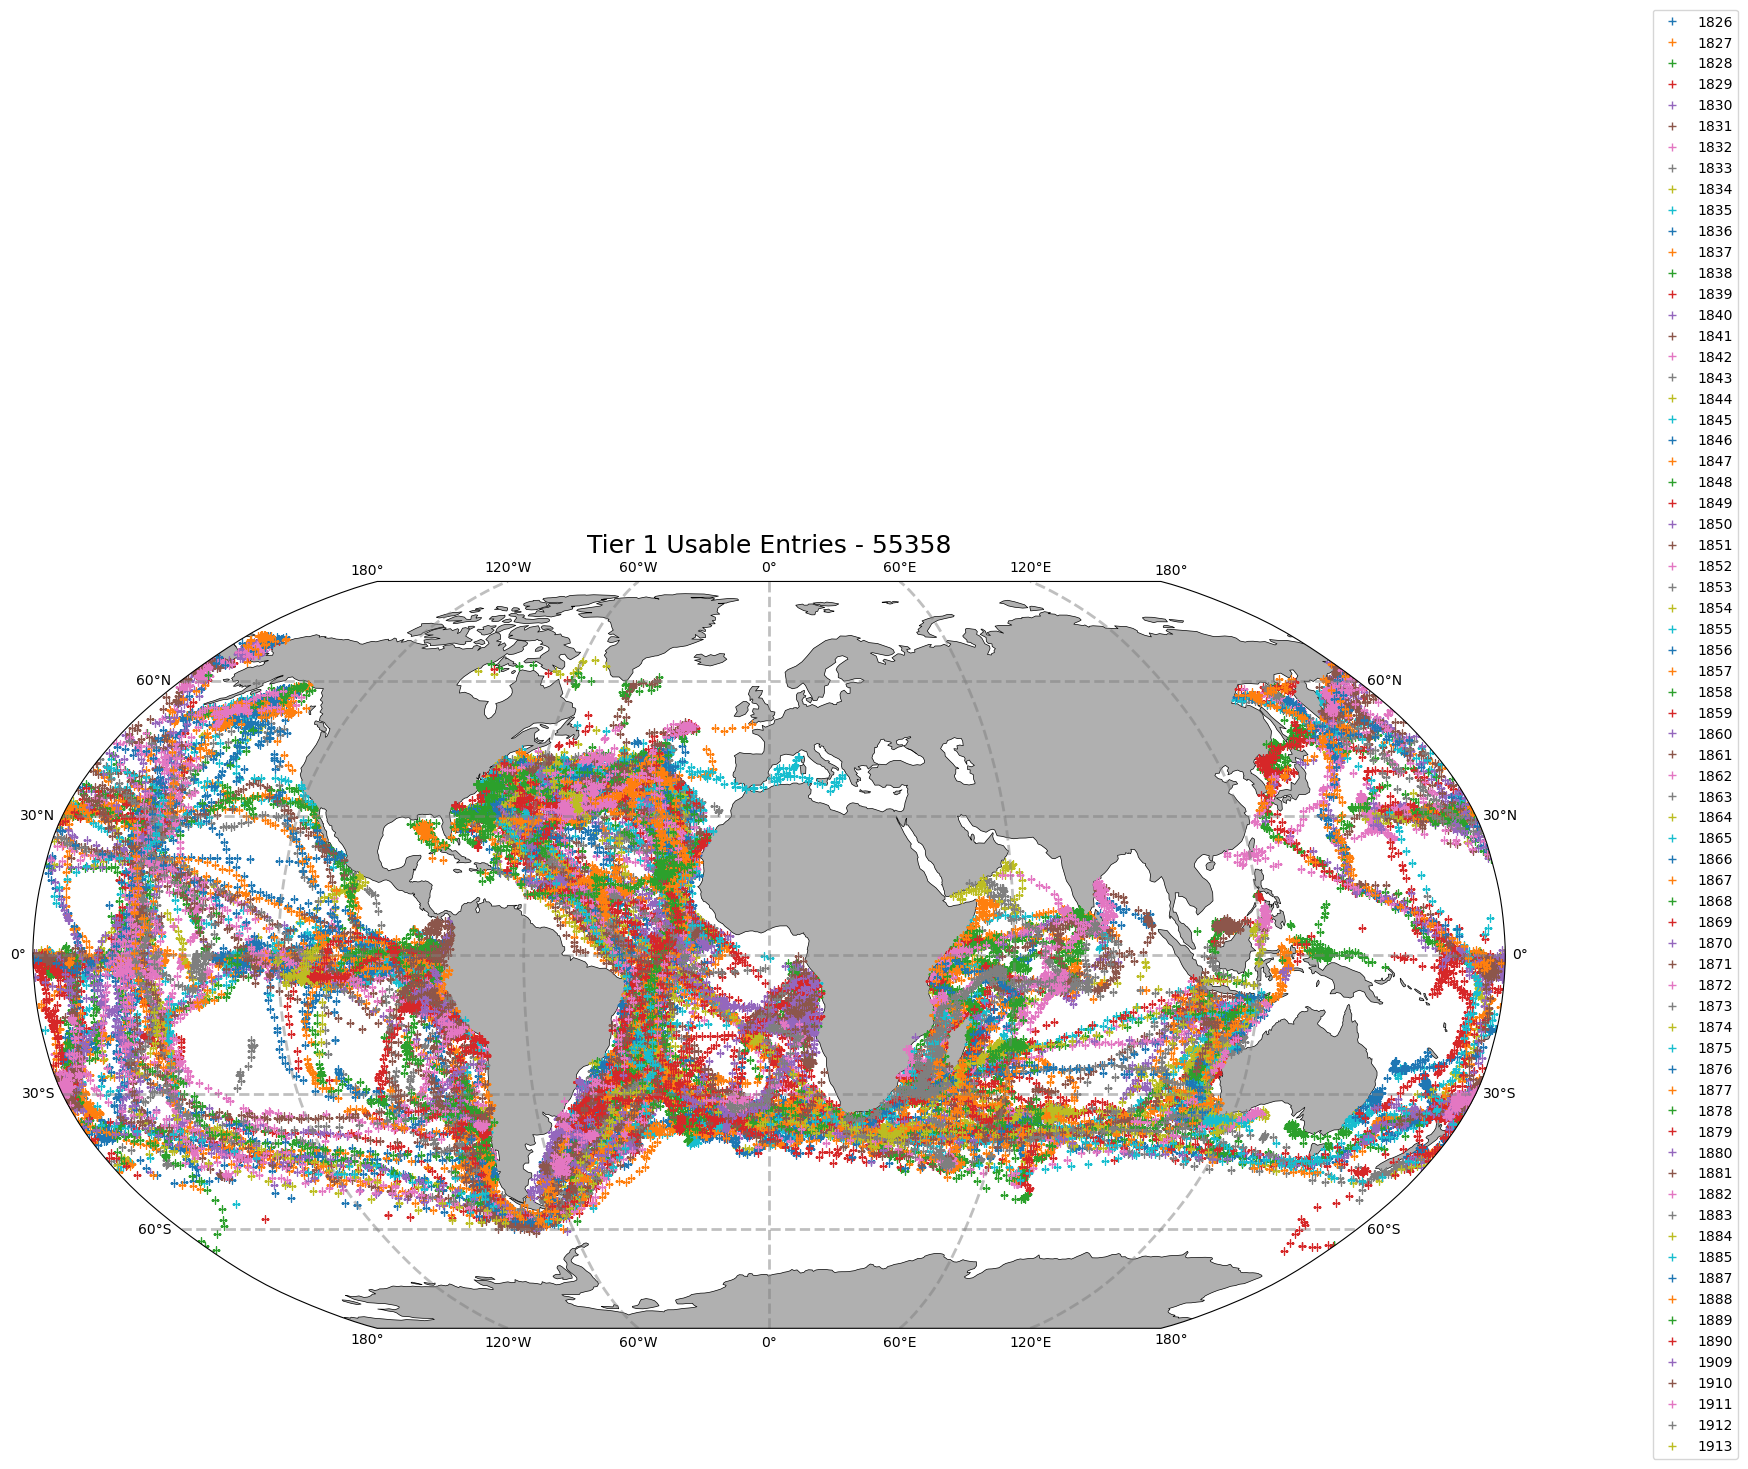

In [103]:
# Plotting the usable data - has lat, lon, wind force term

#Setting up figure parameters
fig, ax = plt.subplots(figsize=(19,20),subplot_kw={'projection':ccrs.Robinson()})
_ = ax.set_global()
_ = ax.coastlines(linewidth=0.5)
_ = ax.add_feature(cfeature.LAND, facecolor='#b0b0b0')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

# Initialize counter for the number of plotted values
num_plotted_values = 0

# Plotting the usable data color coded by year
for yr in sorted(df.loc[(df['usable']==True),'Entry Date Time'].dt.year.dropna().unique()):
    work = df.loc[(df['usable']==True) & (df['Entry Date Time'].dt.year == yr),] #df[df['Entry Date Time'].dt.year == yr]
    _ = ax.plot(work.Longitude, work.Latitude, '+', transform=ccrs.PlateCarree(), label='{:.0f}'.format(yr)) # plot the data
    num_plotted_values += len(work) # keeps track of how many values were plotted
    print(yr,': ',np.shape(work)) # print shape of df for each unique year found

_ = ax.legend(loc=(1.1,-0.175)) # adds legend
plt.title(f'Tier 1 Usable Entries - {num_plotted_values}',fontsize=18) # adds title

# Print the total number of plotted values
print("Total number of plotted values:", num_plotted_values)

# Saving the figures 
fig.savefig(os.path.join(Figures, 'Tier1_Clean_up_plot_usable_Jun10.svg'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join(Figures, 'Tier1_Clean_up_plot_usable_Jun10.jpg'),dpi=300,bbox_inches='tight')


### How many Entries are 'unusable', i.e. do not exhibit Lat./Lon. or Wind Speed values? And Why?

In [89]:
df.loc[(df['usable']==False),"Entry Date Time"]

20      1867-11-26 12:00:00
22      1839-09-24 12:00:00
25      1867-11-22 12:00:00
26      1839-09-23 12:00:00
27      1867-11-21 12:00:00
                ...        
98137   1855-07-18 12:00:00
98140   1855-07-15 12:00:00
98141   1855-07-14 12:00:00
98148   1855-11-30 12:00:00
98152   1855-11-26 12:00:00
Name: Entry Date Time, Length: 41025, dtype: datetime64[ns]

In [90]:
df.loc[(df['usable']==False)]

DateTime        ID                       LogBook ID  Page  \
20     1867-11-26 12:00:00  101357.0         Catalpa (bark) 1867-1871  44.0   
22     1839-09-24 12:00:00  101355.0  Gideon Howland (Ship) 1838-1842  46.0   
25     1867-11-22 12:00:00  101350.0         Catalpa (bark) 1867-1871  43.0   
26     1839-09-23 12:00:00  101351.0  Gideon Howland (Ship) 1838-1842  45.0   
27     1867-11-21 12:00:00  101349.0         Catalpa (bark) 1867-1871  43.0   
...                    ...       ...                              ...   ...   
98137  1855-07-18 12:00:00     559.0           Alpha (ship) 1855-1859   6.0   
98140  1855-07-15 12:00:00     556.0           Alpha (ship) 1855-1859   5.0   
98141  1855-07-14 12:00:00     555.0           Alpha (ship) 1855-1859   5.0   
98148  1855-11-30 12:00:00     548.0           Alpha (ship) 1855-1859  30.0   
98152  1855-11-26 12:00:00     544.0           Alpha (ship) 1855-1859  30.0   

        Latitude   Longitude  Depth Depth Unit Bottom  \
20           NaN         NaN    NaN        NaN    NaN   
22     -0.100000  160.983333    NaN        NaN    NaN   
25    -37.583333  -52.350000    NaN        NaN    NaN   
26     -0.650000  167.116667    NaN        NaN    NaN   
27    -36.200000  -51.566667    NaN        NaN    NaN   
...          ...         ...    ...        ...    ...   
98137  39.950000  -62.666667    NaN        NaN    NaN   
98140        NaN         NaN    NaN    Fathoms    NaN   
98141        NaN         NaN    NaN    Fathoms    NaN   
98148        NaN         NaN    NaN        NaN    NaN   
98152 -42.633333  106.433333    NaN        NaN    NaN   

                                   Landmark Ship Heading/Course  \
20                                      NaN                 NaN   
22                                      NaN                  NE   
25                                      NaN                  SW   
26     Pleasant Island in sight bearing ENE                 NaN   
27                                      NaN                  SW   
...                                     ...                 ...   
98137                                   NaN                   E   
98140                                   NaN      SE by the wind   
98141                                   NaN  W by N by the wind   
98148                                   NaN                E SE   
98152                                   NaN             SE by E   

      Wind Direction Wind Speed/Force  Wind Force              Sea State  \
20               NaN      light winds         2.0                    NaN   
22               NaN              NaN         NaN                   calm   
25             315.0              NaN         NaN                    NaN   
26               NaN              NaN         NaN  calm, Current going W   
27             315.0              NaN         NaN                    NaN   
...              ...              ...         ...                    ...   
98137          247.5            winds         NaN                    NaN   
98140           67.5              NaN         NaN                    NaN   
98141          202.5     fine breezes         5.0                    NaN   
98148          225.0   strong breezes         6.0                    NaN   
98152           22.5         blows on         NaN                    NaN   

      Cloud Cover  Weather Ship Sightings Miscellaneous Observations  \
20            NaN      fog            NaN                        NaN   
22          clear      NaN            NaN                        NaN   
25            NaN      NaN            NaN                        NaN   
26            NaN      NaN            NaN                        NaN   
27            NaN     fine            NaN                        NaN   
...           ...      ...            ...                        ...   
98137         NaN     fine            NaN                        NaN   
98140         NaN      NaN            NaN                        NaN   
98141         NaN 

### Automatic Detection of stagnant Lat-Lon Intervals

Not entirely sure what is being done in this section, but does not impact cleaning of the dataset - Tessa

In [91]:
#List of Logbooks
np.shape(df["LogBook ID"].unique())
df["LogBook ID"].unique()
logbook = df["LogBook ID"].unique()
print(logbook)

['Catalpa (bark) 1867-1871' 'Gideon Howland (Ship) 1838-1842'
 'Young Phenix (ship) 1836-1840' 'Lancer (Ship) 1865-1868'
 'Martha (ship) 1836-1838' 'Navy (Ship) 1851-1855' nan
 'Greyhound (Bark) 1851-1853' 'Timoleon (Ship) 1835-1839'
 'Louvre (Ship) 1842' 'Ann (Ship) 1841' 'Octavia (Bark) 1837-1839'
 'Draco (Bark) 1851-1854' 'Chariot (Ship) 1838-1840'
 'Statira (Ship) 1839-1843' 'Courser (Bark) 1865-1869'
 'William Wirt (Ship) 1850-1853' 'John (ship) 1836-1838'
 'Brandt (Ship) 1838-1839' 'Gideon Howland (ship) 1836-1838'
 'Orion (Brig) 1837' 'Walter Irving (Schooner) 1852-1853'
 'Ocean (Bark) 1879-1882' 'Walter Irving (Schooner) 1856-1857'
 'George (ship) 1836-1837' 'Walter Irving (Schooner) 1855-1856'
 'Walter Irving (Schooner) 1855' 'General Jackson (ship) 1836-1839' 4.5 10
 'Walter Irving (Schooner) 1854-1855' 'Walter Irving (Schooner) 1853-1854'
 'Ocean (Bark) 1878' 'Isabella (Brig) 1878-1879' 'Beaver (Ship) 1840-1842'
 'Walter Irving (Schooner) 1851' 'Walter Irving (Schooner) 1850

In [92]:
# Create data frames for every individual logbook and sort entries by "Entry Date Time"

for item in logbook:
    df_logbook = df[df["LogBook ID"] == item].sort_values(by='Entry Date Time')
    df_logbook["lat_gap"] = (df_logbook['Latitude'] == np.nan)
    df_logbook["lon_gap"] = (df_logbook['Longitude'] == np.nan)
    l = len(df_logbook.index)
    for x in range(l):
        if x in df_logbook.index:
            if df_logbook.lat_gap[x] == True:
                print(x,'true')
            elif df_logbook.lat_gap[x] == False:
                print(x,'not true')
            else:
                print(x,'else')
    print(np.shape(df_logbook))

print(df_logbook)

0 not true
1 not true
2 not true
3 not true
4 not true
5 not true
6 not true
7 not true
8 not true
9 not true
10 not true
11 not true
12 not true
13 not true
14 not true
15 not true
16 not true
17 not true
19 not true
20 not true
21 not true
23 not true
24 not true
25 not true
27 not true
28 not true
29 not true
31 not true
32 not true
33 not true
34 not true
36 not true
37 not true
38 not true
39 not true
40 not true
42 not true
43 not true
44 not true
46 not true
48 not true
49 not true
50 not true
51 not true
52 not true
(206, 27)
18 not true
22 not true
26 not true
30 not true
35 not true
41 not true
45 not true
47 not true
95 not true
96 not true
97 not true
98 not true
99 not true
100 not true
101 not true
102 not true
103 not true
104 not true
105 not true
109 not true
110 not true
111 not true
112 not true
113 not true
114 not true
115 not true
116 not true
117 not true
118 not true
119 not true
120 not true
121 not true
122 not true
123 not true
124 not true
125 not true
128 n

In [93]:
df_logbook

DateTime     ID              LogBook ID  Page   Latitude  \
98142  1855-07-13 12:00:00  554.0  Alpha (ship) 1855-1859   5.0  38.866667   
98141  1855-07-14 12:00:00  555.0  Alpha (ship) 1855-1859   5.0        NaN   
98140  1855-07-15 12:00:00  556.0  Alpha (ship) 1855-1859   5.0        NaN   
98139  1855-07-16 12:00:00  557.0  Alpha (ship) 1855-1859   6.0  38.950000   
98138  1855-07-17 12:00:00  558.0  Alpha (ship) 1855-1859   6.0  39.383333   
...                    ...    ...                     ...   ...        ...   
98147  1855-12-01 12:00:00  549.0  Alpha (ship) 1855-1859  30.0 -44.850000   
98146  1855-12-02 12:00:00  550.0  Alpha (ship) 1855-1859  31.0 -44.833333   
98145  1855-12-03 12:00:00  551.0  Alpha (ship) 1855-1859  31.0 -45.000000   
98144  1855-12-04 12:00:00  552.0  Alpha (ship) 1855-1859  31.0 -45.466667   
98143  1855-12-05 12:00:00  553.0  Alpha (ship) 1855-1859  31.0 -45.583333   

        Longitude  Depth Depth Unit Bottom Landmark Ship Heading/Course  \
98142  -70.366667    NaN    Fathoms    NaN      NaN                   E   
98141         NaN    NaN    Fathoms    NaN      NaN  W by N by the wind   
98140         NaN    NaN    Fathoms    NaN      NaN      SE by the wind   
98139  -60.450000    NaN    Fathoms    NaN      NaN       S by the wind   
98138  -66.716667    NaN        NaN    NaN      NaN    E NE by the wind   
...           ...    ...        ...    ...      ...                 ...   
98147  128.950000    NaN        NaN    NaN      NaN                E SE   
98146  131.000000    NaN        NaN    NaN      NaN              E by S   
98145  133.266667    NaN        NaN    NaN      NaN              E by S   
98144  140.066667    NaN    Fathoms    NaN      NaN              E by S   
98143  142.700000    NaN    Fathoms    NaN      NaN                   E   

      Wind Direction Wind Speed/Force  Wind Force Sea State Cloud Cover  \
98142          225.0    light breezes         2.0       NaN         NaN   
98141          202.5     fine breezes         5.0       NaN         NaN   
98140           67.5              NaN         NaN       NaN         NaN   
98139          112.5    light breezes         2.0       NaN         NaN   
98138          135.0    light breezes         2.0       NaN         NaN   
...              ...              ...         ...       ...         ...   
98147          292.5   strong breezes         6.0       NaN         NaN   
98146          247.5   blowing a gale         8.0       NaN         NaN   
98145          270.0   strong breezes         6.0       NaN         NaN   
98144          247.5   strong breezes         6.0       NaN         NaN   
98143          225.0    light breezes         2.0       NaN         NaN   

      Weather Ship Sightings Miscellaneous Observations wind force  \
98142    calm            NaN                        NaN      False   
98141     NaN            NaN                        NaN      False   
98140     NaN            NaN                        NaN      False   
98139     NaN            NaN                        NaN      False   
98138     NaN            NaN                        NaN      False   
...       ...            ...                        ...        ...   
98147     fog            NaN                        NaN      False   
98146     NaN            NaN                        NaN      False   
98145     NaN            NaN                        NaN      False   
98144     NaN            NaN                        NaN      False   
98143     NaN            NaN                        NaN      False   

          Entry Date Time Direction Wind Direction Before  coord_diff  usable  \
98142 1855-07-13 12:00:00       nan                    SW       False    True   
98141 1855-07-14 12:00:00       nan                  S SW       False   False   
98140 1855-07-15 12:00:00       nan                  E NE       False   False   
98139 1855-07-16 12:00:00       nan                  E SE       False    True   
98138 1855-07-17 12:00:00       n

In [94]:
df['usable_latlon'] = (df["Latitude"].notna() & df["Longitude"].notna())
print("Number of unique Logbook IDs with lat.+lon. info ",np.shape(df.loc[(df['usable_latlon']==True),'LogBook ID'].unique()))
print("Number of unique Logbook IDs without lat.+lon. info ",np.shape(df.loc[(df['usable_latlon']==False),'LogBook ID'].unique()))

df.loc[(df['usable_latlon']==True),'Entry Date Time']

Number of unique Logbook IDs with lat.+lon. info  (167,)
Number of unique Logbook IDs without lat.+lon. info  (163,)


/tmp/ipykernel_603925/508917476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usable_latlon'] = (df["Latitude"].notna() & df["Longitude"].notna())


0       1867-12-15 12:00:00
1       1867-12-14 12:00:00
2       1867-12-13 12:00:00
3       1867-12-12 12:00:00
4       1867-12-11 12:00:00
                ...        
98173   1855-11-06 12:00:00
98174   1855-11-05 12:00:00
98175   1855-11-04 12:00:00
98176   1855-11-03 12:00:00
98177   1855-11-02 12:00:00
Name: Entry Date Time, Length: 62081, dtype: datetime64[ns]

Only Lat


In [95]:
df['usable_lat'] = (df["Latitude"].notna())
print("Number of unique Logbook IDs with lat. info ",np.shape(df.loc[(df['usable_lat']==True),'LogBook ID'].unique()))
print("Number of unique Logbook IDs without lat. info ",np.shape(df.loc[(df['usable_lat']==False),'LogBook ID'].unique()))

Number of unique Logbook IDs with lat. info  (169,)
Number of unique Logbook IDs without lat. info  (162,)


/tmp/ipykernel_603925/4108156717.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['usable_lat'] = (df["Latitude"].notna())


### Write "Clean" Data to CSV

In [96]:
df.to_csv(os.path.join(CSV, 'Tier1_logentries-export-2024-06-10.csv'), index = False) #.csv file seems unreadable, don't know what the issue is: using pickle instead
df.to_pickle("Tier1_logentries-export-2024-06-10.pkl") # save data as a pkl file
#.pkl can serialize a very wide range of objects, not just text data

df.info() # shows columns and rows in each column
df.head() # shows first five rows of dataset

<class 'pandas.core.frame.DataFrame'>
Index: 96383 entries, 0 to 98177
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   DateTime                    96378 non-null  object        
 1   ID                          96380 non-null  float64       
 2   LogBook ID                  96379 non-null  object        
 3   Page                        59413 non-null  float64       
 4   Latitude                    72421 non-null  float64       
 5   Longitude                   62459 non-null  float64       
 6   Depth                       2134 non-null   float64       
 7   Depth Unit                  22937 non-null  object        
 8   Bottom                      63 non-null     object        
 9   Landmark                    15197 non-null  object        
 10  Ship Heading/Course         53219 non-null  object        
 11  Wind Direction              67518 non-null  object        


DateTime        ID                LogBook ID  Page   Latitude  \
0  1867-12-15 12:00:00  101378.0  Catalpa (bark) 1867-1871  48.0 -57.500000   
1  1867-12-14 12:00:00  101377.0  Catalpa (bark) 1867-1871  47.0 -58.500000   
2  1867-12-13 12:00:00  101376.0  Catalpa (bark) 1867-1871  47.0 -59.166667   
3  1867-12-12 12:00:00  101375.0  Catalpa (bark) 1867-1871  47.0 -58.133333   
4  1867-12-11 12:00:00  101374.0  Catalpa (bark) 1867-1871  47.0 -57.833333   

   Longitude  Depth Depth Unit Bottom Landmark Ship Heading/Course  \
0 -73.666667    NaN        NaN    NaN      NaN                   W   
1 -69.666667    NaN        NaN    NaN      NaN                 WSW   
2 -67.683333    NaN        NaN    NaN      NaN                  SE   
3 -68.500000    NaN        NaN    NaN      NaN                 NaN   
4 -67.533333    NaN        NaN    NaN      NaN                 NaN   

  Wind Direction Wind Speed/Force  Wind Force Sea State Cloud Cover  \
0          225.0      strong gale         9.0       NaN         NaN   
1          180.0     strong winds         6.0       NaN         NaN   
2          225.0      strong gale         9.0       NaN         NaN   
3          225.0     strong winds         6.0       NaN         NaN   
4          270.0      light winds         2.0       NaN         NaN   

        Weather Ship Sightings Miscellaneous Observations wind force  \
0           NaN            NaN                        NaN      False   
1           NaN            NaN                        NaN      False   
2           NaN            NaN                        NaN      False   
3  rain squalls            NaN                        NaN      False   
4       squalls            NaN                        NaN      False   

      Entry Date Time Direction Wind Direction Before  coord_diff  usable  \
0 1867-12-15 12:00:00       nan                   SSW       False    True   
1 1867-12-14 12:00:00       nan                     S       False    True   
2 1867-12-13 12:00:00       nan                    SW       False    True   
3 1867-12-12 12:00:00       nan            SSW to WSW       False    True   
4 1867-12-11 12:00:00       nan                     W       False    True   

   usable_latlon  usable_lat  
0           True        True  
1           True        True  
2           True        True  
3           True        True  
4           True        True

In [98]:
# Creating a dataframe of usable lat/lon data just to see how many entries we have
df['hi'] = (df["Latitude"].notna() & df["Longitude"].notna())
df_hi = df[df['hi']==True]
df_hi

/tmp/ipykernel_603925/1033581246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hi'] = (df["Latitude"].notna() & df["Longitude"].notna())


DateTime        ID                LogBook ID  Page  \
0      1867-12-15 12:00:00  101378.0  Catalpa (bark) 1867-1871  48.0   
1      1867-12-14 12:00:00  101377.0  Catalpa (bark) 1867-1871  47.0   
2      1867-12-13 12:00:00  101376.0  Catalpa (bark) 1867-1871  47.0   
3      1867-12-12 12:00:00  101375.0  Catalpa (bark) 1867-1871  47.0   
4      1867-12-11 12:00:00  101374.0  Catalpa (bark) 1867-1871  47.0   
...                    ...       ...                       ...   ...   
98173  1855-11-06 12:00:00     520.0    Alpha (ship) 1855-1859  26.0   
98174  1855-11-05 12:00:00     519.0    Alpha (ship) 1855-1859  26.0   
98175  1855-11-04 12:00:00     518.0    Alpha (ship) 1855-1859  26.0   
98176  1855-11-03 12:00:00     517.0    Alpha (ship) 1855-1859  26.0   
98177  1855-11-02 12:00:00     516.0    Alpha (ship) 1855-1859  26.0   

        Latitude  Longitude  Depth Depth Unit Bottom Landmark  \
0     -57.500000 -73.666667    NaN        NaN    NaN      NaN   
1     -58.500000 -69.666667    NaN        NaN    NaN      NaN   
2     -59.166667 -67.683333    NaN        NaN    NaN      NaN   
3     -58.133333 -68.500000    NaN        NaN    NaN      NaN   
4     -57.833333 -67.533333    NaN        NaN    NaN      NaN   
...          ...        ...    ...        ...    ...      ...   
98173 -40.116667  39.033333    NaN    Fathoms    NaN      NaN   
98174 -39.983333  28.150000    NaN    Fathoms    NaN      NaN   
98175 -40.383333  23.616667    NaN    Fathoms    NaN      NaN   
98176 -40.083333  19.716667    NaN    Fathoms    NaN      NaN   
98177 -38.983333  16.600000    NaN    Fathoms    NaN      NaN   

      Ship Heading/Course Wind Direction                 Wind Speed/Force  \
0                       W          225.0                      strong gale   
1                     WSW          180.0                     strong winds   
2                      SE          225.0                      strong gale   
3                     NaN          225.0                     strong winds   
4                     NaN          270.0                      light winds   
...                   ...            ...                              ...   
98173             SE by E          337.5                    moderate gale   
98174   "Middle moderate"          337.5  strong breeze and squally winds   
98175             SE by E          337.5                   strong breezes   
98176             SE by S          225.0                   strong breezes   
98177              W by S          225.0                            light   

       Wind Force Sea State Cloud Cover       Weather Ship Sightings  \
0             9.0       NaN         NaN           NaN            NaN   
1             6.0       NaN         NaN           NaN            NaN   
2             9.0       NaN         NaN           NaN            NaN   
3             6.0       NaN         NaN  rain squalls            NaN   
4             2.0       NaN         NaN       squalls            NaN   
...           ...       ...         ...           ...            ...   
98173         8.0       NaN         NaN       squally            NaN   
98174         6.0       NaN         NaN           NaN            NaN   
98175         6.0       NaN         NaN           NaN            NaN   
98176         6.0       NaN         NaN           NaN            NaN   
98177         2.0       NaN         NaN           NaN            NaN   

                              Miscellaneous Observations wind force  \
0                                                    NaN      False   
1                                                    NaN      False   
2                                                    NaN      False   
3                                                    NaN      False   
4                                                    NaN      False   
...                                                  ...        ...   
98173  "Under fore and main topsail and foresail, miz...      False   
98174         

In [99]:
# Creating a dataframe to see how many entries have a wind force value
df['i'] = (df["Wind Speed/Force"].isna())
df_i = df[df['i']==True]
df_i

/tmp/ipykernel_603925/1722858871.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['i'] = (df["Wind Speed/Force"].isna())


DateTime        ID                       LogBook ID  Page  \
22     1839-09-24 12:00:00  101355.0  Gideon Howland (Ship) 1838-1842  46.0   
25     1867-11-22 12:00:00  101350.0         Catalpa (bark) 1867-1871  43.0   
26     1839-09-23 12:00:00  101351.0  Gideon Howland (Ship) 1838-1842  45.0   
27     1867-11-21 12:00:00  101349.0         Catalpa (bark) 1867-1871  43.0   
28     1867-11-20 12:00:00  101348.0         Catalpa (bark) 1867-1871  43.0   
...                    ...       ...                              ...   ...   
97988  1860-09-05 12:00:00     712.0           Alpha (ship) 1860-1865  29.0   
98032  1860-07-23 12:00:00     668.0           Alpha (ship) 1860-1865  21.0   
98116  1855-08-08 12:00:00     580.0           Alpha (ship) 1855-1859  10.0   
98117  1855-08-07 12:00:00     579.0           Alpha (ship) 1855-1859  10.0   
98140  1855-07-15 12:00:00     556.0           Alpha (ship) 1855-1859   5.0   

        Latitude   Longitude  Depth Depth Unit Bottom  \
22     -0.100000  160.983333    NaN        NaN    NaN   
25    -37.583333  -52.350000    NaN        NaN    NaN   
26     -0.650000  167.116667    NaN        NaN    NaN   
27    -36.200000  -51.566667    NaN        NaN    NaN   
28    -35.500000  -49.483333    NaN        NaN    NaN   
...          ...         ...    ...        ...    ...   
97988  38.416667         NaN    NaN        NaN    NaN   
98032  41.616667  -33.750000    NaN        NaN    NaN   
98116  39.883333  -32.133333    NaN        NaN    NaN   
98117        NaN         NaN    NaN        NaN    NaN   
98140        NaN         NaN    NaN    Fathoms    NaN   

                                                Landmark  \
22                                                   NaN   
25                                                   NaN   
26                  Pleasant Island in sight bearing ENE   
27                                                   NaN   
28                                                   NaN   
...                                                  ...   
97988  "Laying off and on at Flores" [This is an erro...   
98032                                                NaN   
98116                         Off Flores Island (Azores)   
98117  Laying off & on Flores. "Land about 12 miles o...   
98140                                                NaN   

                    Ship Heading/Course Wind Direction Wind Speed/Force  \
22                                   NE            NaN              NaN   
25                                   SW          315.0              NaN   
26                                  NaN            NaN              NaN   
27                                   SW          315.0              NaN   
28                                  NaN            NaN              NaN   
...                                 ...            ...              ...   
97988                               NaN           22.5              NaN   
98032                               NaN            NaN              NaN   
98116  Laying on & off Island of Flores            NaN              NaN   
98117            Laying off & on Flores            NaN              NaN   
98140                    SE by the wind           67.5              NaN   

       Wind Force              Sea State Cloud Cover Weather Ship Sightings  \
22            NaN                   calm       clear     NaN            NaN   
25            NaN                    NaN         NaN     NaN            NaN   
26            NaN  calm, Current going W         NaN     NaN            NaN   
27            NaN                    NaN         NaN    fine            NaN   
28            NaN                    NaN         NaN    fine            NaN   
...           ...                    ...         ...     ...            ...   
97988         NaN                    NaN         NaN     NaN            NaN   
98032         NaN                    NaN         NaN    fair            NaN   
98116         NaN                    NaN         Na